<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Porsche/Porsche_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "PAH3DEEUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-28 16:15:58,250 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-28 16:15:58,254 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for PAH3DEEUR
2019-08-28 16:17:06,189 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-28 16:19:24,901 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-28 16:20:37,354 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-28 16:21:29,671 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-28 16:22:19,272 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-28 16:23:11,948 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-28 16:24:19,896 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-28 16:25:27,206 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-28 16:29:02,865 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_445__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_PAH3DEEUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-PAH3DEEUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-PAH3DEEUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close     Volume
Date                                                              
2018-01-02 08:00:00  0.69938  0.69938  0.68137  0.68167  94.557800
2018-01-02 09:00:00  0.68167  0.68488  0.67728  0.68268  67.993202
2018-01-02 10:00:00  0.68217  0.68977  0.68217  0.68868  73.173996
2018-01-02 11:00:00  0.68828  0.69268  0.68828  0.69227  55.171200
2018-01-02 12:00:00  0.69228  0.69508  0.69227  0.69508  47.098488
...                      ...      ...      ...      ...        ...
2018-12-28 08:00:00  0.51437  0.52058  0.51137  0.51957  52.778885
2018-12-28 09:00:00  0.51978  0.52098  0.51697  0.51997  23.639423
2018-12-28 10:00:00  0.51998  0.52138  0.51777  0.51798  16.126303
2018-12-28 11:00:00  0.51797  0.51858  0.51358  0.51397  22.328636
2018-12-28 12:00:00  0.51398  0.51718  0.51398  0.51718  26.004957

[2244 rows x 5 columns]

Open         High          Low        Close       Volume
count  2244.000000  2244.000000  2244.000000  2244.000000  2244.000000
mean      0.621203     0.623550     0.618697     0.621087    27.507345
std       0.075812     0.075863     0.075764     0.075823    22.889933
min       0.505580     0.507180     0.500020     0.505570     1.903633
25%       0.557580     0.559780     0.554970     0.557770    14.091109
50%       0.586830     0.589070     0.584370     0.586475    20.700091
75%       0.692022     0.694973     0.688970     0.691980    32.613558
max       0.799770     0.802780     0.793180     0.799780   235.099289

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close      Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
2018-01-09 13:00:00  0.75487  0.76048  0.75437  0.75937  102.686996    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.750880  0.740159  0.742318  0.755133  0.750700  0.750228    0.752370    0.751775  0.742944  0.749513  0.756344  0.748582  0.751517  0.749513  0.754307  0.743047                0.758821                 0.749513                0.740204                0.763475                 0.749513                0.735550                0.768129                 0.749513                0.730896                0.772783                 0.749513                0.726242  0.750700  0.755342  0.744010                0.760009                 0.750700                0.741392                0.764663                 0.750700                0.736738                0.769317                 0.750700                0.732084                0.773971                 0.750700   
2018-01-09 14:00:00  0.75937  0.75938  0.75497  0.75508  111.224297    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.751090  0.740432  0.743408  0.755878  0.751674  0.750762    0.752620    0.751825  0.744347  0.750726  0.756643  0.750172  0.752754  0.750726  0.757225  0.744030                0.760090                 0.750726                0.741363                0.764771                 0.750726                0.736681                0.769453                 0.750726                0.732000                0.774134                 0.750726                0.727318  0.751674  0.755759  0.745009                0.761037                 0.751674                0.742310                0.765718                 0.751674                0.737629                0.770400                 0.751674                0.732947                0.775082                 0.751674   
2018-01-09 15:00:00  0.75508  0.75567  0.75307  0.75527  105.891899    9          1          9             31   

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000    2194.000000  2194.000000   2194.000000     2194.000000       2194.000000  2194.000000  2194.000000  2194.000000  2194.000000   2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000  2194.000000  2194.000000  2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000             2194.000000   
mean      0.618865     0.621199     0.616346     0.618728    26.339642    15.958979     2.032817   184.346855      30.416135    11.380128      0.032361        0.024157          0.004102     6.562899     2.522789    26.902005     2.032817      1.989973    26.902005     0.619257     0.620189    -0.038313     0.618737     0.619096     0.619398     0.619066     0.618983     0.619499     0.619099     0.618726     0.619099     0.618976     0.619099     0.618821     0.619805                0.626770                 0.619099                0.611429                0.630605                 0.619099                0.607594                0.634440                 0.619099                0.603758                0.638275                 0.619099                0.599923     0.619096     0.618812     0.619703                0.626767                 0.619096                0.611426                0.630602                 0.619096                0.607590                0.634437   
std       0.074996     0.075033     0.074926     0.074976    21.419096     8.554813     1.407691   101.476202       0.856048     2.621509      0.176997        0.153571          0.063931     3.340928     1.100379    14.496189     1.407691      1.399918    14.496189     0.074865     0.074677     0.622698     0.075030     0.074849     0.074684     0.074886     0.074784     0.075082     0.074913     0.075009     0.074943     0.074913     0.074913     0.074947     0.074806                0.075103                 0.074913                0.074994                0.075300                 0.074913                0.075137                0.075563                 0.074913                0.075347                0.075894                 0.074913                0.075625     0.074849     0.074936     0.074821                0.075046                 0.074849                0.074925                0.075246                 0.074849                0.075065                0.075513   
min       0.505580     0.507180     0.500020     0.505570     1.903633     1.000000     0.000000     9.000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.847378  0.856901  0.867615  0.862649  0.432184    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.864209  0.838627  0.972134  0.865135  0.860542  0.860033    0.858973    0.853969  0.802365  0.853412  0.865524  0.846855  0.858802  0.853412  0.853905  0.842312                0.854727                 0.853412                0.854673                0.851638                 0.853412                0.858254                0.848265                 0.853412                0.858400                0.844462                 0.853412                0.852941  0.860542  0.862349  0.844456                0.855875                 0.860542                0.860077                0.851665                 0.860542                0.863440                0.847436                 0.860542                0.859689                0.843966                 0.860542   
2018-01-09 14:00:00  0.862674  0.853180  0.869662  0.848068  0.468794    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.864960  0.839649  0.972820  0.867731  0.864018  0.861962    0.859854    0.854144  0.806999  0.857712  0.866557  0.852458  0.863174  0.857712  0.863967  0.845921                0.859141                 0.857712                0.858707                0.856087                 0.857712                0.862078                0.852748                 0.857712                0.862001                0.848959                 0.857712                0.856302  0.864018  0.863798  0.848109                0.859456                 0.864018                0.863336                0.855288                 0.864018                0.866511                0.851096                 0.864018                0.862545                0.847647                 0.864018   
2018-01-09 15:00:00  0.848091  0.840629  0.863181  0.848713  0.445927    9          1          9         

139594

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         4 hours 42 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_wrcja9
H2O cluster total nodes:    1
H2O cluster free memory:    8.45 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_163937_mod...  0.586986  0.688425              0.475410  0.497633  0.247639
1  DeepLearning_grid_1_AutoML_20190828_163937_mod...  0.545166  0.698154              0.487705  0.502496  0.252502
2  DeepLearning_grid_1_AutoML_20190828_163937_mod...  0.504349  0.693320              0.495902  0.500094  0.250094
3  DeepLearning_grid_1_AutoML_20190828_163937_mod...  0.500000  0.693191              0.500000  0.500022  0.250022
4  DeepLearning_grid_1_AutoML_20190828_163937_mod...  0.494982  3.508498              0.495902  0.654254  0.428048
5  DeepLearning_grid_1_AutoML_20190828_163937_mod...  0.494647  0.751027              0.500000  0.525091  0.275720
6              DeepLearning_1_AutoML_20190828_163937  0.492974  0.796540              0.495902  0.541398  0.293112
7  DeepLearning_grid_1_AutoML_20190828_163937_mod...  0.478630  0.690928              0.500000  0.498888  0.248890
8  DeepLearning_grid_1_AutoML_20190828_163937_mod...  0.471311  0.778959              0.500000  0.527201  0.277941
9  DeepLearning_grid_1_AutoML_20190828_163937_mod...  0.419287  1.347384              0.500000  0.643406  0.413972

variable  relative_importance  scaled_importance  percentage
0               STOCHRSI_fastd             1.000000           1.000000    0.001376
1                  aroondown_8             0.969592           0.969592    0.001334
2                 HT_TRENDMODE             0.939853           0.939853    0.001293
3                    CORREL_12             0.929123           0.929123    0.001279
4                  STOCH_slowk             0.912120           0.912120    0.001255
...                        ...                  ...                ...         ...
1028                      ATAN             0.621938           0.621938    0.000856
1029  BBANDS_middleband_12_4_2             0.617805           0.617805    0.000850
1030   BBANDS_lowerband_14_2_4             0.612869           0.612869    0.000843
1031        CDLSEPARATINGLINES             0.602550           0.602550    0.000829
1032             CDLHIKKAKEMOD             0.551165           0.551165    0.000758

[1033 rows x 4 columns]

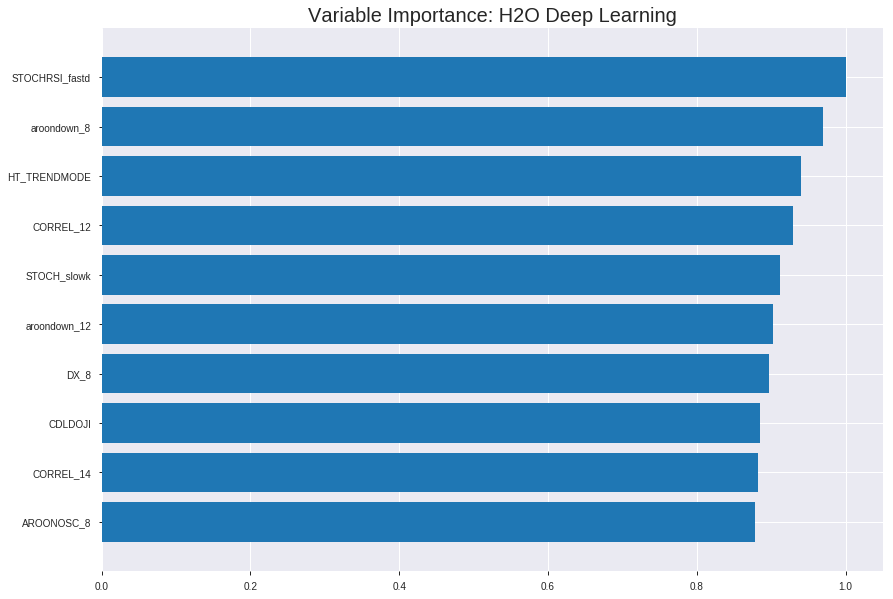

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_163937_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24436948247470863
RMSE: 0.4943374176356759
LogLoss: 0.6811740320511128
Mean Per-Class Error: 0.45367538099704996
AUC: 0.5587248664301154
pr_auc: 0.5636798160898465
Gini: 0.11744973286023086
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4515393447707946: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      29   763   0.9634   (763.0/792.0)
1      2    741   0.0027   (2.0/743.0)
Total  31   1504  0.4984   (765.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.451539     0.659546  368
max f2                       0.451539     0.827748  368
max f0point5                 0.478814     0.54868   355
max accuracy                 0.486378     0.555049  244
max precision                0.905427     1         0
max recall                   0.225487     1         398
max specificity              0.905427     1         0
max absolute_mcc             0.496103     0.129469  177
max min_per_class_accuracy   0.478897     0.48856   354
max mean_per_class_accuracy  0.482472     0.546325  308

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 48.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.737501           1.80771   1.80771            0.875            0.815681  0.875                       0.815681            0.0188425       0.0188425                  80.7705   80.7705
    2        0.0201954                   0.628927           1.65276   1.73273            0.8              0.683908  0.83871                     0.751919            0.0161507       0.0349933                  65.2759   73.2731
    3        0.0306189                   0.594391           1.42034   1.62639            0.6875           0.609632  0.787234                    0.703481            0.0148048       0.0497981                  42.034    62.6385
    4        0.0403909                   0.572258           0.964109  1.46616            0.466667         0.581859  0.709677                    0.674056            0.00942127      0.0592194                  -3.58905  46.6157
    5        0.0501629                   0.556493           1.51503   1.47568            0.733333         0.56349   0.714286                    0.652517            0.0148048       0.0740242                  51.5029   47.5678
    6        0.100326                    0.508458           1.20737   1.34153            0.584416         0.529222  0.649351                    0.590869            0.0605653       0.13459                    20.7373   34.1525
    7        0.150489                    0.490696           1.15371   1.27892            0.558442         0.4963    0.619048                    0.559346            0.0578735       0.192463                   15.3712   27.8921
    8        0.2                         0.4866             1.06016   1.22476            0.513158         0.488663  0.592834                    0.541848            0.0524899       0.244953                   6.0158    22.4764
    9        0.300326                    0.483698           1.00614   1.15173            0.487013         0.484865  0.557484                    0.522813            0.100942        0.345895                   0.614392  15.1733
    10       0.4                         0.481512           1.01272   1.11709            0.490196         0.482705  0.540717                    0.512818            0.100942        0.446837                   1.272     11.7093
    11       0.971336                    0.478814           0.951703  1.01981            0.460661         0.478969  0.493628                    0.492908            0.543742        0.990579                   -4.82972  1.98111
    12       1                           0.184325           0.328674  1                  0.159091         0.38753   0.484039                    0.489888            0.00942127      1                          -67.1326  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24972557599203699
RMSE: 0.4997255006421395
LogLoss: 0.6925957290519997
Mean Per-Class Error: 0.47433489827856024
AUC: 0.519603547209181
pr_auc: 0.5416707422236452
Gini: 0.03920709441836201
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47951289821779697: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    213  1        (213.0/213.0)
1      0    225  0        (0.0/225.0)
Total  0    438  0.4863   (213.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.479513     0.678733   399
max f2                       0.479513     0.840807   399
max f0point5                 0.479513     0.569044   399
max accuracy                 0.48417      0.531963   293
max precision                0.549039     1          0
max recall                   0.479513     1          399
max specificity              0.549039     1          0
max absolute_mcc             0.530551     0.0920583  15
max min_per_class_accuracy   0.486251     0.511111   211
max mean_per_class_accuracy  0.48417      0.525665   293

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 49.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.544548           1.55733   1.55733            0.8              0.547617  0.8                         0.547617            0.0177778       0.0177778                  55.7333    55.7333
    2        0.0205479                   0.537824           0.973333  1.29778            0.5              0.542259  0.666667                    0.545236            0.00888889      0.0266667                  -2.66667   29.7778
    3        0.0319635                   0.533713           1.55733   1.39048            0.8              0.536033  0.714286                    0.541949            0.0177778       0.0444444                  55.7333    39.0476
    4        0.0410959                   0.524721           1.46      1.40593            0.75             0.529201  0.722222                    0.539116            0.0133333       0.0577778                  46         40.5926
    5        0.0502283                   0.51899            0.486667  1.23879            0.25             0.522818  0.636364                    0.536153            0.00444444      0.0622222                  -51.3333   23.8788
    6        0.100457                    0.503418           0.973333  1.10606            0.5              0.511107  0.568182                    0.52363             0.0488889       0.111111                   -2.66667   10.6061
    7        0.150685                    0.499201           1.06182   1.09131            0.545455         0.501185  0.560606                    0.516148            0.0533333       0.164444                   6.18182    9.13131
    8        0.200913                    0.495327           0.530909  0.951212           0.272727         0.496948  0.488636                    0.511348            0.0266667       0.191111                   -46.9091   -4.87879
    9        0.30137                     0.491598           1.1503    1.01758            0.590909         0.493193  0.522727                    0.505296            0.115556        0.306667                   15.0303    1.75758
    10       0.399543                    0.488129           1.08651   1.03451            0.55814          0.489964  0.531429                    0.501529            0.106667        0.413333                   8.65116    3.45143
    11       0.5                         0.48614            0.973333  1.02222            0.5              0.487009  0.525114                    0.498612            0.0977778       0.511111                   -2.66667   2.22222
    12       0.600457                    0.485122           1.06182   1.02885            0.545455         0.485627  0.528517                    0.49644             0.106667        0.617778                   6.18182    2.88466
    13       0.69863                     0.48433            0.995969  1.02423            0.511628         0.484792  0.526144                    0.494803            0.0977778       0.715556                   -0.403101  2.42266
    14       0.799087                    0.483251           0.973333  1.01783            0.5              0.483891  0.522857                    0.493431            0.0977778       0.813333                   -2.66667   1.78286
    15       0.899543                    0.48184            0.884848  1.00298            0.454545         0.482468  0.515228                    0.492207            0.0888889       0.902222                   -11.5152   0.2978
    16       1                           0.479513           0.973333  1                  0.5              0.481035  0.513699                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:49:06  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 16:49:08  4 min 30.017 sec  346 obs/sec       0.340065  1             522        0.63246          1.66097             -0.601654      0.526196        0.484632           1.54946          0.512052                         0.672802           2.41941               -0.812012        0.5224            0.521639             1.55733            0.46347
    2019-08-28 16:49:30  4 min 52.096 sec  402 obs/sec       5.61694   17            8622       0.503162         0.699627            -0.0137214     0.516039        0.489896           0.774731         0.503583                         0.503692           0.700606              -0.015584        0.497517          0.506284             1.168              0.468037
    2019-08-28 16:49:52  5 min 14.491 sec  438 obs/sec       11.8984   36            18264      0.497827         0.688729            0.00766203     0.544449        0.547864           1.93683          0.509446                         0.50153            0.69622               -0.00688558      0.483026          0.52171              1.55733            0.474886
    2019-08-28 16:50:14  5 min 36.233 sec  461 obs/sec       18.3987   56            28242      0.49784          0.688682            0.00761089     0.541546        0.568264           1.80771          0.505537                         0.502807           0.698793              -0.0120188       0.506145          0.296944             0.988783           0.484018
    2019-08-28 16:50:36  5 min 58.025 sec  485 obs/sec       25.5844   78            39272      0.494337         0.681174            0.021525       0.558725        0.56368            1.80771          0.498371                         0.499726           0.692596              0.000347347      0.519604          0.541671             1.55733            0.486301
    2019-08-28 16:50:58  6 min 19.707 sec  511 obs/sec       33.4248   102           51307      0.499691         0.692126            0.000217855    0.548121        0.544965           1.80771          0.498371                         0.515736           0.727723              -0.0647355       0.475869          0.499176             1.168              0.486301
    2019-08-28 16:51:20  6 min 41.912 sec  542 obs/sec       42.5518   130           65317      0.490997         0.672833            0.0347027      0.559013        0.618048           2.06595          0.489902                         0.501478           0.696112              -0.00667807      0.5               0                    1                  0.486301
    2019-08-28 16:51:22  6 min 44.155 sec  542 obs/sec       42.5518   130           65317      0.494337         0.681174            0.021525       0.558725        0.56368            1.80771          0.498371                         0.499726           0.692596              0.000347347      0.519604          0.541671             1.55733            0.486301

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
STOCHRSI_fastd            1.0                    1.0                  0.0013761457025025059
aroondown_8               0.969592273235321      0.969592273235321    0.0013343002399924225
HT_TRENDMODE              0.939853310585022      0.939853310585022    0.001293375094344331
CORREL_12                 0.9291225075721741     0.9291225075721741   0.0012786079458937992
STOCH_slowk               0.9121195673942566     0.9121195673942566   0.001255209422838051
---                       ---                    ---                  ---
ATAN                      0.6219375729560852     0.6219375729560852   0.0008558767182483554
BBANDS_middleband_12_4_2  0.6178048253059387     0.6178048253059387   0.000850189455330079
BBANDS_lowerband_14_2_4   0.6128686666488647     0.6128686666488647   0.0008433965818072761
CDLSEPARATINGLINES        0.602550208568573      0.602550208568573    0.0008291968800636303
CDLHIKKAKEMOD             0.5511646866798401     0.5511646866798401   0.0007584829149456021


See the whole table with table.as_data_frame()


('accuracy', 0.6136363636363636)

('F1', 0.6282051282051282)

('auc', 0.5869856139176982)

('logloss', 0.6884252297759916)

('mean_per_class_error', 0.4115925058548009)

('rmse', 0.49763316992684464)

('mse', 0.2476387718114398)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


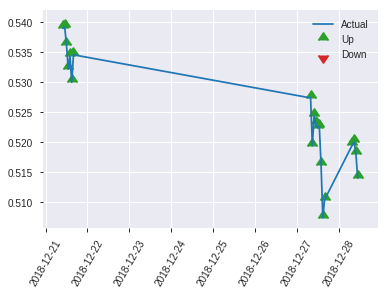


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2476387718114398
RMSE: 0.49763316992684464
LogLoss: 0.6884252297759916
Mean Per-Class Error: 0.4115925058548009
AUC: 0.5869856139176982
pr_auc: 0.5125865166946814
Gini: 0.17397122783539642
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48303721133449656: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    116  0.9508   (116.0/122.0)
1      0    98   0        (0.0/98.0)
Total  6    214  0.5273   (116.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483037     0.628205  213
max f2                       0.483037     0.808581  213
max f0point5                 0.488204     0.542553  92
max accuracy                 0.494375     0.613636  56
max precision                0.566201     1         0
max recall                   0.483037     1         213
max specificity              0.566201     1         0
max absolute_mcc             0.494375     0.200577  56
max min_per_class_accuracy   0.487454     0.571429  105
max mean_per_class_accuracy  0.494375     0.588407  56

Gains/Lift Table: Avg response rate: 44.55 %, avg score: 49.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.553837           0.748299  0.748299           0.333333         0.559914  0.333333                    0.559914            0.0102041       0.0102041                  -25.1701  -25.1701
    2        0.0227273                   0.548928           0         0.44898            0                0.550984  0.2                         0.556342            0               0.0102041                  -100      -55.102
    3        0.0318182                   0.541734           2.2449    0.962099           1                0.545812  0.428571                    0.553334            0.0204082       0.0306122                  124.49    -3.79009
    4        0.0409091                   0.532752           1.12245   0.997732           0.5              0.537846  0.444444                    0.549892            0.0102041       0.0408163                  12.2449   -0.226757
    5        0.05                        0.530358           2.2449    1.22449            1                0.53143   0.545455                    0.546535            0.0204082       0.0612245                  124.49    22.449
    6        0.1                         0.508998           1.63265   1.42857            0.727273         0.523542  0.636364                    0.535039            0.0816327       0.142857                   63.2653   42.8571
    7        0.15                        0.500656           1.02041   1.29252            0.454545         0.505524  0.575758                    0.525201            0.0510204       0.193878                   2.04082   29.2517
    8        0.2                         0.496955           1.22449   1.27551            0.545455         0.499134  0.568182                    0.518684            0.0612245       0.255102                   22.449    27.551
    9        0.3                         0.492125           1.12245   1.22449            0.5              0.494821  0.545455                    0.51073             0.112245        0.367347                   12.2449   22.449
    10       0.4                         0.48877            1.12245   1.19898            0.5              0.490587  0.534091                    0.505694            0.112245        0.479592                   12.2449   19.898
    11       0.5                         0.487316           0.918367  1.14286            0.409091         0.487901  0.509091                    0.502135            0.0918367       0.571429                   -8.16327  14.2857
    12       0.6                         0.486083           0.816327  1.08844            0.363636         0.486492  0.484848                    0.499528            0.0816327       0.653061                   -18.3673  8.84354
    13       0.7                         0.485164           0.918367  1.06414            0.409091         0.485692  0.474026                    0.497551            0.0918367       0.744898                   -8.16327  6.41399
    14       0.8                         0.484525           0.816327  1.03316            0.363636         0.484826  0.460227                    0.495961            0.0816327       0.826531                   -18.3673  3.31633
    15       0.9                         0.484012           0.816327  1.00907            0.363636         0.484241  0.449495                    0.494659            0.0816327       0.908163                   -18.3673  0.907029
    16       1                           0.482447           0.918367  1                  0.409091         0.483435  0.445455                    0.493536        

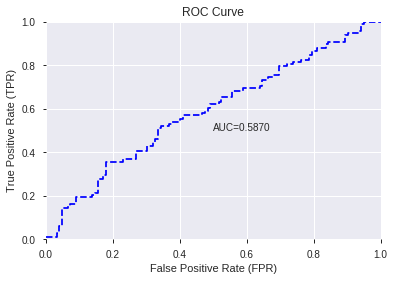

This function is available for GLM models only


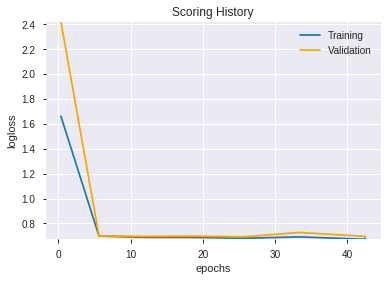

--2019-08-28 16:59:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.115.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.115.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_163937_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_163937_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b253',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_165956_model_7  0.544078  0.870589              0.483607  0.550391  0.302931
1  DeepLearning_grid_1_AutoML_20190828_165956_model_8  0.540147  0.689476              0.489712  0.498162  0.248165
2  DeepLearning_grid_1_AutoML_20190828_165956_model_1  0.537554  1.168198              0.500000  0.573256  0.328623
3  DeepLearning_grid_1_AutoML_20190828_165956_model_9  0.519112  0.690842              0.500000  0.498848  0.248849
4               DeepLearning_1_AutoML_20190828_165956  0.511626  0.749183              0.483607  0.524088  0.274668
5  DeepLearning_grid_1_AutoML_20190828_165956_model_5  0.509702  0.729641              0.495902  0.516742  0.267023
6  DeepLearning_grid_1_AutoML_20190828_165956_model_6  0.501338  0.696212              0.500000  0.501349  0.251350
7  DeepLearning_grid_1_AutoML_20190828_165956_model_4  0.499665  1.229158              0.463031  0.616243  0.379756
8  DeepLearning_grid_1_AutoML_20190828_165956_model_2  0.496487  1.111730              0.487705  0.594344  0.353245
9  DeepLearning_grid_1_AutoML_20190828_165956_model_3  0.490130  0.895530              0.491803  0.561476  0.315255

variable  relative_importance  scaled_importance  percentage
0      STOCHRSI_fastd             1.000000           1.000000    0.021044
1        HT_TRENDMODE             0.994525           0.994525    0.020929
2             BETA_12             0.985469           0.985469    0.020738
3       days_in_month             0.983230           0.983230    0.020691
4        aroondown_14             0.979400           0.979400    0.020611
5        aroondown_24             0.975227           0.975227    0.020523
6      CDLRICKSHAWMAN             0.974682           0.974682    0.020511
7              TRANGE             0.974461           0.974461    0.020507
8                 day             0.974229           0.974229    0.020502
9             BETA_14             0.974207           0.974207    0.020501
10        aroondown_8             0.972228           0.972228    0.020460
11        HT_DCPERIOD             0.969017           0.969017    0.020392
12             SAREXT             0.966816           0.966816    0.020346
13            CDLDOJI             0.965255           0.965255    0.020313
14               hour             0.964938           0.964938    0.020306
15          CORREL_14             0.961774           0.961774    0.020240
16         aroonup_12             0.960808           0.960808    0.020219
17     STOCHRSI_fastk             0.958787           0.958787    0.020177
18              DX_12             0.958546           0.958546    0.020172
19              VAR_8             0.956944           0.956944    0.020138
20          dayofweek             0.956768           0.956768    0.020134
21              CCI_8             0.956378           0.956378    0.020126
22          aroonup_8             0.955813           0.955813    0.020114
23        STOCH_slowk             0.954705           0.954705    0.020091
24       aroondown_12             0.952709           0.952709    0.020049
25              DX_14             0.950138           0.950138    0.019995
26            NATR_20             0.949594           0.949594    0.019983
27       STOCHF_fastk             0.947980           0.947980    0.019950
28                DIV             0.947260           0.947260    0.019934
29              MFI_8             0.945450           0.945450    0.019896
30               DX_8             0.945329           0.945329    0.019894
31                BOP             0.945163           0.945163    0.019890
32           WILLR_20             0.942035           0.942035    0.019824
33            ADXR_12             0.942022           0.942022    0.019824
34        AROONOSC_12             0.941378           0.941378    0.019811
35       STOCHF_fastd             0.941283           0.941283    0.019809
36         AROONOSC_8             0.940964           0.940964    0.019802
37            WILLR_8             0.936355           0.936355    0.019705
38           CORREL_8             0.934582           0.934582    0.019668
39        STOCH_slowd             0.933108           0.933108    0.019637
40             ADX_24             0.930684           0.930684    0.019586
41    MACDFIX_hist_14             0.927870           0.927870    0.019526
42              DX_24             0.925707           0.925707    0.019481
43             ADXR_8             0.924671           0.924671    0.019459
44                SUB             0.922812           0.922812    0.019420
45             ADX_20             0.918351           0.918351    0.019326
46              ADX_8             0.909154           0.909154    0.019132
47  CDLLONGLEGGEDDOJI             0.904545           0.904545    0.019035
48          CORREL_12             0.893869           0.893869    0.018811
49          MACD_hist             0.891738           0.891738    0.018766

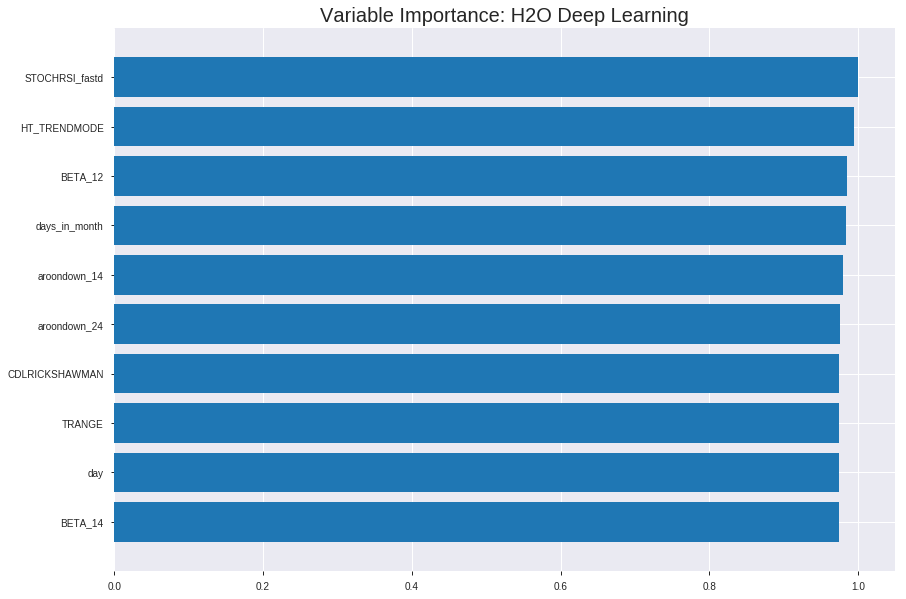

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_165956_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.32785947713890784
RMSE: 0.57259014760901
LogLoss: 0.9686148786358727
Mean Per-Class Error: 0.4683680683007736
AUC: 0.5250570985766141
pr_auc: 0.5102198794668463
Gini: 0.05011419715322818
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.006186964791770167: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    792   1        (792.0/792.0)
1      0    743   0        (0.0/743.0)
Total  0    1535  0.516    (792.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00618696   0.652327   399
max f2                       0.00618696   0.824273   399
max f0point5                 0.00618696   0.539736   399
max accuracy                 0.302444     0.530945   249
max precision                0.916893     0.72       11
max recall                   0.00618696   1          399
max specificity              0.970746     0.998737   0
max absolute_mcc             0.302444     0.0632849  249
max min_per_class_accuracy   0.323497     0.520202   239
max mean_per_class_accuracy  0.302444     0.531632   249

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 38.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0104235                   0.928583           1.29122   1.29122            0.625            0.946392   0.625                       0.946392            0.013459        0.013459                   29.1218     29.1218
    2        0.0201954                   0.911056           1.51503   1.39951            0.733333         0.91793    0.677419                    0.93262             0.0148048       0.0282638                  51.5029     39.9514
    3        0.0306189                   0.893529           0.903853  1.23078            0.4375           0.900716   0.595745                    0.921759            0.00942127      0.0376851                  -9.61474    23.0778
    4        0.0403909                   0.885383           0.964109  1.16626            0.466667         0.890066   0.564516                    0.914091            0.00942127      0.0471063                  -3.58905    16.6261
    5        0.0501629                   0.871786           1.3773    1.20737            0.666667         0.879397   0.584416                    0.907332            0.013459        0.0605653                  37.7299     20.7373
    6        0.100326                    0.815098           0.992729  1.10005            0.480519         0.840882   0.532468                    0.874107            0.0497981       0.110363                   -0.727133   10.0051
    7        0.150489                    0.758013           1.04639   1.08216            0.506494         0.785927   0.52381                     0.844714            0.0524899       0.162853                   4.63897     8.21637
    8        0.2                         0.707876           1.06016   1.07672            0.513158         0.733999   0.521173                    0.817306            0.0524899       0.215343                   6.0158      7.6716
    9        0.300326                    0.577633           1.0598    1.07107            0.512987         0.645536   0.518438                    0.759925            0.106326        0.321669                   5.98049     7.10668
    10       0.4                         0.445699           0.918199  1.03297            0.444444         0.512414   0.5                         0.698249            0.0915209       0.41319                    -8.18005    3.29744
    11       0.500326                    0.32291            1.08664   1.04373            0.525974         0.383279   0.505208                    0.635091            0.109017        0.522207                   8.66354     4.37346
    12       0.6                         0.229438           0.918199  1.02288            0.444444         0.272068   0.495114                    0.574784            0.0915209       0.613728                   -8.18005    2.28802
    13       0.699674                    0.152091           0.999217  1.01951            0.48366          0.190217   0.493482                    0.519999            0.0995962       0.713324                   -0.0782906  1.95092
    14       0.8                         0.0934527          0.885407  1.00269            0.428571         0.119715   0.485342                    0.469801            0.0888291       0.802153                   -11.4593    0.269179
    15       0.899674                    0.0505176          1.05323   1.00829            0.509804         0.071536   0.488052                    0.425677            0.10498         0.907133                   5.32288     0.829075
    16       1                           0.00552539         0.925652  1                  0.448052         0.0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.32893130107260854
RMSE: 0.5735253273157241
LogLoss: 0.9590890784679562
Mean Per-Class Error: 0.4632550860719875
AUC: 0.5218153364632238
pr_auc: 0.5210567440861974
Gini: 0.04363067292644751
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.019790373157674564: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    210  0.9859   (210.0/213.0)
1      1    224  0.0044   (1.0/225.0)
Total  4    434  0.4817   (211.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0197904    0.679818   395
max f2                       0.0163819    0.841436   398
max f0point5                 0.0197904    0.571137   395
max accuracy                 0.494784     0.53653    197
max precision                0.933229     0.75       2
max recall                   0.0163819    1          398
max specificity              0.943986     0.995305   0
max absolute_mcc             0.494784     0.0734691  197
max min_per_class_accuracy   0.494784     0.528889   197
max mean_per_class_accuracy  0.494784     0.536745   197

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 48.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.932568           1.168     1.168              0.6              0.937223   0.6                         0.937223            0.0133333       0.0133333                  16.8       16.8
    2        0.0205479                   0.924771           0.486667  0.865185           0.25             0.92915    0.444444                    0.933635            0.00444444      0.0177778                  -51.3333   -13.4815
    3        0.0319635                   0.913326           0.778667  0.834286           0.4              0.917076   0.428571                    0.927721            0.00888889      0.0266667                  -22.1333   -16.5714
    4        0.0410959                   0.906338           1.46      0.973333           0.75             0.909585   0.5                         0.923691            0.0133333       0.04                       46         -2.66667
    5        0.0502283                   0.899804           0.973333  0.973333           0.5              0.903607   0.5                         0.920039            0.00888889      0.0488889                  -2.66667   -2.66667
    6        0.100457                    0.877169           0.884848  0.929091           0.454545         0.890703   0.477273                    0.905371            0.0444444       0.0933333                  -11.5152   -7.09091
    7        0.150685                    0.849871           0.973333  0.943838           0.5              0.865684   0.484848                    0.892142            0.0488889       0.142222                   -2.66667   -5.61616
    8        0.200913                    0.811773           0.973333  0.951212           0.5              0.829453   0.488636                    0.87647             0.0488889       0.191111                   -2.66667   -4.87879
    9        0.30137                     0.752256           1.23879   1.04707            0.636364         0.785975   0.537879                    0.846305            0.124444        0.315556                   23.8788    4.70707
    10       0.399543                    0.623979           1.13178   1.06789            0.581395         0.684144   0.548571                    0.80646             0.111111        0.426667                   13.1783    6.78857
    11       0.5                         0.488293           1.01758   1.05778            0.522727         0.553722   0.543379                    0.755681            0.102222        0.528889                   1.75758    5.77778
    12       0.600457                    0.37651            0.796364  1.01404            0.409091         0.430858   0.520913                    0.701338            0.08            0.608889                   -20.3636   1.40431
    13       0.69863                     0.258784           0.995969  1.0115             0.511628         0.313562   0.519608                    0.646847            0.0977778       0.706667                   -0.403101  1.15033
    14       0.799087                    0.143798           1.10606   1.02339            0.568182         0.204855   0.525714                    0.591282            0.111111        0.817778                   10.6061    2.33905
    15       0.899543                    0.0666379          0.884848  1.00792            0.454545         0.10037    0.517766                    0.536459            0.0888889       0.906667                   -11.5152   0.791878
    16       1                           0.0145085          0.929091  1                  0.477273         0.0406554  0.513


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:04:02  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 17:04:06  5.267 sec   219 obs/sec       0.620195  1             952        0.57259          0.968615            -0.312776      0.525057        0.51022            1.29122          0.515961                         0.573525           0.959089              -0.316714        0.521815          0.521057             1.168              0.481735
    2019-08-28 17:04:16  14.823 sec  433 obs/sec       3.6684    6             5631       0.572326         0.90439             -0.311563      0.651484        0.6449             2.06595          0.460586                         0.606293           1.02881               -0.471471        0.480428          0.504604             0.778667           0.477169
    2019-08-28 17:04:26  24.675 sec  514 obs/sec       7.3544    12            11289      0.48145          0.663535            0.0718764      0.714277        0.712462           2.06595          0.405863                         0.585499           1.03885               -0.372265        0.50023           0.515222             0.778667           0.486301
    2019-08-28 17:04:37  36.100 sec  523 obs/sec       11.0684   18            16990      0.43008          0.541063            0.25937        0.799672        0.778086           2.06595          0.302932                         0.580866           1.08064               -0.350635        0.492175          0.505318             0.778667           0.486301
    2019-08-28 17:04:47  45.706 sec  548 obs/sec       14.7251   24            22603      0.43456          0.550808            0.24386        0.852947        0.836894           2.06595          0.238436                         0.597591           1.28812               -0.429532        0.510454          0.517645             0.778667           0.486301
    2019-08-28 17:04:56  55.292 sec  566 obs/sec       18.398    30            28241      0.378034         0.432622            0.427779       0.878219        0.84088            2.06595          0.209121                         0.593216           1.30224               -0.408676        0.508701          0.518963             1.94667            0.477169
    2019-08-28 17:04:57  56.238 sec  565 obs/sec       18.398    30            28241      0.57259          0.968615            -0.312776      0.525057        0.51022            1.29122          0.515961                         0.573525           0.959089              -0.316714        0.521815          0.521057             1.168              0.481735

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
STOCHRSI_fastd     1.0                    1.0                  0.021044231581771416
HT_TRENDMODE       0.9945250153541565     0.9945250153541565   0.02092901473697764
BETA_12            0.9854692816734314     0.9854692816734314   0.020738443780257614
days_in_month      0.9832295775413513     0.9832295775413513   0.020691310927827472
aroondown_14       0.9793996214866638     0.9793996214866638   0.02061071244566462
---                ---                    ---                  ---
ADX_20             0.9183510541915894     0.9183510541915894   0.019325992257771717
ADX_8              0.90915447473526       0.90915447473526     0.01913245730993256
CDLLONGLEGGEDDOJI  0.9045450687408447     0.9045450687408447   0.01903545590273168
CORREL_12          0.893868625164032      0.893868625164032    0.018810778351631516
MACD_hist          0.891737699508667      0.891737699508667    0.018765934658656478


See the whole table with table.as_data_frame()


('accuracy', 0.5772727272727273)

('F1', 0.6242038216560509)

('auc', 0.5440782870525259)

('logloss', 0.8705886782060545)

('mean_per_class_error', 0.4520742723318836)

('rmse', 0.5503914619380257)

('mse', 0.30293076137427716)

deeplearning prediction progress: |███████████████████████████████████████| 100%


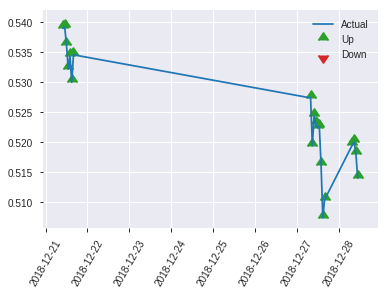


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.30293076137427716
RMSE: 0.5503914619380257
LogLoss: 0.8705886782060545
Mean Per-Class Error: 0.4520742723318836
AUC: 0.5440782870525259
pr_auc: 0.49540446122639653
Gini: 0.08815657410505184
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.03183639690928156: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    118  0.9672   (118.0/122.0)
1      0    98   0        (0.0/98.0)
Total  4    216  0.5364   (118.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0318364    0.624204  215
max f2                       0.0318364    0.805921  215
max f0point5                 0.0523935    0.512959  206
max accuracy                 0.872065     0.577273  10
max precision                0.890624     0.8       4
max recall                   0.0318364    1         215
max specificity              0.932218     0.991803  0
max absolute_mcc             0.872065     0.130083  10
max min_per_class_accuracy   0.279246     0.52459   109
max mean_per_class_accuracy  0.241565     0.547926  122

Gains/Lift Table: Avg response rate: 44.55 %, avg score: 35.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.895319           1.4966    1.4966             0.666667         0.908167   0.666667                    0.908167            0.0204082       0.0204082                  49.6599   49.6599
    2        0.0227273                   0.890175           2.2449    1.79592            1                0.892603   0.8                         0.901941            0.0204082       0.0408163                  124.49    79.5918
    3        0.0318182                   0.88388            1.12245   1.6035             0.5              0.888129   0.714286                    0.897995            0.0102041       0.0510204                  12.2449   60.3499
    4        0.0409091                   0.874072           1.12245   1.4966             0.5              0.879987   0.666667                    0.893993            0.0102041       0.0612245                  12.2449   49.6599
    5        0.05                        0.869572           2.2449    1.63265            1                0.8724     0.727273                    0.890067            0.0204082       0.0816327                  124.49    63.2653
    6        0.1                         0.786606           0.612245  1.12245            0.272727         0.835925   0.5                         0.862996            0.0306122       0.112245                   -38.7755  12.2449
    7        0.15                        0.721892           1.42857   1.22449            0.636364         0.755845   0.545455                    0.827279            0.0714286       0.183673                   42.8571   22.449
    8        0.2                         0.678389           1.02041   1.17347            0.454545         0.700367   0.522727                    0.795551            0.0510204       0.234694                   2.04082   17.3469
    9        0.3                         0.419583           0.918367  1.08844            0.409091         0.539435   0.484848                    0.710179            0.0918367       0.326531                   -8.16327  8.84354
    10       0.4                         0.336691           0.918367  1.04592            0.409091         0.373048   0.465909                    0.625896            0.0918367       0.418367                   -8.16327  4.59184
    11       0.5                         0.273787           1.12245   1.06122            0.5              0.299301   0.472727                    0.560577            0.112245        0.530612                   12.2449   6.12245
    12       0.6                         0.222923           0.918367  1.03741            0.409091         0.247722   0.462121                    0.508435            0.0918367       0.622449                   -8.16327  3.7415
    13       0.7                         0.180353           1.12245   1.04956            0.5              0.200098   0.467532                    0.464387            0.112245        0.734694                   12.2449   4.95627
    14       0.8                         0.110235           0.816327  1.02041            0.363636         0.146027   0.454545                    0.424592            0.0816327       0.816327                   -18.3673  2.04082
    15       0.9                         0.0647436          0.816327  0.997732           0.363636         0.085411   0.444444                    0.386905            0.0816327       0.897959                   -18.3673  -0.226757
    16       1                           0.0178522          1.02041   1                  0.454545         0.0456976  0.445455                   

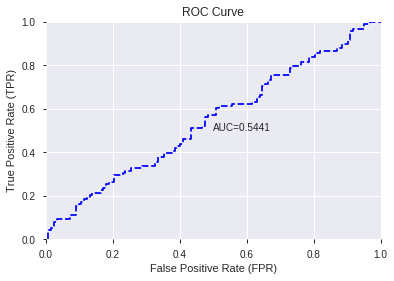

This function is available for GLM models only


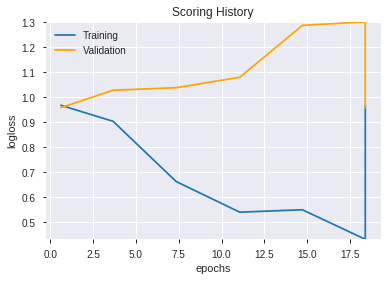

--2019-08-28 17:06:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.116
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.116|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_165956_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_165956_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b253',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['STOCHRSI_fastd',
 'HT_TRENDMODE',
 'BETA_12',
 'days_in_month',
 'aroondown_14',
 'aroondown_24',
 'CDLRICKSHAWMAN',
 'TRANGE',
 'day',
 'BETA_14',
 'aroondown_8',
 'HT_DCPERIOD',
 'SAREXT',
 'CDLDOJI',
 'hour',
 'CORREL_14',
 'aroonup_12',
 'STOCHRSI_fastk',
 'DX_12',
 'VAR_8',
 'dayofweek',
 'CCI_8',
 'aroonup_8',
 'STOCH_slowk',
 'aroondown_12',
 'DX_14',
 'NATR_20',
 'STOCHF_fastk',
 'DIV',
 'MFI_8',
 'DX_8',
 'BOP',
 'WILLR_20',
 'ADXR_12',
 'AROONOSC_12',
 'STOCHF_fastd',
 'AROONOSC_8',
 'WILLR_8',
 'CORREL_8',
 'STOCH_slowd',
 'ADX_24',
 'MACDFIX_hist_14',
 'DX_24',
 'ADXR_8',
 'SUB',
 'ADX_20',
 'ADX_8',
 'CDLLONGLEGGEDDOJI',
 'CORREL_12',
 'MACD_hist']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190828_170703_model_1  0.518234  0.690825              0.491803  0.498838  0.24884

variable  relative_importance  scaled_importance  percentage
0        aroondown_24             0.014620           1.000000    0.048361
1       days_in_month             0.014489           0.991073    0.047929
2      CDLRICKSHAWMAN             0.014189           0.970523    0.046935
3     MACDFIX_hist_14             0.013493           0.922908    0.044633
4   CDLLONGLEGGEDDOJI             0.011650           0.796839    0.038536
5         aroondown_8             0.011372           0.777869    0.037619
6             CDLDOJI             0.011056           0.756257    0.036573
7                DX_8             0.010813           0.739590    0.035767
8               DX_12             0.010369           0.709264    0.034301
9               ADX_8             0.010320           0.705865    0.034136
10          MACD_hist             0.010275           0.702799    0.033988
11          CORREL_14             0.009785           0.669331    0.032370
12       aroondown_14             0.009327           0.637983    0.030854
13              DX_14             0.009277           0.634544    0.030687
14          CORREL_12             0.009270           0.634072    0.030664
15              MFI_8             0.008987           0.614748    0.029730
16                SUB             0.008802           0.602035    0.029115
17       aroondown_12             0.008382           0.573370    0.027729
18                DIV             0.007515           0.514037    0.024859
19             ADXR_8             0.007163           0.489958    0.023695
20           CORREL_8             0.006904           0.472261    0.022839
21        AROONOSC_12             0.006638           0.454031    0.021957
22              VAR_8             0.006255           0.427859    0.020692
23       HT_TRENDMODE             0.006060           0.414508    0.020046
24             TRANGE             0.005772           0.394793    0.019093
25         AROONOSC_8             0.005515           0.377265    0.018245
26              DX_24             0.005447           0.372595    0.018019
27        STOCH_slowd             0.004829           0.330302    0.015974
28              CCI_8             0.004753           0.325131    0.015724
29            BETA_12             0.003831           0.262064    0.012674
30             SAREXT             0.003639           0.248937    0.012039
31         aroonup_12             0.003181           0.217553    0.010521
32            NATR_20             0.003178           0.217349    0.010511
33           WILLR_20             0.003025           0.206892    0.010006
34     STOCHRSI_fastk             0.002529           0.172971    0.008365
35            ADXR_12             0.002342           0.160164    0.007746
36       STOCHF_fastd             0.002060           0.140888    0.006813
37        STOCH_slowk             0.002040           0.139541    0.006748
38          aroonup_8             0.002022           0.138338    0.006690
39                BOP             0.001937           0.132498    0.006408
40          dayofweek             0.001816           0.124207    0.006007
41                day             0.001490           0.101939    0.004930
42       STOCHF_fastk             0.001417           0.096899    0.004686
43     STOCHRSI_fastd             0.001315           0.089971    0.004351
44        HT_DCPERIOD             0.001204           0.082370    0.003983
45            BETA_14             0.000626           0.042796    0.002070
46             ADX_20             0.000573           0.039163    0.001894
47            WILLR_8             0.000371           0.025385    0.001228
48               hour             0.000239           0.016336    0.000790
49             ADX_24             0.000142           0.009732    0.000471

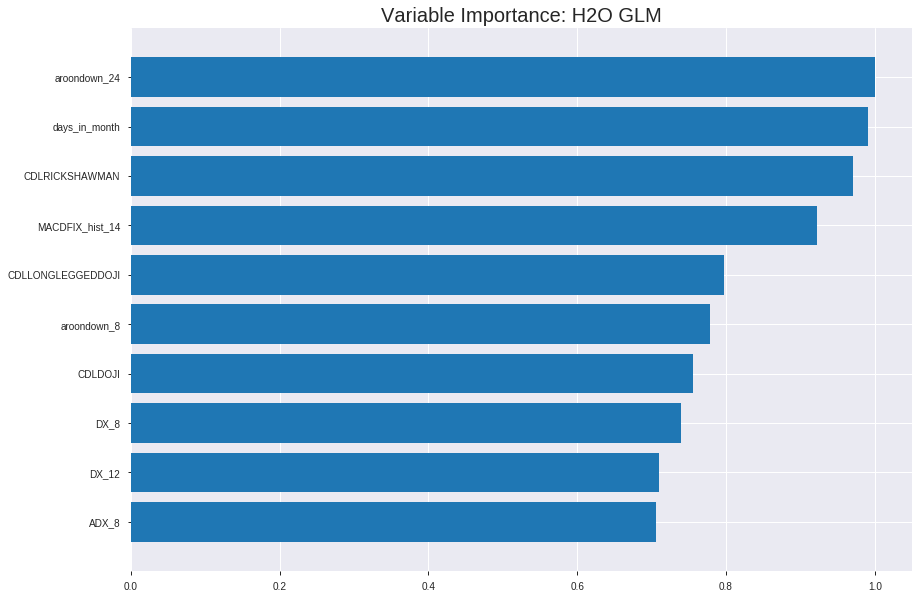

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_170703_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2469299753174397
RMSE: 0.49692049194759486
LogLoss: 0.6869931156472998
Null degrees of freedom: 1534
Residual degrees of freedom: 1484
Null deviance: 2126.397409180741
Residual deviance: 2109.0688650372103
AIC: 2211.0688650372103
AUC: 0.5734659855622171
pr_auc: 0.5461195254086784
Gini: 0.14693197112443412
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42806670253995993: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    787   0.9937   (787.0/792.0)
1      0    743   0        (0.0/743.0)
Total  5    1530  0.5127   (787.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428067     0.653762  394
max f2                       0.428067     0.825189  394
max f0point5                 0.477139     0.550943  234
max accuracy                 0.49143      0.570684  178
max precision                0.587503     1         0
max recall                   0.428067     1         394
max specificity              0.587503     1         0
max absolute_mcc             0.49143      0.138245  178
max min_per_class_accuracy   0.479109     0.561238  226
max mean_per_class_accuracy  0.488775     0.566388  189

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 48.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.561609           1.29122   1.29122            0.625            0.569696  0.625                       0.569696            0.013459        0.013459                   29.1218   29.1218
    2        0.0201954                   0.552738           1.10184   1.19958            0.533333         0.557391  0.580645                    0.563742            0.0107672       0.0242261                  10.1839   19.9583
    3        0.0306189                   0.544051           1.54946   1.31869            0.75             0.548436  0.638298                    0.558531            0.0161507       0.0403769                  54.9462   31.8691
    4        0.0403909                   0.538986           1.23957   1.29955            0.6              0.541278  0.629032                    0.554357            0.0121131       0.0524899                  23.9569   29.9548
    5        0.0501629                   0.534506           1.10184   1.26103            0.533333         0.536118  0.61039                     0.550804            0.0107672       0.0632571                  10.1839   26.1034
    6        0.100326                    0.525639           1.2342    1.24762            0.597403         0.529928  0.603896                    0.540366            0.0619112       0.125168                   23.4203   24.7618
    7        0.150489                    0.516295           1.20737   1.2342             0.584416         0.521195  0.597403                    0.533976            0.0605653       0.185734                   20.7373   23.4203
    8        0.2                         0.508463           1.00579   1.17766            0.486842         0.512945  0.570033                    0.52877             0.0497981       0.235532                   0.579089  17.7658
    9        0.300326                    0.496088           1.20737   1.18758            0.584416         0.502056  0.574837                    0.519846            0.121131        0.356662                   20.7373   18.7584
    10       0.4                         0.48696            1.05323   1.1541             0.509804         0.491347  0.558632                    0.512744            0.10498         0.461642                   5.32288   15.4105
    11       0.500326                    0.478839           1.01956   1.12713            0.493506         0.482692  0.545573                    0.506718            0.102288        0.56393                    1.95592   12.7126
    12       0.6                         0.471946           0.837182  1.07896            0.405229         0.475367  0.522258                    0.50151             0.0834455       0.647376                   -16.2818  7.89592
    13       0.699674                    0.465782           0.877691  1.05029            0.424837         0.468778  0.50838                     0.496847            0.0874832       0.734859                   -12.2309  5.02868
    14       0.8                         0.459751           0.939068  1.03634            0.454545         0.463067  0.501629                    0.492611            0.0942127       0.829071                   -6.09323  3.63392
    15       0.899674                    0.451844           0.877691  1.01876            0.424837         0.45631   0.493121                    0.488589            0.0874832       0.916555                   -12.2309  1.87626
    16       1                           0.418959           0.831746  1                  0.402597         0.443239  0.484039                    0.484039         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25021130566188265
RMSE: 0.5002112610306596
LogLoss: 0.6935571334556075
Null degrees of freedom: 437
Residual degrees of freedom: 387
Null deviance: 608.4098651427188
Residual deviance: 607.5560489071121
AIC: 709.5560489071121
AUC: 0.5189358372456964
pr_auc: 0.5257799893465703
Gini: 0.037871674491392726
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4386210817875129: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    207  0.9718   (207.0/213.0)
1      0    225  0        (0.0/225.0)
Total  6    432  0.4726   (207.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438621     0.684932  393
max f2                       0.438621     0.844595  393
max f0point5                 0.45267      0.577245  359
max accuracy                 0.45267      0.53653   359
max precision                0.586519     1         0
max recall                   0.438621     1         393
max specificity              0.586519     1         0
max absolute_mcc             0.438621     0.121125  393
max min_per_class_accuracy   0.483299     0.502347  201
max mean_per_class_accuracy  0.476079     0.531518  240

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 48.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.555076           1.168     1.168              0.6              0.569449  0.6                         0.569449            0.0133333       0.0133333                  16.8      16.8
    2        0.0205479                   0.545356           0.973333  1.08148            0.5              0.549595  0.555556                    0.560625            0.00888889      0.0222222                  -2.66667  8.14815
    3        0.0319635                   0.540164           1.55733   1.25143            0.8              0.54214   0.642857                    0.554023            0.0177778       0.04                       55.7333   25.1429
    4        0.0410959                   0.538267           0.973333  1.18963            0.5              0.539479  0.611111                    0.550791            0.00888889      0.0488889                  -2.66667  18.963
    5        0.0502283                   0.535235           0.486667  1.06182            0.25             0.536507  0.545455                    0.548194            0.00444444      0.0533333                  -51.3333  6.18182
    6        0.100457                    0.526748           1.06182   1.06182            0.545455         0.531006  0.545455                    0.5396              0.0533333       0.106667                   6.18182   6.18182
    7        0.150685                    0.517033           0.884848  1.00283            0.454545         0.52188   0.515152                    0.533693            0.0444444       0.151111                   -11.5152  0.282828
    8        0.200913                    0.512112           0.796364  0.951212           0.409091         0.51437   0.488636                    0.528863            0.04            0.191111                   -20.3636  -4.87879
    9        0.30137                     0.501709           1.01758   0.973333           0.522727         0.506395  0.5                         0.521373            0.102222        0.293333                   1.75758   -2.66667
    10       0.399543                    0.49092            1.22233   1.03451            0.627907         0.495331  0.531429                    0.514974            0.12            0.413333                   22.2326   3.45143
    11       0.5                         0.483441           0.884848  1.00444            0.454545         0.487405  0.515982                    0.509435            0.0888889       0.502222                   -11.5152  0.444444
    12       0.600457                    0.476049           1.28303   1.05105            0.659091         0.479484  0.539924                    0.504424            0.128889        0.631111                   28.303    5.1052
    13       0.69863                     0.469201           0.905426  1.03059            0.465116         0.47261   0.529412                    0.499954            0.0888889       0.72                       -9.45736  3.05882
    14       0.799087                    0.461257           0.973333  1.02339            0.5              0.466076  0.525714                    0.495695            0.0977778       0.817778                   -2.66667  2.33905
    15       0.899543                    0.452449           1.01758   1.02274            0.522727         0.456844  0.525381                    0.491356            0.102222        0.92                       1.75758   2.27411
    16       1                           0.393616           0.796364  1                  0.409091         0.445681  0.513699                    0.486768          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 17:07:03  0.000 sec   2            3.8       51            1.37845           1.38738
    2019-08-28 17:07:03  0.013 sec   4            2.4       51            1.37631           1.38713
    2019-08-28 17:07:03  0.025 sec   6            1.5       51            1.37399           1.38711
    2019-08-28 17:07:03  0.038 sec   8            0.91      51            1.37157           1.38745
    2019-08-28 17:07:03  0.051 sec   10           0.57      51            1.36915           1.3882
    2019-08-28 17:07:03  0.063 sec   12           0.35      51            1.36676           1.38932
    2019-08-28 17:07:03  0.075 sec   14           0.22      51            1.36447           1.39079
    2019-08-28 17:07:03  0.089 sec   16           0.14      51            1.36236           1.39266

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5772727272727273)

('F1', 0.6202531645569621)

('auc', 0.5182335229173637)

('logloss', 0.6908251227476366)

('mean_per_class_error', 0.46244563399130145)

('rmse', 0.49883834652520465)

('mse', 0.24883969596400013)

glm prediction progress: |████████████████████████████████████████████████| 100%


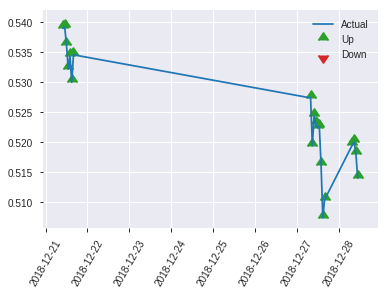


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24883969596400013
RMSE: 0.49883834652520465
LogLoss: 0.6908251227476366
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 303.6762860419698
Residual deviance: 303.9630540089601
AIC: 405.9630540089601
AUC: 0.5182335229173637
pr_auc: 0.4785145603222634
Gini: 0.036467045834727374
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44013384964869445: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    120  0.9836   (120.0/122.0)
1      0    98   0        (0.0/98.0)
Total  2    218  0.5455   (120.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440134     0.620253  217
max f2                       0.440134     0.803279  217
max f0point5                 0.467689     0.508906  171
max accuracy                 0.524485     0.577273  28
max precision                0.552519     0.75      3
max recall                   0.440134     1         217
max specificity              0.574378     0.991803  0
max absolute_mcc             0.543293     0.119031  7
max min_per_class_accuracy   0.489806     0.491803  110
max mean_per_class_accuracy  0.524485     0.537554  28

Gains/Lift Table: Avg response rate: 44.55 %, avg score: 49.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.5558             1.4966    1.4966             0.666667         0.564167  0.666667                    0.564167            0.0204082       0.0204082                  49.6599   49.6599
    2        0.0227273                   0.547243           1.12245   1.34694            0.5              0.550302  0.6                         0.558621            0.0102041       0.0306122                  12.2449   34.6939
    3        0.0318182                   0.544218           2.2449    1.6035             1                0.545657  0.714286                    0.554917            0.0204082       0.0510204                  124.49    60.3499
    4        0.0409091                   0.542893           1.12245   1.4966             0.5              0.543275  0.666667                    0.55233             0.0102041       0.0612245                  12.2449   49.6599
    5        0.05                        0.53974            1.12245   1.42857            0.5              0.541855  0.636364                    0.550425            0.0102041       0.0714286                  12.2449   42.8571
    6        0.1                         0.532171           1.02041   1.22449            0.454545         0.537575  0.545455                    0.544               0.0510204       0.122449                   2.04082   22.449
    7        0.15                        0.520204           1.22449   1.22449            0.545455         0.526411  0.545455                    0.538137            0.0612245       0.183673                   22.449    22.449
    8        0.2                         0.513702           0.408163  1.02041            0.181818         0.517832  0.454545                    0.533061            0.0204082       0.204082                   -59.1837  2.04082
    9        0.3                         0.502471           1.12245   1.05442            0.5              0.508295  0.469697                    0.524805            0.112245        0.316327                   12.2449   5.44218
    10       0.4                         0.494756           1.02041   1.04592            0.454545         0.49816   0.465909                    0.518144            0.102041        0.418367                   2.04082   4.59184
    11       0.5                         0.490037           0.714286  0.979592           0.318182         0.491973  0.436364                    0.51291             0.0714286       0.489796                   -28.5714  -2.04082
    12       0.6                         0.480783           0.918367  0.969388           0.409091         0.48574   0.431818                    0.508382            0.0918367       0.581633                   -8.16327  -3.06122
    13       0.7                         0.47176            1.32653   1.02041            0.590909         0.475853  0.454545                    0.503735            0.132653        0.714286                   32.6531   2.04082
    14       0.8                         0.466771           1.02041   1.02041            0.454545         0.469367  0.454545                    0.499439            0.102041        0.816327                   2.04082   2.04082
    15       0.9                         0.458633           0.714286  0.986395           0.318182         0.463432  0.439394                    0.495438            0.0714286       0.887755                   -28.5714  -1.36054
    16       1                           0.435496           1.12245   1                  0.5              0.448827  0.445455                    0.490777        

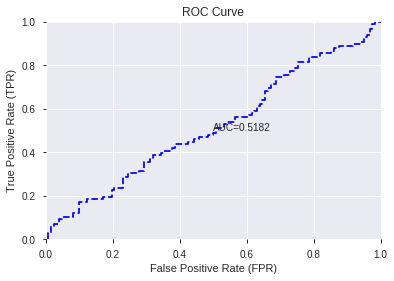

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


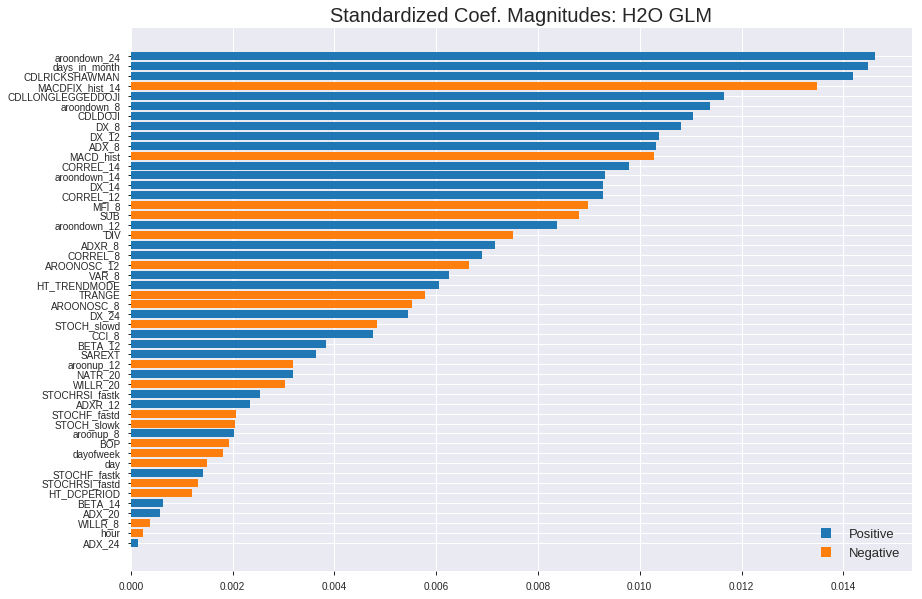

'log_likelihood'
--2019-08-28 17:07:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.81.136
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.81.136|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_170703_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_170703_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b253',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['aroondown_24',
 'days_in_month',
 'CDLRICKSHAWMAN',
 'MACDFIX_hist_14',
 'CDLLONGLEGGEDDOJI',
 'aroondown_8',
 'CDLDOJI',
 'DX_8',
 'DX_12',
 'ADX_8',
 'MACD_hist',
 'CORREL_14',
 'aroondown_14',
 'DX_14',
 'CORREL_12',
 'MFI_8',
 'SUB',
 'aroondown_12',
 'DIV',
 'ADXR_8',
 'CORREL_8',
 'AROONOSC_12',
 'VAR_8',
 'HT_TRENDMODE',
 'TRANGE',
 'AROONOSC_8',
 'DX_24',
 'STOCH_slowd',
 'CCI_8',
 'BETA_12',
 'SAREXT',
 'aroonup_12',
 'NATR_20',
 'WILLR_20',
 'STOCHRSI_fastk',
 'ADXR_12',
 'STOCHF_fastd',
 'STOCH_slowk',
 'aroonup_8',
 'BOP',
 'dayofweek',
 'day',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'HT_DCPERIOD',
 'BETA_14',
 'ADX_20',
 'WILLR_8',
 'hour',
 'ADX_24']

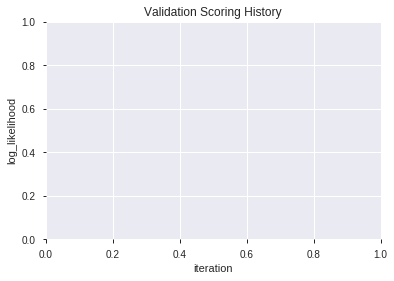

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_170718_model_1  0.547842  0.695992              0.484610  0.501275  0.251277
1  XGBoost_grid_1_AutoML_20190828_170718_model_4  0.540314  0.693450              0.491803  0.500109  0.250109
2  XGBoost_grid_1_AutoML_20190828_170718_model_2  0.528103  0.701857              0.489712  0.504134  0.254152
3               XGBoost_3_AutoML_20190828_170718  0.514804  0.710805              0.495902  0.508456  0.258528
4               XGBoost_1_AutoML_20190828_170718  0.514135  0.709555              0.483523  0.507684  0.257743
5  XGBoost_grid_1_AutoML_20190828_170718_model_3  0.509535  0.701960              0.491803  0.504251  0.254269
6  XGBoost_grid_1_AutoML_20190828_170718_model_5  0.509033  0.738992              0.480512  0.519611  0.269996
7               XGBoost_2_AutoML_20190828_170718  0.504767  0.710746              0.495902  0.508386  0.258456
8  XGBoost_grid_1_AutoML_20190828_170718_model_7  0.494731  0.728957              0.491803  0.516479  0.266750
9  XGBoost_grid_1_AutoML_20190828_170718_model_6  0.484527  0.722888              0.484610  0.514038  0.264235

variable  relative_importance  scaled_importance  percentage
0       STOCH_slowd           218.393875           1.000000    0.043228
1             ADX_8           205.598587           0.941412    0.040695
2             MFI_8           198.123276           0.907183    0.039215
3            ADX_20           197.699905           0.905245    0.039132
4            ADXR_8           181.002975           0.828791    0.035827
5       HT_DCPERIOD           178.539841           0.817513    0.035339
6   MACDFIX_hist_14           175.269135           0.802537    0.034692
7             VAR_8           167.618820           0.767507    0.033178
8           BETA_14           159.145889           0.728710    0.031500
9    STOCHRSI_fastd           157.604553           0.721653    0.031195
10              BOP           154.877335           0.709165    0.030656
11           ADX_24           151.796219           0.695057    0.030046
12          NATR_20           151.707199           0.694650    0.030028
13          BETA_12           141.740997           0.649015    0.028055
14        MACD_hist           140.560318           0.643609    0.027822
15           SAREXT           136.356079           0.624359    0.026990
16             DX_8           135.774689           0.621696    0.026874
17          ADXR_12           126.694481           0.580119    0.025077
18         WILLR_20           122.337090           0.560167    0.024215
19        CORREL_12           122.121185           0.559179    0.024172
20            DX_14           121.761986           0.557534    0.024101
21            DX_12           119.291336           0.546221    0.023612
22              DIV           110.560028           0.506241    0.021884
23      aroondown_8           107.369240           0.491631    0.021252
24          WILLR_8           102.286133           0.468356    0.020246
25              SUB            95.826721           0.438779    0.018967
26           TRANGE            92.713852           0.424526    0.018351
27        aroonup_8            90.172478           0.412889    0.017848
28     STOCHF_fastk            88.508141           0.405268    0.017519
29        CORREL_14            88.011436           0.402994    0.017420
30      AROONOSC_12            87.040573           0.398549    0.017228
31             hour            84.582077           0.387291    0.016742
32              day            76.887741           0.352060    0.015219
33            CCI_8            75.574974           0.346049    0.014959
34            DX_24            73.887955           0.338324    0.014625
35       aroonup_12            65.640228           0.300559    0.012992
36      STOCH_slowk            63.156437           0.289186    0.012501
37   STOCHRSI_fastk            47.005562           0.215233    0.009304
38       AROONOSC_8            42.827282           0.196101    0.008477
39     aroondown_24            35.101547           0.160726    0.006948
40     aroondown_14            34.593826           0.158401    0.006847
41     STOCHF_fastd            29.274776           0.134046    0.005794
42         CORREL_8            23.451857           0.107383    0.004642
43     aroondown_12            22.112301           0.101250    0.004377
44        dayofweek            17.285828           0.079150    0.003421
45   CDLRICKSHAWMAN            16.016634           0.073338    0.003170
46    days_in_month            14.437205           0.066106    0.002858
47          CDLDOJI             3.842043           0.017592    0.000760

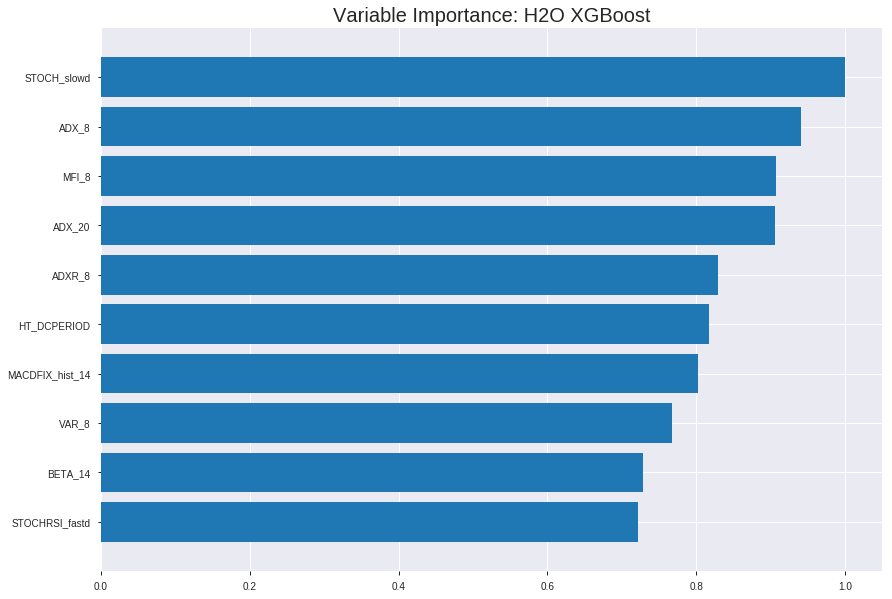

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_170718_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17211125670501884
RMSE: 0.41486293725159257
LogLoss: 0.5324747591300845
Mean Per-Class Error: 0.10721277376728255
AUC: 0.956395210517014
pr_auc: 0.9545454820987901
Gini: 0.9127904210340281
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4708865284919739: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      671  121  0.1528   (121.0/792.0)
1      46   697  0.0619   (46.0/743.0)
Total  717  818  0.1088   (167.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.470887     0.893017  208
max f2                       0.460857     0.921773  218
max f0point5                 0.514842     0.901736  171
max accuracy                 0.491881     0.891857  190
max precision                0.78685      1         0
max recall                   0.34835      1         321
max specificity              0.78685      1         0
max absolute_mcc             0.470887     0.786615  208
max min_per_class_accuracy   0.491881     0.890983  190
max mean_per_class_accuracy  0.477959     0.892787  202

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 48.53 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.71681            2.06595    2.06595            1                0.734599  1                           0.734599            0.0215343       0.0215343                  106.595   106.595
    2        0.0201954                   0.698649           2.06595    2.06595            1                0.708495  1                           0.721968            0.0201884       0.0417227                  106.595   106.595
    3        0.0306189                   0.68914            2.06595    2.06595            1                0.694218  1                           0.712521            0.0215343       0.0632571                  106.595   106.595
    4        0.0403909                   0.681601           2.06595    2.06595            1                0.684425  1                           0.705724            0.0201884       0.0834455                  106.595   106.595
    5        0.0501629                   0.67769            2.06595    2.06595            1                0.67945   1                           0.700606            0.0201884       0.103634                   106.595   106.595
    6        0.100326                    0.644198           2.06595    2.06595            1                0.658601  1                           0.679603            0.103634        0.207268                   106.595   106.595
    7        0.150489                    0.618442           2.06595    2.06595            1                0.629725  1                           0.662977            0.103634        0.310902                   106.595   106.595
    8        0.2                         0.597322           1.9844     2.04576            0.960526         0.607409  0.990228                    0.649221            0.0982503       0.409152                   98.4398   104.576
    9        0.300326                    0.561168           1.94521    2.01217            0.941558         0.579302  0.97397                     0.625864            0.195155        0.604307                   94.5212   101.217
    10       0.4                         0.526492           1.67436    1.92799            0.810458         0.544218  0.933225                    0.605519            0.166891        0.771198                   67.4364   92.7995
    11       0.500326                    0.4872             1.30128    1.80233            0.62987          0.505697  0.872396                    0.585503            0.130552        0.90175                    30.1279   80.2325
    12       0.6                         0.44429            0.567123   1.59713            0.27451          0.46408   0.773073                    0.565332            0.0565276       0.958277                   -43.2877  59.7129
    13       0.699674                    0.411435           0.270059   1.40808            0.130719         0.428079  0.681564                    0.545779            0.0269179       0.985195                   -72.9941  40.8077
    14       0.8                         0.374447           0.107322   1.24495            0.0519481        0.39346   0.602606                    0.526677            0.0107672       0.995962                   -89.2678  24.4953
    15       0.899674                    0.329189           0.0405088  1.11151            0.0196078        0.352982  0.538016                    0.507433            0.00403769      1                          -95.9491  11.1513
    16       1                           0.190827           0          1                  0                0.286763  0.484039                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25754635558208516
RMSE: 0.5074902517113853
LogLoss: 0.7088759803238991
Mean Per-Class Error: 0.46732394366197183
AUC: 0.5028064684402712
pr_auc: 0.5085135268617552
Gini: 0.0056129368805424296
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31511127948760986: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    206  0.9671   (206.0/213.0)
1      3    222  0.0133   (3.0/225.0)
Total  10   428  0.4772   (209.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.315111     0.679939   389
max f2                       0.25567      0.840807   399
max f0point5                 0.412611     0.575868   319
max accuracy                 0.412611     0.541096   319
max precision                0.702237     1          0
max recall                   0.25567      1          399
max specificity              0.702237     1          0
max absolute_mcc             0.412611     0.0829659  319
max min_per_class_accuracy   0.489785     0.492958   199
max mean_per_class_accuracy  0.412611     0.532676   319

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 48.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.676367           1.168     1.168              0.6              0.688388  0.6                         0.688388            0.0133333       0.0133333                  16.8       16.8
    2        0.0205479                   0.65811            0.486667  0.865185           0.25             0.665617  0.444444                    0.678267            0.00444444      0.0177778                  -51.3333   -13.4815
    3        0.0319635                   0.645475           1.168     0.973333           0.6              0.654202  0.5                         0.669672            0.0133333       0.0311111                  16.8       -2.66667
    4        0.0410959                   0.640408           0.973333  0.973333           0.5              0.64308   0.5                         0.663763            0.00888889      0.04                       -2.66667   -2.66667
    5        0.0502283                   0.632362           1.46      1.06182            0.75             0.638894  0.545455                    0.659241            0.0133333       0.0533333                  46         6.18182
    6        0.100457                    0.605934           0.619394  0.840606           0.318182         0.620607  0.431818                    0.639924            0.0311111       0.0844444                  -38.0606   -15.9394
    7        0.150685                    0.590647           1.32727   1.00283            0.681818         0.59804   0.515152                    0.625963            0.0666667       0.151111                   32.7273    0.282828
    8        0.200913                    0.565583           0.884848  0.973333           0.454545         0.577448  0.5                         0.613834            0.0444444       0.195556                   -11.5152   -2.66667
    9        0.30137                     0.532251           1.06182   1.00283            0.545455         0.548422  0.515152                    0.59203             0.106667        0.302222                   6.18182    0.282828
    10       0.399543                    0.511963           0.995969  1.00114            0.511628         0.521496  0.514286                    0.574699            0.0977778       0.4                        -0.403101  0.114286
    11       0.5                         0.489405           0.929091  0.986667           0.477273         0.501019  0.506849                    0.559896            0.0933333       0.493333                   -7.09091   -1.33333
    12       0.600457                    0.467462           1.1503    1.01404            0.590909         0.479799  0.520913                    0.546495            0.115556        0.608889                   15.0303    1.40431
    13       0.69863                     0.440929           1.04124   1.01786            0.534884         0.453252  0.522876                    0.533393            0.102222        0.711111                   4.12403    1.78649
    14       0.799087                    0.416274           1.1503    1.03451            0.590909         0.428899  0.531429                    0.520256            0.115556        0.826667                   15.0303    3.45143
    15       0.899543                    0.371172           0.707879  0.998037           0.363636         0.393121  0.51269                     0.506058            0.0711111       0.897778                   -29.2121   -0.196277
    16       1                           0.25567            1.01758   1                  0.522727         0.332636  0.513699            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:07:22  0.021 sec   0                  0.5              0.693147            0.5             0                  1                0.515961                         0.5                0.693147              0.5               0                    1                  0.486301
    2019-08-28 17:07:23  0.133 sec   5                  0.485678         0.664837            0.813816        0.79641            1.94442          0.27557                          0.499926           0.693008              0.525175          0.541893             1.55733            0.486301
    2019-08-28 17:07:23  0.200 sec   10                 0.473866         0.641945            0.860843        0.853777           2.06595          0.220847                         0.50165            0.696488              0.505529          0.516028             0.778667           0.484018
    2019-08-28 17:07:23  0.263 sec   15                 0.46321          0.621581            0.887523        0.879683           2.06595          0.219544                         0.503043           0.699319              0.492478          0.509129             0.389333           0.484018
    2019-08-28 17:07:23  0.326 sec   20                 0.453388         0.603085            0.910799        0.906039           2.06595          0.164821                         0.503642           0.700586              0.494637          0.50934              1.168              0.486301
    2019-08-28 17:07:23  0.390 sec   25                 0.444344         0.586101            0.91778         0.913975           2.06595          0.1557                           0.504887           0.703255              0.499186          0.503491             0.389333           0.486301
    2019-08-28 17:07:23  0.448 sec   30                 0.438457         0.575145            0.925141        0.92203            2.06595          0.143974                         0.505344           0.704214              0.500042          0.506801             0.778667           0.484018
    2019-08-28 17:07:23  0.511 sec   35                 0.432049         0.563471            0.936222        0.932529           2.06595          0.132899                         0.506435           0.706501              0.497371          0.498824             0.778667           0.481735
    2019-08-28 17:07:23  0.580 sec   40                 0.425704         0.552006            0.944597        0.943123           2.06595          0.11987                          0.50724            0.708319              0.500772          0.499314             0.778667           0.484018
    2019-08-28 17:07:23  0.641 sec   45                 0.420683         0.542908            0.950668        0.949262           2.06595          0.115309                         0.507148           0.708108              0.502608          0.506288             1.168              0.484018
    2019-08-28 17:07:23  0.704 sec   50                 0.414863         0.532475            0.956395        0.954545           2.06595          0.108795                         0.50749            0.708876              0.502806          0.508514             1.168              0.477169

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ---------------------
STOCH_slowd     218.3938751220703      1.0                  0.04322762862600575
ADX_8           205.5985870361328      0.9414118730262667   0.04069500283129194
MFI_8           198.12327575683594     0.9071832973616856   0.03921538267406628
ADX_20          197.6999053955078      0.9052447340155685   0.03913158317767235
ADXR_8          181.0029754638672      0.8287914455599835   0.03582668881707743
---             ---                    ---                  ---
aroondown_12    22.112300872802734     0.10124963834467958  0.004376781764881201
dayofweek       17.28582763671875      0.07914978214044195  0.003421457388196287
CDLRICKSHAWMAN  16.016633987426758     0.07333829292819832  0.003170240490765381
days_in_month   14.43720531463623      0.06610627384383659  0.0028576174555704054
CDLDOJI         3.842042922973633      0.01759226498832048  0.0007604718976054011


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5636363636363636)

('F1', 0.6217948717948718)

('auc', 0.547842087654734)

('logloss', 0.695992033702172)

('mean_per_class_error', 0.4431247908999665)

('rmse', 0.5012754540757544)

('mse', 0.2512770808588537)

xgboost prediction progress: |████████████████████████████████████████████| 100%


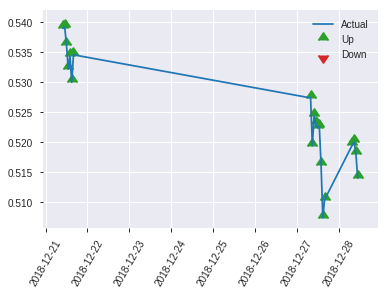


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2512770808588537
RMSE: 0.5012754540757544
LogLoss: 0.695992033702172
Mean Per-Class Error: 0.4431247908999665
AUC: 0.547842087654734
pr_auc: 0.47536708831028485
Gini: 0.09568417530946793
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30586153268814087: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    117  0.959    (117.0/122.0)
1      1    97   0.0102   (1.0/98.0)
Total  6    214  0.5364   (118.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.305862     0.621795  213
max f2                       0.262072     0.801964  218
max f0point5                 0.439385     0.524934  165
max accuracy                 0.701271     0.563636  1
max precision                0.717299     1         0
max recall                   0.262072     1         218
max specificity              0.717299     1         0
max absolute_mcc             0.439385     0.128665  165
max min_per_class_accuracy   0.500036     0.54918   108
max mean_per_class_accuracy  0.4573       0.556875  149

Gains/Lift Table: Avg response rate: 44.55 %, avg score: 49.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.695559           1.4966    1.4966             0.666667         0.705814  0.666667                    0.705814            0.0204082       0.0204082                  49.6599   49.6599
    2        0.0227273                   0.672885           1.12245   1.34694            0.5              0.679896  0.6                         0.695447            0.0102041       0.0306122                  12.2449   34.6939
    3        0.0318182                   0.659482           1.12245   1.2828             0.5              0.662487  0.571429                    0.68603             0.0102041       0.0408163                  12.2449   28.2799
    4        0.0409091                   0.648955           0         0.997732           0                0.65431   0.444444                    0.678981            0               0.0408163                  -100      -0.226757
    5        0.05                        0.642988           0         0.816327           0                0.64594   0.363636                    0.672973            0               0.0408163                  -100      -18.3673
    6        0.1                         0.612345           1.22449   1.02041            0.545455         0.627378  0.454545                    0.650176            0.0612245       0.102041                   22.449    2.04082
    7        0.15                        0.596157           1.22449   1.08844            0.545455         0.600569  0.484848                    0.63364             0.0612245       0.163265                   22.449    8.84354
    8        0.2                         0.578788           0.816327  1.02041            0.363636         0.587705  0.454545                    0.622157            0.0408163       0.204082                   -18.3673  2.04082
    9        0.3                         0.551875           1.32653   1.12245            0.590909         0.56493   0.5                         0.603081            0.132653        0.336735                   32.6531   12.2449
    10       0.4                         0.526226           0.816327  1.04592            0.363636         0.542139  0.465909                    0.587845            0.0816327       0.418367                   -18.3673  4.59184
    11       0.5                         0.49859            1.32653   1.10204            0.590909         0.511905  0.490909                    0.572657            0.132653        0.55102                    32.6531   10.2041
    12       0.6                         0.476279           0.918367  1.07143            0.409091         0.485611  0.477273                    0.55815             0.0918367       0.642857                   -8.16327  7.14286
    13       0.7                         0.454075           1.02041   1.06414            0.454545         0.464833  0.474026                    0.544819            0.102041        0.744898                   2.04082   6.41399
    14       0.8                         0.429058           0.918367  1.04592            0.409091         0.440345  0.465909                    0.531759            0.0918367       0.836735                   -8.16327  4.59184
    15       0.9                         0.379125           0.918367  1.03175            0.409091         0.405103  0.459596                    0.517687            0.0918367       0.928571                   -8.16327  3.1746
    16       1                           0.259833           0.714286  1                  0.318182         0.327444  0.445455                    0.498662       

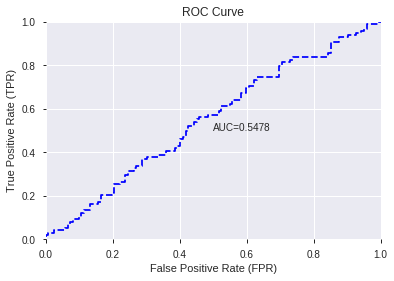

This function is available for GLM models only


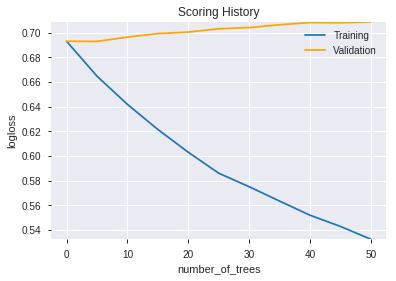

--2019-08-28 17:07:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.124
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.124|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.j

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_170718_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_170718_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b253',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['STOCH_slowd',
 'ADX_8',
 'MFI_8',
 'ADX_20',
 'ADXR_8',
 'HT_DCPERIOD',
 'MACDFIX_hist_14',
 'VAR_8',
 'BETA_14',
 'STOCHRSI_fastd',
 'BOP',
 'ADX_24',
 'NATR_20',
 'BETA_12',
 'MACD_hist',
 'SAREXT',
 'DX_8',
 'ADXR_12',
 'WILLR_20',
 'CORREL_12',
 'DX_14',
 'DX_12',
 'DIV',
 'aroondown_8',
 'WILLR_8',
 'SUB',
 'TRANGE',
 'aroonup_8',
 'STOCHF_fastk',
 'CORREL_14',
 'AROONOSC_12',
 'hour',
 'day',
 'CCI_8',
 'DX_24',
 'aroonup_12',
 'STOCH_slowk',
 'STOCHRSI_fastk',
 'AROONOSC_8',
 'aroondown_24',
 'aroondown_14',
 'STOCHF_fastd',
 'CORREL_8',
 'aroondown_12',
 'dayofweek',
 'CDLRICKSHAWMAN',
 'days_in_month',
 'CDLDOJI']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_170745_model_1  0.490214  0.698618                   0.5  0.502691  0.252699

variable  relative_importance  scaled_importance    percentage
0              is_month_start         1.400819e-02           1.000000  1.327953e-02
1           CDLGRAVESTONEDOJI         1.396218e-02           0.996715  1.323591e-02
2                   CDLHARAMI         1.339584e-02           0.956286  1.269903e-02
3              CDLRICKSHAWMAN         1.289937e-02           0.920845  1.222839e-02
4               days_in_month         1.215331e-02           0.867586  1.152114e-02
...                       ...                  ...                ...           ...
1028  BBANDS_lowerband_12_2_5         3.281465e-06           0.000234  3.110775e-06
1029  BBANDS_middleband_8_7_2         2.099066e-06           0.000150  1.989879e-06
1030  BBANDS_lowerband_24_7_4         1.773911e-06           0.000127  1.681638e-06
1031                     mama         1.518851e-06           0.000108  1.439846e-06
1032                 MAVP_8_7         4.691117e-07           0.000033  4.447101e-07

[1033 rows x 4 columns]

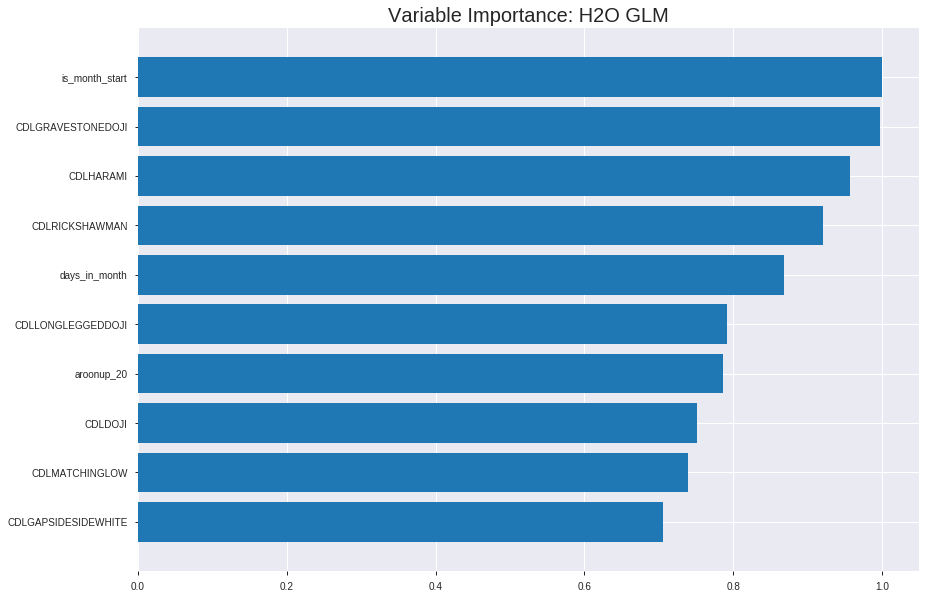

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_170745_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24396501312438476
RMSE: 0.4939281457098641
LogLoss: 0.681005713945241
Null degrees of freedom: 1534
Residual degrees of freedom: 501
Null deviance: 2126.397409180741
Residual deviance: 2090.68754181189
AIC: 4158.68754181189
AUC: 0.6057623679595416
pr_auc: 0.5716281303340536
Gini: 0.21152473591908327
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42643591282426757: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      49   743   0.9381   (743.0/792.0)
1      8    735   0.0108   (8.0/743.0)
Total  57   1478  0.4893   (751.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426436     0.661864  362
max f2                       0.426436     0.825843  362
max f0point5                 0.464234     0.571244  258
max accuracy                 0.481525     0.583062  212
max precision                0.607203     0.8       8
max recall                   0.386077     1         395
max specificity              0.636295     0.998737  0
max absolute_mcc             0.48086      0.164876  214
max min_per_class_accuracy   0.479076     0.577389  219
max mean_per_class_accuracy  0.48086      0.582387  214

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 48.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.598405           1.54946   1.54946            0.75             0.611826  0.75                        0.611826            0.0161507       0.0161507                  54.9462   54.9462
    2        0.0201954                   0.582076           0.964109  1.26623            0.466667         0.589718  0.612903                    0.601129            0.00942127      0.025572                   -3.58905  26.6227
    3        0.0306189                   0.570222           1.42034   1.31869            0.6875           0.575668  0.638298                    0.592461            0.0148048       0.0403769                  42.034    31.8691
    4        0.0403909                   0.562878           1.3773    1.33287            0.666667         0.566355  0.645161                    0.586145            0.013459        0.0538358                  37.7299   33.287
    5        0.0501629                   0.557276           1.65276   1.39519            0.8              0.560338  0.675325                    0.581118            0.0161507       0.0699865                  65.2759   39.5186
    6        0.100326                    0.539577           1.20737   1.30128            0.584416         0.547181  0.62987                     0.56415             0.0605653       0.130552                   20.7373   30.1279
    7        0.150489                    0.527985           1.34153   1.31469            0.649351         0.534079  0.636364                    0.554126            0.0672948       0.197847                   34.1525   31.4695
    8        0.2                         0.517675           1.03297   1.24495            0.5              0.522392  0.602606                    0.54627             0.051144        0.248991                   3.29744   24.4953
    9        0.300326                    0.502655           1.18054   1.22344            0.571429         0.50971   0.592191                    0.534057            0.118439        0.367429                   18.0542   22.3436
    10       0.4                         0.489361           1.08023   1.18775            0.522876         0.495511  0.574919                    0.524452            0.107672        0.475101                   8.02347   18.7752
    11       0.500326                    0.478581           1.0598    1.1621             0.512987         0.483647  0.5625                      0.51627             0.106326        0.581427                   5.98049   16.2096
    12       0.6                         0.468453           0.931702  1.12382            0.45098          0.473402  0.543974                    0.509148            0.0928668       0.674293                   -6.82976  12.3822
    13       0.699674                    0.459105           0.904697  1.09261            0.437908         0.463212  0.528864                    0.502604            0.090175        0.764468                   -9.53034  9.26061
    14       0.8                         0.449436           0.871991  1.06494            0.422078         0.454334  0.515472                    0.496551            0.0874832       0.851952                   -12.8009  6.49394
    15       0.899674                    0.438273           0.810176  1.03671            0.392157         0.444067  0.50181                     0.490736            0.0807537       0.932705                   -18.9824  3.67144
    16       1                           0.366701           0.670763  1                  0.324675         0.423982  0.484039                    0.484039          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25048690025578224
RMSE: 0.5004866634145032
LogLoss: 0.6941044267788348
Null degrees of freedom: 437
Residual degrees of freedom: -596
Null deviance: 608.4098651427188
Residual deviance: 608.0354778582592
AIC: 2676.035477858259
AUC: 0.520699008868023
pr_auc: 0.5401404436416889
Gini: 0.04139801773604601
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3968464348034753: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    209  0.9812   (209.0/213.0)
1      0    225  0        (0.0/225.0)
Total  4    434  0.4772   (209.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396846     0.682853  395
max f2                       0.396846     0.843328  395
max f0point5                 0.459087     0.58147   302
max accuracy                 0.459087     0.552511  302
max precision                0.620685     1         0
max recall                   0.396846     1         395
max specificity              0.620685     1         0
max absolute_mcc             0.58014      0.11814   9
max min_per_class_accuracy   0.487741     0.493333  198
max mean_per_class_accuracy  0.459087     0.54529   302

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 48.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.587846           1.55733   1.55733            0.8              0.60587   0.8                         0.60587             0.0177778       0.0177778                  55.7333   55.7333
    2        0.0205479                   0.580519           1.94667   1.73037            1                0.58248   0.888889                    0.595475            0.0177778       0.0355556                  94.6667   73.037
    3        0.0319635                   0.576194           1.168     1.52952            0.6              0.578046  0.785714                    0.58925             0.0133333       0.0488889                  16.8      52.9524
    4        0.0410959                   0.570026           0.973333  1.40593            0.5              0.572558  0.722222                    0.585541            0.00888889      0.0577778                  -2.66667  40.5926
    5        0.0502283                   0.565616           0.973333  1.32727            0.5              0.567492  0.681818                    0.582259            0.00888889      0.0666667                  -2.66667  32.7273
    6        0.100457                    0.550834           0.884848  1.10606            0.454545         0.557165  0.568182                    0.569712            0.0444444       0.111111                   -11.5152  10.6061
    7        0.150685                    0.537617           0.707879  0.973333           0.363636         0.545497  0.5                         0.56164             0.0355556       0.146667                   -29.2121  -2.66667
    8        0.200913                    0.527263           1.1503    1.01758            0.590909         0.532038  0.522727                    0.55424             0.0577778       0.204444                   15.0303   1.75758
    9        0.30137                     0.510298           0.884848  0.973333           0.454545         0.517967  0.5                         0.542149            0.0888889       0.293333                   -11.5152  -2.66667
    10       0.399543                    0.495644           1.08651   1.00114            0.55814          0.502359  0.514286                    0.532372            0.106667        0.4                        8.65116   0.114286
    11       0.5                         0.487296           0.929091  0.986667           0.477273         0.491525  0.506849                    0.524165            0.0933333       0.493333                   -7.09091  -1.33333
    12       0.600457                    0.474133           1.1503    1.01404            0.590909         0.481121  0.520913                    0.516964            0.115556        0.608889                   15.0303   1.40431
    13       0.69863                     0.464535           1.35814   1.0624             0.697674         0.469338  0.545752                    0.510271            0.133333        0.742222                   35.814    6.23965
    14       0.799087                    0.45594            0.884848  1.04008            0.454545         0.460545  0.534286                    0.50402             0.0888889       0.831111                   -11.5152  4.00762
    15       0.899543                    0.440257           0.796364  1.01286            0.409091         0.448198  0.520305                    0.497786            0.08            0.911111                   -20.3636  1.28596
    16       1                           0.358163           0.884848  1                  0.454545         0.417163  0.513699                    0.489687      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 17:07:48  0.000 sec   2            4.2       1034          1.37152           1.38942
    2019-08-28 17:07:50  1.985 sec   4            3         1034          1.36887           1.3891
    2019-08-28 17:07:52  4.165 sec   6            2.2       1034          1.36571           1.38852
    2019-08-28 17:07:55  6.193 sec   8            1.6       1034          1.36201           1.38821
    2019-08-28 17:07:57  8.247 sec   10           1.2       1034          1.35776           1.38823
    2019-08-28 17:07:59  10.243 sec  12           0.85      1034          1.35295           1.3887
    2019-08-28 17:08:01  12.231 sec  14           0.62      1034          1.34764           1.38979
    2019-08-28 17:08:03  14.335 sec  16           0.45      1034          1.34189           1.39163
    2019-08-28 17:08:05  16.368 sec  18           0.33      1034          1.33583           1.39441

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5818181818181818)

('F1', 0.6163522012578617)

('auc', 0.49021411843425894)

('logloss', 0.6986183852433837)

('mean_per_class_error', 0.46135831381733017)

('rmse', 0.5026914207837725)

('mse', 0.2526986645296078)

glm prediction progress: |████████████████████████████████████████████████| 100%


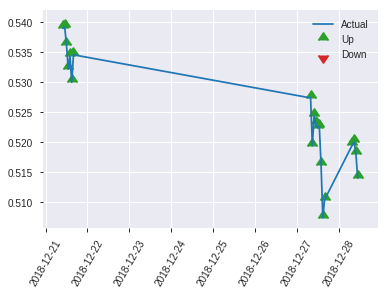


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2526986645296078
RMSE: 0.5026914207837725
LogLoss: 0.6986183852433837
Null degrees of freedom: 219
Residual degrees of freedom: -814
Null deviance: 303.6762860419698
Residual deviance: 307.3920895070888
AIC: 2375.3920895070887
AUC: 0.49021411843425894
pr_auc: 0.4669848818833651
Gini: -0.019571763131482123
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3898582899649598: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    122  1        (122.0/122.0)
1      0    98   0        (0.0/98.0)
Total  0    220  0.5545   (122.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.389858     0.616352  219
max f2                       0.389858     0.800654  219
max f0point5                 0.389858     0.501022  219
max accuracy                 0.562681     0.581818  19
max precision                0.599477     0.666667  2
max recall                   0.389858     1         219
max specificity              0.633055     0.991803  0
max absolute_mcc             0.433748     0.192961  204
max min_per_class_accuracy   0.495229     0.47541   110
max mean_per_class_accuracy  0.560234     0.538642  21

Gains/Lift Table: Avg response rate: 44.55 %, avg score: 49.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.597803           1.4966    1.4966             0.666667         0.620586  0.666667                    0.620586            0.0204082       0.0204082                  49.6599   49.6599
    2        0.0227273                   0.587092           0         0.897959           0                0.589358  0.4                         0.608095            0               0.0204082                  -100      -10.2041
    3        0.0318182                   0.58031            2.2449    1.2828             1                0.583446  0.571429                    0.601052            0.0204082       0.0408163                  124.49    28.2799
    4        0.0409091                   0.577945           0         0.997732           0                0.579102  0.444444                    0.596175            0               0.0408163                  -100      -0.226757
    5        0.05                        0.576203           2.2449    1.22449            1                0.5772    0.545455                    0.592725            0.0204082       0.0612245                  124.49    22.449
    6        0.1                         0.559742           1.63265   1.42857            0.727273         0.566879  0.636364                    0.579802            0.0816327       0.142857                   63.2653   42.8571
    7        0.15                        0.540409           0.612245  1.15646            0.272727         0.549335  0.515152                    0.569646            0.0306122       0.173469                   -38.7755  15.6463
    8        0.2                         0.533003           1.22449   1.17347            0.545455         0.536213  0.522727                    0.561288            0.0612245       0.234694                   22.449    17.3469
    9        0.3                         0.523953           0.816327  1.05442            0.363636         0.528321  0.469697                    0.550299            0.0816327       0.316327                   -18.3673  5.44218
    10       0.4                         0.511011           1.12245   1.07143            0.5              0.518022  0.477273                    0.54223             0.112245        0.428571                   12.2449   7.14286
    11       0.5                         0.495402           0.408163  0.938776           0.181818         0.504703  0.418182                    0.534724            0.0408163       0.469388                   -59.1837  -6.12245
    12       0.6                         0.485902           1.02041   0.952381           0.454545         0.490387  0.424242                    0.527335            0.102041        0.571429                   2.04082   -4.7619
    13       0.7                         0.473877           1.02041   0.962099           0.454545         0.479048  0.428571                    0.520437            0.102041        0.673469                   2.04082   -3.79009
    14       0.8                         0.459685           0.918367  0.956633           0.409091         0.465864  0.426136                    0.513615            0.0918367       0.765306                   -8.16327  -4.33673
    15       0.9                         0.442296           0.918367  0.952381           0.409091         0.452526  0.424242                    0.506827            0.0918367       0.857143                   -8.16327  -4.7619
    16       1                           0.389858           1.42857   1                  0.636364         0.424591  0.445455                    0.498604    

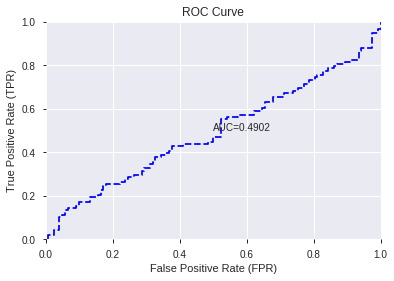

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


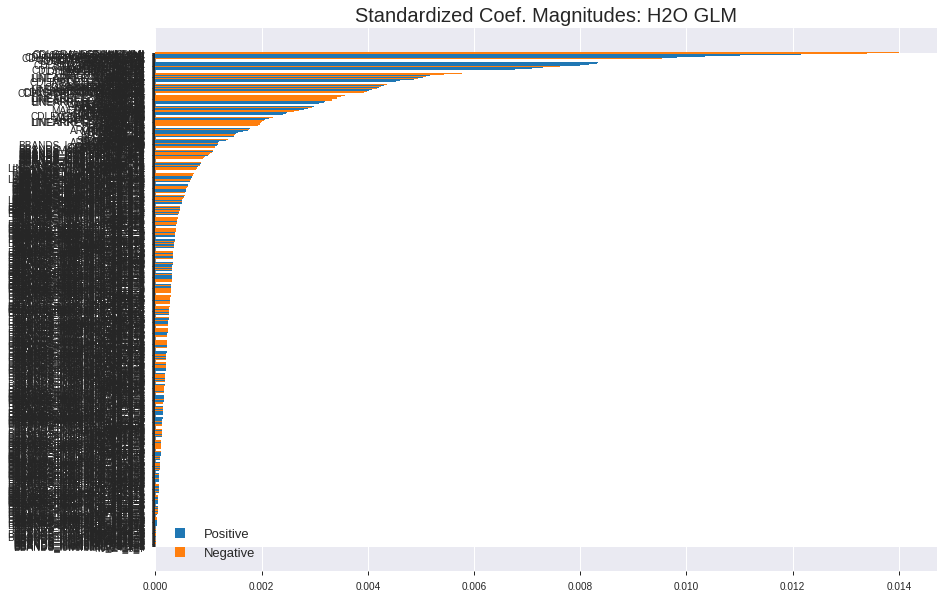

'log_likelihood'
--2019-08-28 17:08:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.162.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.162.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_170745_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_170745_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b253',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

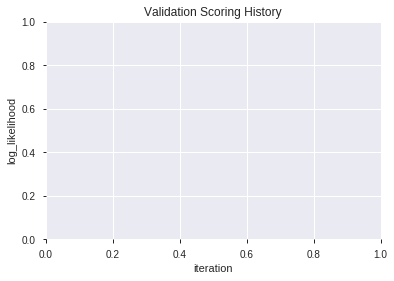

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_170841_model_2  0.532620  0.698689              0.489712  0.502690  0.252698
1  XGBoost_grid_1_AutoML_20190828_170841_model_4  0.525510  0.696718              0.485614  0.501743  0.251746
2  XGBoost_grid_1_AutoML_20190828_170841_model_5  0.514302  0.747897              0.500000  0.523222  0.273762
3  XGBoost_grid_1_AutoML_20190828_170841_model_7  0.497909  0.727968              0.495902  0.516040  0.266298
4  XGBoost_grid_1_AutoML_20190828_170841_model_1  0.488290  0.713310              0.495902  0.509440  0.259530
5  XGBoost_grid_1_AutoML_20190828_170841_model_3  0.487789  0.725036              0.475410  0.515115  0.265343
6               XGBoost_3_AutoML_20190828_170841  0.483105  0.714369              0.500000  0.509861  0.259958
7               XGBoost_1_AutoML_20190828_170841  0.476748  0.724838              0.500000  0.515087  0.265314
8  XGBoost_grid_1_AutoML_20190828_170841_model_6  0.463533  0.734480              0.495902  0.519370  0.269745
9               XGBoost_2_AutoML_20190828_170841  0.462195  0.725717              0.500000  0.515336  0.265571

variable  relative_importance  scaled_importance  percentage
0                HT_DCPERIOD           148.747711           1.000000    0.025225
1       HT_PHASOR_quadrature           119.512245           0.803456    0.020267
2                        BOP           119.054329           0.800378    0.020189
3          HT_PHASOR_inphase           110.198128           0.740839    0.018688
4                      DX_14            96.307648           0.647456    0.016332
..                       ...                  ...                ...         ...
310                 MAVP_8_3             0.493082           0.003315    0.000084
311  BBANDS_upperband_24_0_3             0.395308           0.002658    0.000067
312   BBANDS_lowerband_8_2_3             0.298388           0.002006    0.000051
313   BBANDS_lowerband_8_3_5             0.247889           0.001667    0.000042
314                MAVP_12_4             0.188440           0.001267    0.000032

[315 rows x 4 columns]

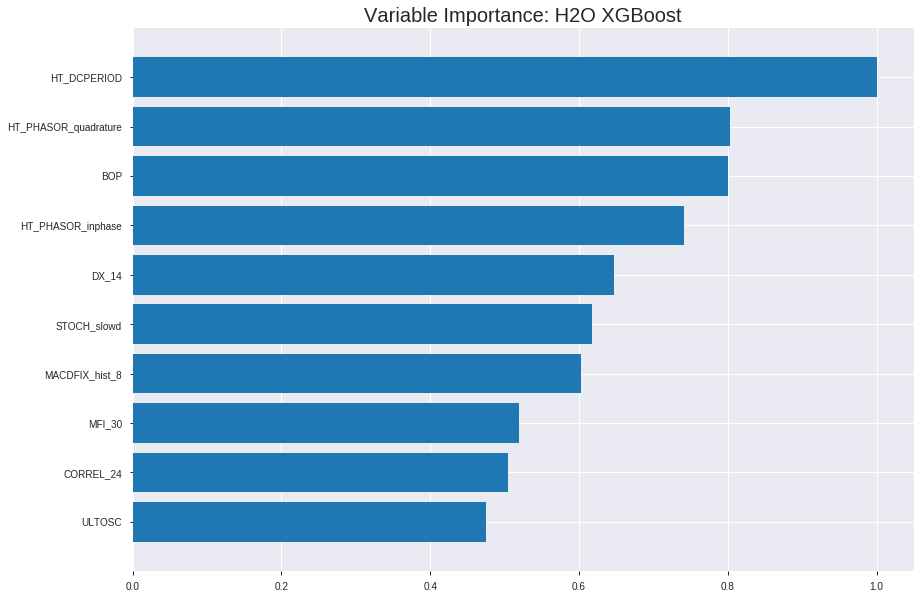

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_170841_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17699052218367048
RMSE: 0.42070241523394003
LogLoss: 0.5434748527567171
Mean Per-Class Error: 0.11031411014587322
AUC: 0.9559338336256237
pr_auc: 0.9555999572469223
Gini: 0.9118676672512473
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4823107197880745: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      699  93   0.1174   (93.0/792.0)
1      77   666  0.1036   (77.0/743.0)
Total  776  759  0.1107   (170.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.482311     0.886818  204
max f2                       0.439504     0.913841  246
max f0point5                 0.52567      0.901844  165
max accuracy                 0.4912       0.889902  198
max precision                0.731147     1         0
max recall                   0.36219      1         329
max specificity              0.731147     1         0
max absolute_mcc             0.4912       0.779551  198
max min_per_class_accuracy   0.487844     0.886945  200
max mean_per_class_accuracy  0.4912       0.889686  198

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 48.71 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.701791           2.06595    2.06595            1                0.71443   1                           0.71443             0.0215343       0.0215343                  106.595   106.595
    2        0.0201954                   0.680666           2.06595    2.06595            1                0.689332  1                           0.702286            0.0201884       0.0417227                  106.595   106.595
    3        0.0306189                   0.671034           2.06595    2.06595            1                0.674115  1                           0.692696            0.0215343       0.0632571                  106.595   106.595
    4        0.0403909                   0.665893           2.06595    2.06595            1                0.668684  1                           0.686887            0.0201884       0.0834455                  106.595   106.595
    5        0.0501629                   0.659468           2.06595    2.06595            1                0.663025  1                           0.682238            0.0201884       0.103634                   106.595   106.595
    6        0.100326                    0.635585           2.06595    2.06595            1                0.647562  1                           0.6649              0.103634        0.207268                   106.595   106.595
    7        0.150489                    0.612159           2.06595    2.06595            1                0.623707  1                           0.651169            0.103634        0.310902                   106.595   106.595
    8        0.2                         0.593655           2.06595    2.06595            1                0.602842  1                           0.639205            0.102288        0.41319                    106.595   106.595
    9        0.300326                    0.555532           1.91838    2.01665            0.928571         0.575715  0.976139                    0.617996            0.192463        0.605653                   91.8381   101.665
    10       0.4                         0.525327           1.71487    1.94145            0.830065         0.539962  0.939739                    0.598551            0.170929        0.776581                   71.4873   94.1454
    11       0.500326                    0.479182           1.22079    1.79695            0.590909         0.504107  0.869792                    0.579613            0.122476        0.899058                   22.0788   79.6945
    12       0.6                         0.445808           0.55362    1.5904             0.267974         0.463826  0.769815                    0.560378            0.0551817       0.95424                    -44.638   59.0399
    13       0.699674                    0.413795           0.337573   1.41192            0.163399         0.430406  0.683426                    0.541862            0.0336474       0.987887                   -66.2427  41.1924
    14       0.8                         0.382109           0.0939068  1.24664            0.0454545        0.397834  0.60342                     0.5238              0.00942127      0.997308                   -90.6093  24.6635
    15       0.899674                    0.34486            0.0270059  1.11151            0.0130719        0.365133  0.538016                    0.506222            0.00269179      1                          -97.2994  11.1513
    16       1                           0.244168           0          1                  0                0.315205  0.484039                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.253345955826952
RMSE: 0.5033348347044461
LogLoss: 0.7000852467079438
Mean Per-Class Error: 0.464131455399061
AUC: 0.5126969222743871
pr_auc: 0.5199677731631406
Gini: 0.025393844548774247
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4053359627723694: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      23   190  0.892    (190.0/213.0)
1      10   215  0.0444   (10.0/225.0)
Total  33   405  0.4566   (200.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405336     0.68254   367
max f2                       0.345697     0.842066  397
max f0point5                 0.405336     0.582656  367
max accuracy                 0.405336     0.543379  367
max precision                0.691923     0.666667  2
max recall                   0.345697     1         397
max specificity              0.728085     0.995305  0
max absolute_mcc             0.405336     0.120316  367
max min_per_class_accuracy   0.505134     0.530516  201
max mean_per_class_accuracy  0.502212     0.535869  209

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 50.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.67529            0.778667  0.778667           0.4              0.69801   0.4                         0.69801             0.00888889      0.00888889                 -22.1333   -22.1333
    2        0.0205479                   0.652038           0.973333  0.865185           0.5              0.664648  0.444444                    0.683183            0.00888889      0.0177778                  -2.66667   -13.4815
    3        0.0319635                   0.643106           1.168     0.973333           0.6              0.646667  0.5                         0.670141            0.0133333       0.0311111                  16.8       -2.66667
    4        0.0410959                   0.639774           0.973333  0.973333           0.5              0.642158  0.5                         0.663923            0.00888889      0.04                       -2.66667   -2.66667
    5        0.0502283                   0.636644           0.486667  0.884848           0.25             0.637893  0.454545                    0.65919             0.00444444      0.0444444                  -51.3333   -11.5152
    6        0.100457                    0.608723           1.1503    1.01758            0.590909         0.621345  0.522727                    0.640267            0.0577778       0.102222                   15.0303    1.75758
    7        0.150685                    0.587626           1.23879   1.09131            0.636364         0.59621   0.560606                    0.625582            0.0622222       0.164444                   23.8788    9.13131
    8        0.200913                    0.573225           1.1503    1.10606            0.590909         0.580577  0.568182                    0.61433             0.0577778       0.222222                   15.0303    10.6061
    9        0.30137                     0.549314           0.752121  0.988081           0.386364         0.562145  0.507576                    0.596935            0.0755556       0.297778                   -24.7879   -1.19192
    10       0.399543                    0.525296           0.995969  0.990019           0.511628         0.536281  0.508571                    0.582031            0.0977778       0.395556                   -0.403101  -0.998095
    11       0.5                         0.505426           1.32727   1.05778            0.681818         0.515466  0.543379                    0.568658            0.133333        0.528889                   32.7273    5.77778
    12       0.600457                    0.484241           0.796364  1.01404            0.409091         0.495817  0.520913                    0.556471            0.08            0.608889                   -20.3636   1.40431
    13       0.69863                     0.461777           0.905426  0.99878            0.465116         0.475037  0.513072                    0.545028            0.0888889       0.697778                   -9.45736   -0.122004
    14       0.799087                    0.443235           0.840606  0.978895           0.431818         0.453079  0.502857                    0.533469            0.0844444       0.782222                   -15.9394   -2.11048
    15       0.899543                    0.411892           1.32727   1.0178             0.681818         0.429846  0.522843                    0.521897            0.133333        0.915556                   32.7273    1.78003
    16       1                           0.334779           0.840606  1                  0.431818         0.384447  0.513699         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:09:01  3.498 sec   0                  0.5              0.693147            0.5             0                  1                0.515961                         0.5                0.693147              0.5               0                    1                  0.486301
    2019-08-28 17:09:02  4.634 sec   5                  0.489002         0.67137             0.829263        0.824913           1.95117          0.254072                         0.500886           0.694922              0.480887          0.497809             1.55733            0.477169
    2019-08-28 17:09:02  4.883 sec   10                 0.478767         0.651447            0.867933        0.868236           2.06595          0.21759                          0.501782           0.696722              0.475879          0.508768             1.55733            0.486301
    2019-08-28 17:09:02  5.141 sec   15                 0.469564         0.633792            0.892571        0.889459           2.06595          0.196743                         0.50189            0.696937              0.487376          0.517932             1.55733            0.477169
    2019-08-28 17:09:02  5.395 sec   20                 0.461513         0.618515            0.906489        0.904402           2.06595          0.174593                         0.501264           0.695679              0.503203          0.514618             1.55733            0.46347
    2019-08-28 17:09:03  5.648 sec   25                 0.453312         0.603113            0.917572        0.916439           2.06595          0.160912                         0.501607           0.696371              0.501367          0.514029             1.55733            0.477169
    2019-08-28 17:09:03  5.900 sec   30                 0.446706         0.590796            0.92402         0.923607           2.06595          0.14658                          0.502134           0.697455              0.502546          0.514502             1.168              0.479452
    2019-08-28 17:09:03  6.165 sec   35                 0.440075         0.578546            0.931479        0.9327             2.06595          0.136808                         0.501543           0.696289              0.516109          0.522208             1.55733            0.479452
    2019-08-28 17:09:03  6.418 sec   40                 0.433249         0.566122            0.942524        0.94356            2.06595          0.129642                         0.501936           0.697118              0.516004          0.52212              1.168              0.479452
    2019-08-28 17:09:04  6.680 sec   45                 0.426974         0.554782            0.950052        0.949126           2.06595          0.113355                         0.502657           0.698643              0.513542          0.52168              1.55733            0.472603
    2019-08-28 17:09:04  6.932 sec   50                 0.420702         0.543475            0.955934        0.9556             2.06595          0.110749                         0.503335           0.700085              0.512697          0.519968             0.778667           0.456621

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
HT_DCPERIOD              148.74771118164062     1.0                    0.02522491507586688
HT_PHASOR_quadrature     119.51224517822266     0.8034560278529759     0.020267110069784648
BOP                      119.05432891845703     0.800377551847342      0.02018945577397944
HT_PHASOR_inphase        110.19812774658203     0.7408391488593431     0.01868760461485443
DX_14                    96.30764770507812      0.6474563335463612     0.0163320310290391
---                      ---                    ---                    ---
MAVP_8_3                 0.4930817484855652     0.0033148862901389263  8.361772515490983e-05
BBANDS_upperband_24_0_3  0.39530810713768005    0.002657574385497311   6.703708818196877e-05
BBANDS_lowerband_8_2_3   0.29838812351226807    0.0020060014446064093  5.0601216082262955e-05
BBANDS_lowerband_8_3_5   0.24788865447044373    0.0016665039919016899  4.203742166931327e-05
MAVP_12_4                0.18844038248062134    0.001266845593681174   3.195607251484378e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5727272727272728)

('F1', 0.6173633440514469)

('auc', 0.5326196052191369)

('logloss', 0.6986894869857742)

('mean_per_class_error', 0.45107059217129475)

('rmse', 0.5026904396584044)

('mse', 0.25269767812395993)

xgboost prediction progress: |████████████████████████████████████████████| 100%


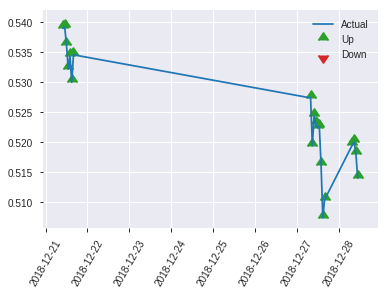


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25269767812395993
RMSE: 0.5026904396584044
LogLoss: 0.6986894869857742
Mean Per-Class Error: 0.45107059217129475
AUC: 0.5326196052191369
pr_auc: 0.4809961021423764
Gini: 0.06523921043827374
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.396450012922287: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    117  0.959    (117.0/122.0)
1      2    96   0.0204   (2.0/98.0)
Total  7    213  0.5409   (119.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.39645      0.617363  212
max f2                       0.346812     0.800654  219
max f0point5                 0.487265     0.513595  140
max accuracy                 0.604964     0.572727  23
max precision                0.691917     1         0
max recall                   0.346812     1         219
max specificity              0.691917     1         0
max absolute_mcc             0.65694      0.108785  4
max min_per_class_accuracy   0.522811     0.540816  107
max mean_per_class_accuracy  0.503745     0.548929  124

Gains/Lift Table: Avg response rate: 44.55 %, avg score: 51.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.663255           1.4966    1.4966             0.666667         0.673239  0.666667                    0.673239            0.0204082       0.0204082                  49.6599   49.6599
    2        0.0227273                   0.653674           2.2449    1.79592            1                0.659605  0.8                         0.667786            0.0204082       0.0408163                  124.49    79.5918
    3        0.0318182                   0.640886           0         1.2828             0                0.647101  0.571429                    0.661876            0               0.0408163                  -100      28.2799
    4        0.0409091                   0.630526           1.12245   1.24717            0.5              0.635338  0.555556                    0.655979            0.0102041       0.0510204                  12.2449   24.7166
    5        0.05                        0.627458           0         1.02041            0                0.629033  0.454545                    0.651079            0               0.0510204                  -100      2.04082
    6        0.1                         0.608816           1.42857   1.22449            0.636364         0.618756  0.545455                    0.634918            0.0714286       0.122449                   42.8571   22.449
    7        0.15                        0.592136           1.02041   1.15646            0.454545         0.598638  0.515152                    0.622825            0.0510204       0.173469                   2.04082   15.6463
    8        0.2                         0.582361           1.02041   1.12245            0.454545         0.58846   0.5                         0.614233            0.0510204       0.22449                    2.04082   12.2449
    9        0.3                         0.554302           1.02041   1.08844            0.454545         0.565924  0.484848                    0.59813             0.102041        0.326531                   2.04082   8.84354
    10       0.4                         0.536327           0.918367  1.04592            0.409091         0.546971  0.465909                    0.58534             0.0918367       0.418367                   -8.16327  4.59184
    11       0.5                         0.520964           1.22449   1.08163            0.545455         0.527409  0.481818                    0.573754            0.122449        0.540816                   22.449    8.16327
    12       0.6                         0.499734           0.918367  1.05442            0.409091         0.509626  0.469697                    0.563066            0.0918367       0.632653                   -8.16327  5.44218
    13       0.7                         0.470452           1.02041   1.04956            0.454545         0.483916  0.467532                    0.551759            0.102041        0.734694                   2.04082   4.95627
    14       0.8                         0.44818            0.714286  1.00765            0.318182         0.459488  0.448864                    0.540225            0.0714286       0.806122                   -28.5714  0.765306
    15       0.9                         0.420786           0.714286  0.975057           0.318182         0.433499  0.434343                    0.528367            0.0714286       0.877551                   -28.5714  -2.49433
    16       1                           0.346812           1.22449   1                  0.545455         0.396703  0.445455                    0.5152          

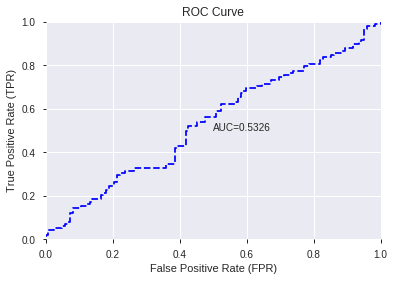

This function is available for GLM models only


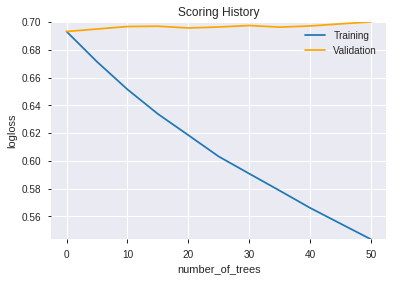

--2019-08-28 17:09:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_170841_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_170841_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b253',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_170945_model_8  0.547424  0.696951              0.458933  0.501761  0.251764
1               DeepLearning_1_AutoML_20190828_170945  0.520575  0.757982              0.495902  0.526152  0.276836
2  DeepLearning_grid_1_AutoML_20190828_170945_model_1  0.504767  1.547575              0.492807  0.630485  0.397512
3  DeepLearning_grid_1_AutoML_20190828_170945_model_6  0.503095  0.706628              0.489712  0.505829  0.255863
4  DeepLearning_grid_1_AutoML_20190828_170945_model_9  0.501171  0.696643              0.495902  0.501713  0.251716
5  DeepLearning_grid_1_AutoML_20190828_170945_model_3  0.499749  0.911334              0.495902  0.564183  0.318302
6  DeepLearning_grid_1_AutoML_20190828_170945_model_5  0.492974  0.730804              0.491803  0.516153  0.266414
7  DeepLearning_grid_1_AutoML_20190828_170945_model_4  0.491301  1.217172              0.455922  0.615452  0.378781
8  DeepLearning_grid_1_AutoML_20190828_170945_model_7  0.484945  1.180544              0.487705  0.623589  0.388863
9  DeepLearning_grid_1_AutoML_20190828_170945_model_2  0.473904  1.156826              0.495902  0.604063  0.364892

variable  relative_importance  scaled_importance  percentage
0        aroondown_24             1.000000           1.000000    0.025176
1       days_in_month             0.963833           0.963833    0.024265
2        HT_TRENDMODE             0.948946           0.948946    0.023891
3              SAREXT             0.944506           0.944506    0.023779
4                hour             0.920112           0.920112    0.023165
5            CORREL_8             0.874324           0.874324    0.022012
6          aroonup_12             0.865275           0.865275    0.021784
7            WILLR_20             0.858877           0.858877    0.021623
8                 day             0.858001           0.858001    0.021601
9           aroonup_8             0.834769           0.834769    0.021016
10              VAR_8             0.831352           0.831352    0.020930
11          CORREL_12             0.825732           0.825732    0.020789
12            NATR_20             0.824516           0.824516    0.020758
13       aroondown_12             0.814558           0.814558    0.020507
14     STOCHRSI_fastd             0.813392           0.813392    0.020478
15     CDLRICKSHAWMAN             0.808834           0.808834    0.020363
16    MACDFIX_hist_14             0.808174           0.808174    0.020346
17     STOCHRSI_fastk             0.805176           0.805176    0.020271
18            ADXR_12             0.804885           0.804885    0.020264
19             ADXR_8             0.799225           0.799225    0.020121
20        HT_DCPERIOD             0.798880           0.798880    0.020112
21          CORREL_14             0.798610           0.798610    0.020106
22        AROONOSC_12             0.794922           0.794922    0.020013
23              MFI_8             0.781501           0.781501    0.019675
24            BETA_12             0.780897           0.780897    0.019660
25          dayofweek             0.776857           0.776857    0.019558
26               DX_8             0.776004           0.776004    0.019537
27        aroondown_8             0.775476           0.775476    0.019523
28  CDLLONGLEGGEDDOJI             0.767645           0.767645    0.019326
29             ADX_20             0.763981           0.763981    0.019234
30             TRANGE             0.760618           0.760618    0.019149
31                BOP             0.759298           0.759298    0.019116
32             ADX_24             0.758407           0.758407    0.019094
33              ADX_8             0.758227           0.758227    0.019089
34                SUB             0.753982           0.753982    0.018982
35            BETA_14             0.749993           0.749993    0.018882
36       STOCHF_fastk             0.746597           0.746597    0.018796
37       aroondown_14             0.745004           0.745004    0.018756
38              DX_14             0.741296           0.741296    0.018663
39              DX_24             0.738688           0.738688    0.018597
40            CDLDOJI             0.735846           0.735846    0.018526
41              CCI_8             0.735040           0.735040    0.018505
42              DX_12             0.734310           0.734310    0.018487
43            WILLR_8             0.732291           0.732291    0.018436
44                DIV             0.725328           0.725328    0.018261
45        STOCH_slowd             0.719824           0.719824    0.018122
46        STOCH_slowk             0.711703           0.711703    0.017918
47          MACD_hist             0.700259           0.700259    0.017630
48         AROONOSC_8             0.697670           0.697670    0.017564
49       STOCHF_fastd             0.696917           0.696917    0.017546

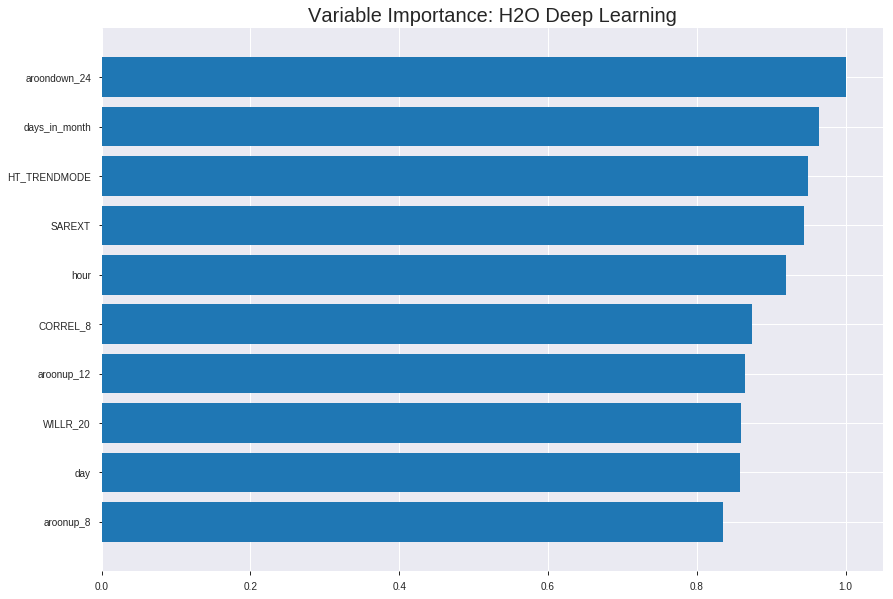

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_170945_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2449240833370641
RMSE: 0.4948980534787585
LogLoss: 0.6831026403466811
Mean Per-Class Error: 0.4305249670323694
AUC: 0.5813705697622252
pr_auc: 0.559359815898984
Gini: 0.16274113952445046
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43670760851129437: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      40   752   0.9495   (752.0/792.0)
1      16   727   0.0215   (16.0/743.0)
Total  56   1479  0.5003   (768.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436708     0.654365  384
max f2                       0.427642     0.824273  399
max f0point5                 0.445273     0.550317  351
max accuracy                 0.509213     0.574593  259
max precision                0.682003     0.689655  43
max recall                   0.427642     1         399
max specificity              0.779854     0.997475  0
max absolute_mcc             0.567388     0.147872  187
max min_per_class_accuracy   0.446016     0.523553  350
max mean_per_class_accuracy  0.506315     0.569475  262

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 50.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.726876           1.29122   1.29122            0.625            0.742811  0.625                       0.742811            0.013459        0.013459                   29.1218   29.1218
    2        0.0201954                   0.706166           1.23957   1.26623            0.6              0.717136  0.612903                    0.730388            0.0121131       0.025572                   23.9569   26.6227
    3        0.0306189                   0.692605           1.54946   1.36265            0.75             0.699636  0.659574                    0.719919            0.0161507       0.0417227                  54.9462   36.2647
    4        0.0403909                   0.677974           1.51503   1.39951            0.733333         0.684568  0.677419                    0.711366            0.0148048       0.0565276                  51.5029   39.9514
    5        0.0501629                   0.667686           1.10184   1.34153            0.533333         0.674115  0.649351                    0.70411             0.0107672       0.0672948                  10.1839   34.1525
    6        0.100326                    0.640734           1.26103   1.30128            0.61039          0.65522   0.62987                     0.679665            0.0632571       0.130552                   26.1034   30.1279
    7        0.150489                    0.616719           1.26103   1.28786            0.61039          0.62825   0.623377                    0.662526            0.0632571       0.193809                   26.1034   28.7864
    8        0.2                         0.593542           1.19608   1.26514            0.578947         0.603596  0.612378                    0.647938            0.0592194       0.253028                   19.6076   26.5141
    9        0.300326                    0.533556           1.12688   1.21895            0.545455         0.565847  0.590022                    0.620515            0.113055        0.366083                   12.6881   21.8955
    10       0.4                         0.474612           0.918199  1.14401            0.444444         0.501017  0.553746                    0.590738            0.0915209       0.457604                   -8.18005  14.4011
    11       0.755049                    0.445274           0.959055  1.05704            0.46422          0.447719  0.511648                    0.523486            0.340511        0.798116                   -4.09448  5.70385
    12       0.8                         0.445186           0.778473  1.04139            0.376812         0.445229  0.504072                    0.519088            0.0349933       0.833109                   -22.1527  4.13863
    13       0.899674                    0.441326           0.891194  1.02475            0.431373         0.443872  0.496017                    0.510755            0.0888291       0.921938                   -10.8806  2.47465
    14       1                           0.427642           0.778085  1                  0.376623         0.437274  0.484039                    0.503383            0.0780619       1                          -22.1915  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2568541199454894
RMSE: 0.5068077741565232
LogLoss: 0.7072384696776259
Mean Per-Class Error: 0.4866666666666667
AUC: 0.4902034428794992
pr_auc: 0.516111502842301
Gini: -0.01959311424100163
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4299386269483451: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    213  1        (213.0/213.0)
1      0    225  0        (0.0/225.0)
Total  0    438  0.4863   (213.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.429939     0.678733  312
max f2                       0.429939     0.840807  312
max f0point5                 0.429939     0.569044  312
max accuracy                 0.429939     0.513699  312
max precision                0.740888     1         0
max recall                   0.429939     1         312
max specificity              0.740888     1         0
max absolute_mcc             0.691341     0.114665  5
max min_per_class_accuracy   0.450487     0.448889  194
max mean_per_class_accuracy  0.691341     0.513333  5

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 50.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.692906           1.94667   1.94667            1                0.713085  1                           0.713085            0.0222222       0.0222222                  94.6667   94.6667
    2        0.0205479                   0.680863           0.486667  1.29778            0.25             0.68536   0.666667                    0.700763            0.00444444      0.0266667                  -51.3333  29.7778
    3        0.0319635                   0.674403           0.778667  1.11238            0.4              0.677444  0.571429                    0.692434            0.00888889      0.0355556                  -22.1333  11.2381
    4        0.0410959                   0.670426           0.973333  1.08148            0.5              0.672805  0.555556                    0.688072            0.00888889      0.0444444                  -2.66667  8.14815
    5        0.0502283                   0.666282           0         0.884848           0                0.668147  0.454545                    0.68445             0               0.0444444                  -100      -11.5152
    6        0.100457                    0.641756           1.1503    1.01758            0.590909         0.652699  0.522727                    0.668574            0.0577778       0.102222                   15.0303   1.75758
    7        0.150685                    0.616992           0.796364  0.943838           0.409091         0.628613  0.484848                    0.655254            0.04            0.142222                   -20.3636  -5.61616
    8        0.200913                    0.581423           1.06182   0.973333           0.545455         0.601925  0.5                         0.641922            0.0533333       0.195556                   6.18182   -2.66667
    9        0.30137                     0.536894           1.01758   0.988081           0.522727         0.560524  0.507576                    0.614789            0.102222        0.297778                   1.75758   -1.19192
    10       0.399543                    0.478272           1.04124   1.00114            0.534884         0.508894  0.514286                    0.588769            0.102222        0.4                        4.12403   0.114286
    11       0.737443                    0.445274           0.986486  0.994427           0.506757         0.448079  0.510836                    0.524304            0.333333        0.733333                   -1.35135  -0.557276
    12       0.799087                    0.444653           0.648889  0.967771           0.333333         0.445127  0.497143                    0.518196            0.04            0.773333                   -35.1111  -3.22286
    13       0.899543                    0.440779           1.19455   0.993096           0.613636         0.443152  0.510152                    0.509816            0.12            0.893333                   19.4545   -0.690355
    14       1                           0.429939           1.06182   1                  0.545455         0.437576  0.513699                    0.502559            0.106667        1                          6.18182   0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:15:07  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 17:15:08  1 min  2.752 sec  609 obs/sec       0.627362  1             963        0.508251         0.711858            -0.0343311     0.530295        0.512863           0.903853         0.512052                         0.509677           0.714266              -0.0398649       0.530172          0.541447             1.55733            0.481735
    2019-08-28 17:15:18  1 min 12.328 sec  1028 obs/sec      6.86645   11            10540      0.504765         0.70295             -0.0201914     0.558004        0.549071           1.42034          0.515961                         0.511359           0.716569              -0.0467389       0.499019          0.509486             1.55733            0.477169
    2019-08-28 17:15:27  1 min 21.387 sec  1189 obs/sec      14.2743   23            21911      0.494898         0.683103            0.0193043      0.581371        0.55936            1.29122          0.500326                         0.506808           0.707238              -0.0281882       0.490203          0.516112             1.94667            0.486301
    2019-08-28 17:15:36  1 min 30.345 sec  1293 obs/sec      22.3264   36            34271      0.489233         0.670321            0.0416291      0.600302        0.631583           1.93683          0.504235                         0.52041            0.752989              -0.0841203       0.482337          0.50083              0.389333           0.474886
    2019-08-28 17:15:45  1 min 39.346 sec  1373 obs/sec      30.9785   50            47552      0.477699         0.645576            0.0862818      0.648269        0.678103           1.93683          0.479479                         0.528036           0.785061              -0.116125        0.4935            0.498668             0.389333           0.479452
    2019-08-28 17:15:54  1 min 48.496 sec  1418 obs/sec      39.6195   64            60816      0.473922         0.636876            0.100676       0.694759        0.71781            2.06595          0.446906                         0.523199           0.798436              -0.0957703       0.525216          0.517932             0.389333           0.481735
    2019-08-28 17:15:55  1 min 49.418 sec  1417 obs/sec      39.6195   64            60816      0.494898         0.683103            0.0193043      0.581371        0.55936            1.29122          0.500326                         0.506808           0.707238              -0.0281882       0.490203          0.516112             1.94667            0.486301

Variable Importances: 


variable       relative_importance    scaled_importance    percentage
-------------  ---------------------  -------------------  --------------------
aroondown_24   1.0                    1.0                  0.025175882041810406
days_in_month  0.963833212852478      0.963833212852478    0.024265351274753127
HT_TRENDMODE   0.9489459991455078     0.9489459991455078   0.023890552538535222
SAREXT         0.9445056319236755     0.9445056319236755   0.023778762377136053
hour           0.920111894607544      0.920111894607544    0.023164628523906213
---            ---                    ---                  ---
STOCH_slowd    0.7198235988616943     0.7198235988616943   0.01812219401585347
STOCH_slowk    0.7117030024528503     0.7117030024528503   0.017917750838555263
MACD_hist      0.7002585530281067     0.7002585530281067   0.017629626729804452
AROONOSC_8     0.6976702213287354     0.6976702213287354   0.017564463196256
STOCHF_fastd   0.6969173550605774     0.6969173550605774   0.017545509123895596


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5772727272727273)

('F1', 0.6287625418060201)

('auc', 0.547423887587822)

('logloss', 0.6969505642011228)

('mean_per_class_error', 0.452576112412178)

('rmse', 0.5017607152800557)

('mse', 0.2517638153983532)

deeplearning prediction progress: |███████████████████████████████████████| 100%


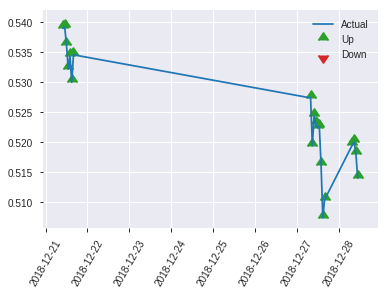


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2517638153983532
RMSE: 0.5017607152800557
LogLoss: 0.6969505642011228
Mean Per-Class Error: 0.452576112412178
AUC: 0.547423887587822
pr_auc: 0.4875960130225864
Gini: 0.09484777517564402
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4443270092702479: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   107  0.877    (107.0/122.0)
1      4    94   0.0408   (4.0/98.0)
Total  19   201  0.5045   (111.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444327     0.628763  144
max f2                       0.434315     0.801964  162
max f0point5                 0.445198     0.522565  129
max accuracy                 0.651378     0.577273  18
max precision                0.703879     1         0
max recall                   0.434315     1         162
max specificity              0.703879     1         0
max absolute_mcc             0.444327     0.145326  144
max min_per_class_accuracy   0.467418     0.532787  109
max mean_per_class_accuracy  0.549709     0.547424  66

Gains/Lift Table: Avg response rate: 44.55 %, avg score: 50.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.698693           2.2449    2.2449             1                0.701407  1                           0.701407            0.0306122       0.0306122                  124.49    124.49
    2        0.0227273                   0.674577           0         1.34694            0                0.68595   0.6                         0.695224            0               0.0306122                  -100      34.6939
    3        0.0318182                   0.667177           0         0.962099           0                0.668826  0.428571                    0.687682            0               0.0306122                  -100      -3.79009
    4        0.0409091                   0.663913           1.12245   0.997732           0.5              0.666347  0.444444                    0.682941            0.0102041       0.0408163                  12.2449   -0.226757
    5        0.05                        0.661396           2.2449    1.22449            1                0.662771  0.545455                    0.679274            0.0204082       0.0612245                  124.49    22.449
    6        0.1                         0.639907           1.22449   1.22449            0.545455         0.651804  0.545455                    0.665539            0.0612245       0.122449                   22.449    22.449
    7        0.15                        0.615914           1.02041   1.15646            0.454545         0.625925  0.515152                    0.652334            0.0510204       0.173469                   2.04082   15.6463
    8        0.2                         0.598049           0.612245  1.02041            0.272727         0.609544  0.454545                    0.641637            0.0306122       0.204082                   -38.7755  2.04082
    9        0.3                         0.550006           1.42857   1.15646            0.636364         0.573655  0.515152                    0.618976            0.142857        0.346939                   42.8571   15.6463
    10       0.4                         0.504594           0.918367  1.09694            0.409091         0.529391  0.488636                    0.59658             0.0918367       0.438776                   -8.16327  9.69388
    11       0.5                         0.46637            1.02041   1.08163            0.454545         0.48166   0.481818                    0.573596            0.102041        0.540816                   2.04082   8.16327
    12       0.818182                    0.445274           1.02624   1.06009            0.457143         0.447078  0.472222                    0.524394            0.326531        0.867347                   2.62391   6.00907
    13       0.9                         0.444758           0.873016  1.04308            0.388889         0.445093  0.464646                    0.517185            0.0714286       0.938776                   -12.6984  4.30839
    14       1                           0.433837           0.612245  1                  0.272727         0.439053  0.445455                    0.509372            0.0612245       1                          -38.7755  0

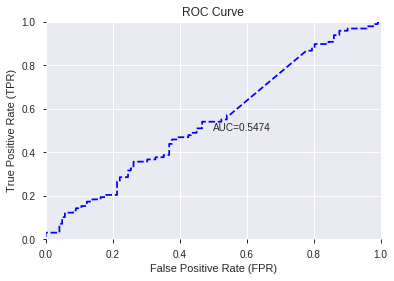

This function is available for GLM models only


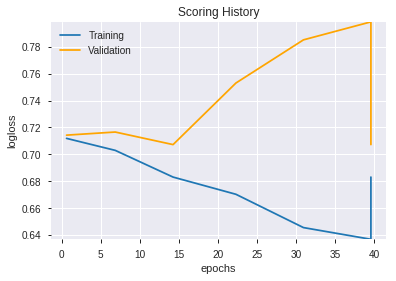

--2019-08-28 17:17:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.232.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.232.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_170945_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_170945_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b253',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['aroondown_24',
 'days_in_month',
 'HT_TRENDMODE',
 'SAREXT',
 'hour',
 'CORREL_8',
 'aroonup_12',
 'WILLR_20',
 'day',
 'aroonup_8',
 'VAR_8',
 'CORREL_12',
 'NATR_20',
 'aroondown_12',
 'STOCHRSI_fastd',
 'CDLRICKSHAWMAN',
 'MACDFIX_hist_14',
 'STOCHRSI_fastk',
 'ADXR_12',
 'ADXR_8',
 'HT_DCPERIOD',
 'CORREL_14',
 'AROONOSC_12',
 'MFI_8',
 'BETA_12',
 'dayofweek',
 'DX_8',
 'aroondown_8',
 'CDLLONGLEGGEDDOJI',
 'ADX_20',
 'TRANGE',
 'BOP',
 'ADX_24',
 'ADX_8',
 'SUB',
 'BETA_14',
 'STOCHF_fastk',
 'aroondown_14',
 'DX_14',
 'DX_24',
 'CDLDOJI',
 'CCI_8',
 'DX_12',
 'WILLR_8',
 'DIV',
 'STOCH_slowd',
 'STOCH_slowk',
 'MACD_hist',
 'AROONOSC_8',
 'STOCHF_fastd']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190828_171712_model_1  0.518234  0.690825              0.491803  0.498838  0.24884

variable  relative_importance  scaled_importance  percentage
0        aroondown_24             0.014620           1.000000    0.048361
1       days_in_month             0.014489           0.991073    0.047929
2      CDLRICKSHAWMAN             0.014189           0.970523    0.046935
3     MACDFIX_hist_14             0.013493           0.922908    0.044633
4   CDLLONGLEGGEDDOJI             0.011650           0.796839    0.038536
5         aroondown_8             0.011372           0.777869    0.037619
6             CDLDOJI             0.011056           0.756257    0.036573
7                DX_8             0.010813           0.739590    0.035767
8               DX_12             0.010369           0.709264    0.034301
9               ADX_8             0.010320           0.705865    0.034136
10          MACD_hist             0.010275           0.702799    0.033988
11          CORREL_14             0.009785           0.669331    0.032370
12       aroondown_14             0.009327           0.637983    0.030854
13              DX_14             0.009277           0.634544    0.030687
14          CORREL_12             0.009270           0.634072    0.030664
15              MFI_8             0.008987           0.614748    0.029730
16                SUB             0.008802           0.602035    0.029115
17       aroondown_12             0.008382           0.573370    0.027729
18                DIV             0.007515           0.514037    0.024859
19             ADXR_8             0.007163           0.489958    0.023695
20           CORREL_8             0.006904           0.472261    0.022839
21        AROONOSC_12             0.006638           0.454031    0.021957
22              VAR_8             0.006255           0.427859    0.020692
23       HT_TRENDMODE             0.006060           0.414508    0.020046
24             TRANGE             0.005772           0.394793    0.019093
25         AROONOSC_8             0.005515           0.377265    0.018245
26              DX_24             0.005447           0.372595    0.018019
27        STOCH_slowd             0.004829           0.330302    0.015974
28              CCI_8             0.004753           0.325131    0.015724
29            BETA_12             0.003831           0.262064    0.012674
30             SAREXT             0.003639           0.248937    0.012039
31         aroonup_12             0.003181           0.217553    0.010521
32            NATR_20             0.003178           0.217349    0.010511
33           WILLR_20             0.003025           0.206892    0.010006
34     STOCHRSI_fastk             0.002529           0.172971    0.008365
35            ADXR_12             0.002342           0.160164    0.007746
36       STOCHF_fastd             0.002060           0.140888    0.006813
37        STOCH_slowk             0.002040           0.139541    0.006748
38          aroonup_8             0.002022           0.138338    0.006690
39                BOP             0.001937           0.132498    0.006408
40          dayofweek             0.001816           0.124207    0.006007
41                day             0.001490           0.101939    0.004930
42       STOCHF_fastk             0.001417           0.096899    0.004686
43     STOCHRSI_fastd             0.001315           0.089971    0.004351
44        HT_DCPERIOD             0.001204           0.082370    0.003983
45            BETA_14             0.000626           0.042796    0.002070
46             ADX_20             0.000573           0.039163    0.001894
47            WILLR_8             0.000371           0.025385    0.001228
48               hour             0.000239           0.016336    0.000790
49             ADX_24             0.000142           0.009732    0.000471

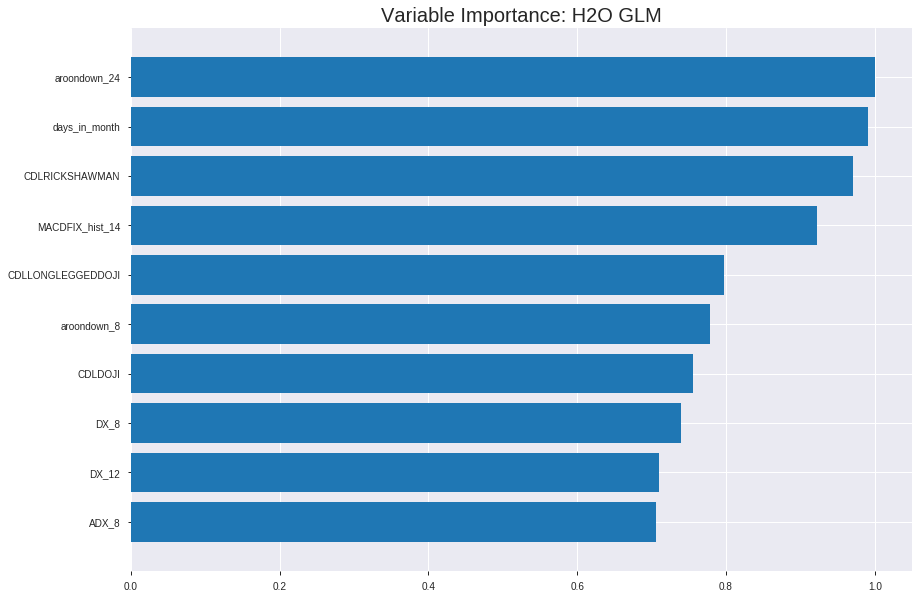

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_171712_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2469299753174397
RMSE: 0.49692049194759486
LogLoss: 0.6869931156472998
Null degrees of freedom: 1534
Residual degrees of freedom: 1484
Null deviance: 2126.397409180741
Residual deviance: 2109.0688650372103
AIC: 2211.0688650372103
AUC: 0.5734659855622171
pr_auc: 0.5461195254086784
Gini: 0.14693197112443412
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42806670253995993: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    787   0.9937   (787.0/792.0)
1      0    743   0        (0.0/743.0)
Total  5    1530  0.5127   (787.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428067     0.653762  394
max f2                       0.428067     0.825189  394
max f0point5                 0.477139     0.550943  234
max accuracy                 0.49143      0.570684  178
max precision                0.587503     1         0
max recall                   0.428067     1         394
max specificity              0.587503     1         0
max absolute_mcc             0.49143      0.138245  178
max min_per_class_accuracy   0.479109     0.561238  226
max mean_per_class_accuracy  0.488775     0.566388  189

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 48.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.561609           1.29122   1.29122            0.625            0.569696  0.625                       0.569696            0.013459        0.013459                   29.1218   29.1218
    2        0.0201954                   0.552738           1.10184   1.19958            0.533333         0.557391  0.580645                    0.563742            0.0107672       0.0242261                  10.1839   19.9583
    3        0.0306189                   0.544051           1.54946   1.31869            0.75             0.548436  0.638298                    0.558531            0.0161507       0.0403769                  54.9462   31.8691
    4        0.0403909                   0.538986           1.23957   1.29955            0.6              0.541278  0.629032                    0.554357            0.0121131       0.0524899                  23.9569   29.9548
    5        0.0501629                   0.534506           1.10184   1.26103            0.533333         0.536118  0.61039                     0.550804            0.0107672       0.0632571                  10.1839   26.1034
    6        0.100326                    0.525639           1.2342    1.24762            0.597403         0.529928  0.603896                    0.540366            0.0619112       0.125168                   23.4203   24.7618
    7        0.150489                    0.516295           1.20737   1.2342             0.584416         0.521195  0.597403                    0.533976            0.0605653       0.185734                   20.7373   23.4203
    8        0.2                         0.508463           1.00579   1.17766            0.486842         0.512945  0.570033                    0.52877             0.0497981       0.235532                   0.579089  17.7658
    9        0.300326                    0.496088           1.20737   1.18758            0.584416         0.502056  0.574837                    0.519846            0.121131        0.356662                   20.7373   18.7584
    10       0.4                         0.48696            1.05323   1.1541             0.509804         0.491347  0.558632                    0.512744            0.10498         0.461642                   5.32288   15.4105
    11       0.500326                    0.478839           1.01956   1.12713            0.493506         0.482692  0.545573                    0.506718            0.102288        0.56393                    1.95592   12.7126
    12       0.6                         0.471946           0.837182  1.07896            0.405229         0.475367  0.522258                    0.50151             0.0834455       0.647376                   -16.2818  7.89592
    13       0.699674                    0.465782           0.877691  1.05029            0.424837         0.468778  0.50838                     0.496847            0.0874832       0.734859                   -12.2309  5.02868
    14       0.8                         0.459751           0.939068  1.03634            0.454545         0.463067  0.501629                    0.492611            0.0942127       0.829071                   -6.09323  3.63392
    15       0.899674                    0.451844           0.877691  1.01876            0.424837         0.45631   0.493121                    0.488589            0.0874832       0.916555                   -12.2309  1.87626
    16       1                           0.418959           0.831746  1                  0.402597         0.443239  0.484039                    0.484039         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25021130566188265
RMSE: 0.5002112610306596
LogLoss: 0.6935571334556075
Null degrees of freedom: 437
Residual degrees of freedom: 387
Null deviance: 608.4098651427188
Residual deviance: 607.5560489071121
AIC: 709.5560489071121
AUC: 0.5189358372456964
pr_auc: 0.5257799893465703
Gini: 0.037871674491392726
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4386210817875129: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    207  0.9718   (207.0/213.0)
1      0    225  0        (0.0/225.0)
Total  6    432  0.4726   (207.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438621     0.684932  393
max f2                       0.438621     0.844595  393
max f0point5                 0.45267      0.577245  359
max accuracy                 0.45267      0.53653   359
max precision                0.586519     1         0
max recall                   0.438621     1         393
max specificity              0.586519     1         0
max absolute_mcc             0.438621     0.121125  393
max min_per_class_accuracy   0.483299     0.502347  201
max mean_per_class_accuracy  0.476079     0.531518  240

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 48.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.555076           1.168     1.168              0.6              0.569449  0.6                         0.569449            0.0133333       0.0133333                  16.8      16.8
    2        0.0205479                   0.545356           0.973333  1.08148            0.5              0.549595  0.555556                    0.560625            0.00888889      0.0222222                  -2.66667  8.14815
    3        0.0319635                   0.540164           1.55733   1.25143            0.8              0.54214   0.642857                    0.554023            0.0177778       0.04                       55.7333   25.1429
    4        0.0410959                   0.538267           0.973333  1.18963            0.5              0.539479  0.611111                    0.550791            0.00888889      0.0488889                  -2.66667  18.963
    5        0.0502283                   0.535235           0.486667  1.06182            0.25             0.536507  0.545455                    0.548194            0.00444444      0.0533333                  -51.3333  6.18182
    6        0.100457                    0.526748           1.06182   1.06182            0.545455         0.531006  0.545455                    0.5396              0.0533333       0.106667                   6.18182   6.18182
    7        0.150685                    0.517033           0.884848  1.00283            0.454545         0.52188   0.515152                    0.533693            0.0444444       0.151111                   -11.5152  0.282828
    8        0.200913                    0.512112           0.796364  0.951212           0.409091         0.51437   0.488636                    0.528863            0.04            0.191111                   -20.3636  -4.87879
    9        0.30137                     0.501709           1.01758   0.973333           0.522727         0.506395  0.5                         0.521373            0.102222        0.293333                   1.75758   -2.66667
    10       0.399543                    0.49092            1.22233   1.03451            0.627907         0.495331  0.531429                    0.514974            0.12            0.413333                   22.2326   3.45143
    11       0.5                         0.483441           0.884848  1.00444            0.454545         0.487405  0.515982                    0.509435            0.0888889       0.502222                   -11.5152  0.444444
    12       0.600457                    0.476049           1.28303   1.05105            0.659091         0.479484  0.539924                    0.504424            0.128889        0.631111                   28.303    5.1052
    13       0.69863                     0.469201           0.905426  1.03059            0.465116         0.47261   0.529412                    0.499954            0.0888889       0.72                       -9.45736  3.05882
    14       0.799087                    0.461257           0.973333  1.02339            0.5              0.466076  0.525714                    0.495695            0.0977778       0.817778                   -2.66667  2.33905
    15       0.899543                    0.452449           1.01758   1.02274            0.522727         0.456844  0.525381                    0.491356            0.102222        0.92                       1.75758   2.27411
    16       1                           0.393616           0.796364  1                  0.409091         0.445681  0.513699                    0.486768          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 17:17:12  0.000 sec   2            3.8       51            1.37845           1.38738
    2019-08-28 17:17:12  0.012 sec   4            2.4       51            1.37631           1.38713
    2019-08-28 17:17:12  0.025 sec   6            1.5       51            1.37399           1.38711
    2019-08-28 17:17:12  0.037 sec   8            0.91      51            1.37157           1.38745
    2019-08-28 17:17:12  0.050 sec   10           0.57      51            1.36915           1.3882
    2019-08-28 17:17:12  0.066 sec   12           0.35      51            1.36676           1.38932
    2019-08-28 17:17:12  0.078 sec   14           0.22      51            1.36447           1.39079
    2019-08-28 17:17:12  0.091 sec   16           0.14      51            1.36236           1.39266

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5772727272727273)

('F1', 0.6202531645569621)

('auc', 0.5182335229173637)

('logloss', 0.6908251227476366)

('mean_per_class_error', 0.46244563399130145)

('rmse', 0.49883834652520465)

('mse', 0.24883969596400013)

glm prediction progress: |████████████████████████████████████████████████| 100%


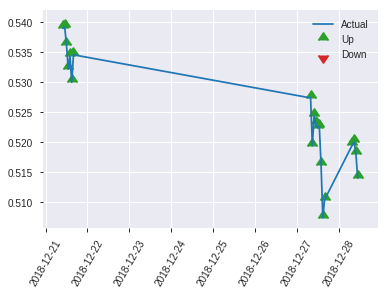


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24883969596400013
RMSE: 0.49883834652520465
LogLoss: 0.6908251227476366
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 303.6762860419698
Residual deviance: 303.9630540089601
AIC: 405.9630540089601
AUC: 0.5182335229173637
pr_auc: 0.4785145603222634
Gini: 0.036467045834727374
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44013384964869445: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    120  0.9836   (120.0/122.0)
1      0    98   0        (0.0/98.0)
Total  2    218  0.5455   (120.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440134     0.620253  217
max f2                       0.440134     0.803279  217
max f0point5                 0.467689     0.508906  171
max accuracy                 0.524485     0.577273  28
max precision                0.552519     0.75      3
max recall                   0.440134     1         217
max specificity              0.574378     0.991803  0
max absolute_mcc             0.543293     0.119031  7
max min_per_class_accuracy   0.489806     0.491803  110
max mean_per_class_accuracy  0.524485     0.537554  28

Gains/Lift Table: Avg response rate: 44.55 %, avg score: 49.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.5558             1.4966    1.4966             0.666667         0.564167  0.666667                    0.564167            0.0204082       0.0204082                  49.6599   49.6599
    2        0.0227273                   0.547243           1.12245   1.34694            0.5              0.550302  0.6                         0.558621            0.0102041       0.0306122                  12.2449   34.6939
    3        0.0318182                   0.544218           2.2449    1.6035             1                0.545657  0.714286                    0.554917            0.0204082       0.0510204                  124.49    60.3499
    4        0.0409091                   0.542893           1.12245   1.4966             0.5              0.543275  0.666667                    0.55233             0.0102041       0.0612245                  12.2449   49.6599
    5        0.05                        0.53974            1.12245   1.42857            0.5              0.541855  0.636364                    0.550425            0.0102041       0.0714286                  12.2449   42.8571
    6        0.1                         0.532171           1.02041   1.22449            0.454545         0.537575  0.545455                    0.544               0.0510204       0.122449                   2.04082   22.449
    7        0.15                        0.520204           1.22449   1.22449            0.545455         0.526411  0.545455                    0.538137            0.0612245       0.183673                   22.449    22.449
    8        0.2                         0.513702           0.408163  1.02041            0.181818         0.517832  0.454545                    0.533061            0.0204082       0.204082                   -59.1837  2.04082
    9        0.3                         0.502471           1.12245   1.05442            0.5              0.508295  0.469697                    0.524805            0.112245        0.316327                   12.2449   5.44218
    10       0.4                         0.494756           1.02041   1.04592            0.454545         0.49816   0.465909                    0.518144            0.102041        0.418367                   2.04082   4.59184
    11       0.5                         0.490037           0.714286  0.979592           0.318182         0.491973  0.436364                    0.51291             0.0714286       0.489796                   -28.5714  -2.04082
    12       0.6                         0.480783           0.918367  0.969388           0.409091         0.48574   0.431818                    0.508382            0.0918367       0.581633                   -8.16327  -3.06122
    13       0.7                         0.47176            1.32653   1.02041            0.590909         0.475853  0.454545                    0.503735            0.132653        0.714286                   32.6531   2.04082
    14       0.8                         0.466771           1.02041   1.02041            0.454545         0.469367  0.454545                    0.499439            0.102041        0.816327                   2.04082   2.04082
    15       0.9                         0.458633           0.714286  0.986395           0.318182         0.463432  0.439394                    0.495438            0.0714286       0.887755                   -28.5714  -1.36054
    16       1                           0.435496           1.12245   1                  0.5              0.448827  0.445455                    0.490777        

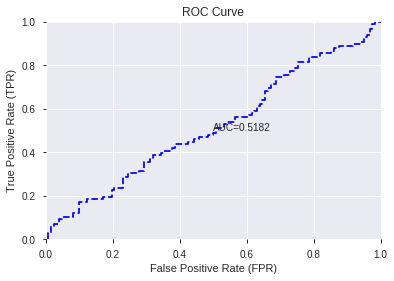

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


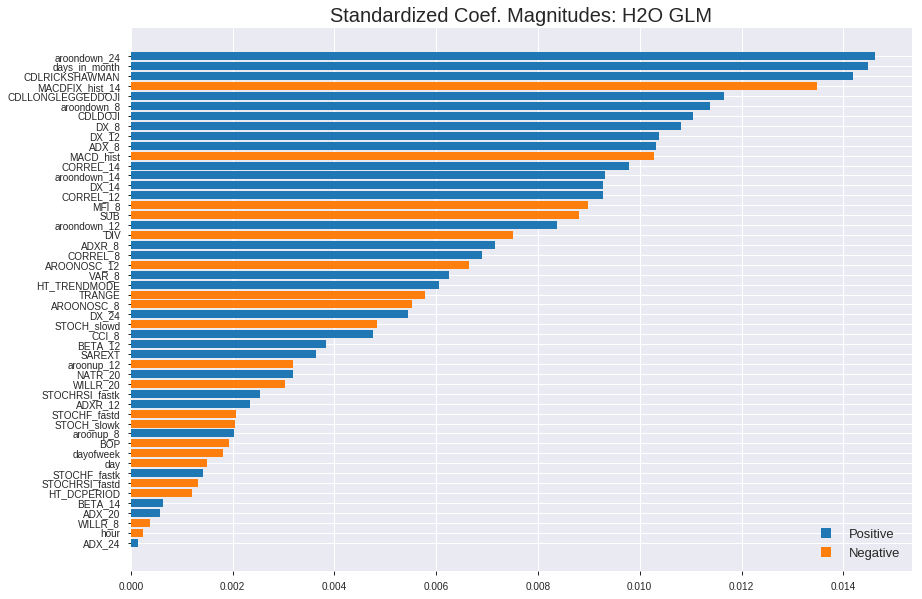

'log_likelihood'
--2019-08-28 17:17:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_171712_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_171712_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b253',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['aroondown_24',
 'days_in_month',
 'CDLRICKSHAWMAN',
 'MACDFIX_hist_14',
 'CDLLONGLEGGEDDOJI',
 'aroondown_8',
 'CDLDOJI',
 'DX_8',
 'DX_12',
 'ADX_8',
 'MACD_hist',
 'CORREL_14',
 'aroondown_14',
 'DX_14',
 'CORREL_12',
 'MFI_8',
 'SUB',
 'aroondown_12',
 'DIV',
 'ADXR_8',
 'CORREL_8',
 'AROONOSC_12',
 'VAR_8',
 'HT_TRENDMODE',
 'TRANGE',
 'AROONOSC_8',
 'DX_24',
 'STOCH_slowd',
 'CCI_8',
 'BETA_12',
 'SAREXT',
 'aroonup_12',
 'NATR_20',
 'WILLR_20',
 'STOCHRSI_fastk',
 'ADXR_12',
 'STOCHF_fastd',
 'STOCH_slowk',
 'aroonup_8',
 'BOP',
 'dayofweek',
 'day',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'HT_DCPERIOD',
 'BETA_14',
 'ADX_20',
 'WILLR_8',
 'hour',
 'ADX_24']

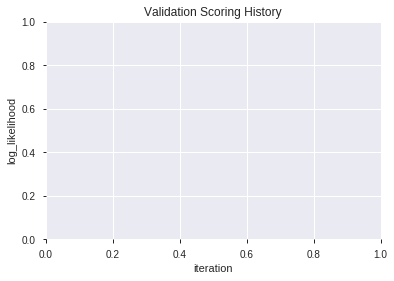

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_171728_model_1  0.547842  0.695992              0.484610  0.501275  0.251277
1  XGBoost_grid_1_AutoML_20190828_171728_model_4  0.540314  0.693450              0.491803  0.500109  0.250109
2  XGBoost_grid_1_AutoML_20190828_171728_model_2  0.528103  0.701857              0.489712  0.504134  0.254152
3               XGBoost_3_AutoML_20190828_171728  0.514804  0.710805              0.495902  0.508456  0.258528
4               XGBoost_1_AutoML_20190828_171728  0.514135  0.709555              0.483523  0.507684  0.257743
5  XGBoost_grid_1_AutoML_20190828_171728_model_3  0.509535  0.701960              0.491803  0.504251  0.254269
6  XGBoost_grid_1_AutoML_20190828_171728_model_5  0.509033  0.738992              0.480512  0.519611  0.269996
7               XGBoost_2_AutoML_20190828_171728  0.504767  0.710746              0.495902  0.508386  0.258456
8  XGBoost_grid_1_AutoML_20190828_171728_model_7  0.494731  0.728957              0.491803  0.516479  0.266750
9  XGBoost_grid_1_AutoML_20190828_171728_model_6  0.484527  0.722888              0.484610  0.514038  0.264235

variable  relative_importance  scaled_importance  percentage
0       STOCH_slowd           218.393875           1.000000    0.043228
1             ADX_8           205.598587           0.941412    0.040695
2             MFI_8           198.123276           0.907183    0.039215
3            ADX_20           197.699905           0.905245    0.039132
4            ADXR_8           181.002975           0.828791    0.035827
5       HT_DCPERIOD           178.539841           0.817513    0.035339
6   MACDFIX_hist_14           175.269135           0.802537    0.034692
7             VAR_8           167.618820           0.767507    0.033178
8           BETA_14           159.145889           0.728710    0.031500
9    STOCHRSI_fastd           157.604553           0.721653    0.031195
10              BOP           154.877335           0.709165    0.030656
11           ADX_24           151.796219           0.695057    0.030046
12          NATR_20           151.707199           0.694650    0.030028
13          BETA_12           141.740997           0.649015    0.028055
14        MACD_hist           140.560318           0.643609    0.027822
15           SAREXT           136.356079           0.624359    0.026990
16             DX_8           135.774689           0.621696    0.026874
17          ADXR_12           126.694481           0.580119    0.025077
18         WILLR_20           122.337090           0.560167    0.024215
19        CORREL_12           122.121185           0.559179    0.024172
20            DX_14           121.761986           0.557534    0.024101
21            DX_12           119.291336           0.546221    0.023612
22              DIV           110.560028           0.506241    0.021884
23      aroondown_8           107.369240           0.491631    0.021252
24          WILLR_8           102.286133           0.468356    0.020246
25              SUB            95.826721           0.438779    0.018967
26           TRANGE            92.713852           0.424526    0.018351
27        aroonup_8            90.172478           0.412889    0.017848
28     STOCHF_fastk            88.508141           0.405268    0.017519
29        CORREL_14            88.011436           0.402994    0.017420
30      AROONOSC_12            87.040573           0.398549    0.017228
31             hour            84.582077           0.387291    0.016742
32              day            76.887741           0.352060    0.015219
33            CCI_8            75.574974           0.346049    0.014959
34            DX_24            73.887955           0.338324    0.014625
35       aroonup_12            65.640228           0.300559    0.012992
36      STOCH_slowk            63.156437           0.289186    0.012501
37   STOCHRSI_fastk            47.005562           0.215233    0.009304
38       AROONOSC_8            42.827282           0.196101    0.008477
39     aroondown_24            35.101547           0.160726    0.006948
40     aroondown_14            34.593826           0.158401    0.006847
41     STOCHF_fastd            29.274776           0.134046    0.005794
42         CORREL_8            23.451857           0.107383    0.004642
43     aroondown_12            22.112301           0.101250    0.004377
44        dayofweek            17.285828           0.079150    0.003421
45   CDLRICKSHAWMAN            16.016634           0.073338    0.003170
46    days_in_month            14.437205           0.066106    0.002858
47          CDLDOJI             3.842043           0.017592    0.000760

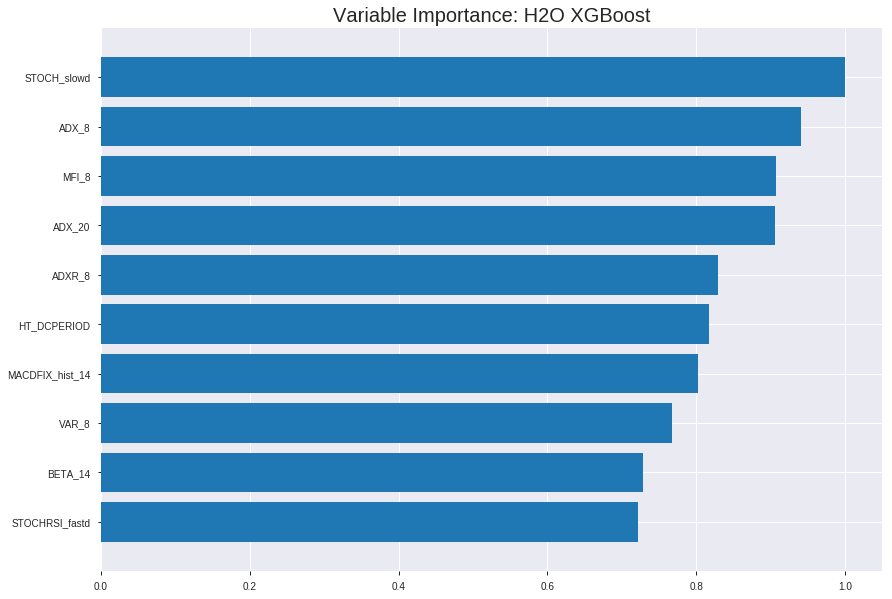

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_171728_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17211125670501884
RMSE: 0.41486293725159257
LogLoss: 0.5324747591300845
Mean Per-Class Error: 0.10721277376728255
AUC: 0.956395210517014
pr_auc: 0.9545454820987901
Gini: 0.9127904210340281
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4708865284919739: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      671  121  0.1528   (121.0/792.0)
1      46   697  0.0619   (46.0/743.0)
Total  717  818  0.1088   (167.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.470887     0.893017  208
max f2                       0.460857     0.921773  218
max f0point5                 0.514842     0.901736  171
max accuracy                 0.491881     0.891857  190
max precision                0.78685      1         0
max recall                   0.34835      1         321
max specificity              0.78685      1         0
max absolute_mcc             0.470887     0.786615  208
max min_per_class_accuracy   0.491881     0.890983  190
max mean_per_class_accuracy  0.477959     0.892787  202

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 48.53 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.71681            2.06595    2.06595            1                0.734599  1                           0.734599            0.0215343       0.0215343                  106.595   106.595
    2        0.0201954                   0.698649           2.06595    2.06595            1                0.708495  1                           0.721968            0.0201884       0.0417227                  106.595   106.595
    3        0.0306189                   0.68914            2.06595    2.06595            1                0.694218  1                           0.712521            0.0215343       0.0632571                  106.595   106.595
    4        0.0403909                   0.681601           2.06595    2.06595            1                0.684425  1                           0.705724            0.0201884       0.0834455                  106.595   106.595
    5        0.0501629                   0.67769            2.06595    2.06595            1                0.67945   1                           0.700606            0.0201884       0.103634                   106.595   106.595
    6        0.100326                    0.644198           2.06595    2.06595            1                0.658601  1                           0.679603            0.103634        0.207268                   106.595   106.595
    7        0.150489                    0.618442           2.06595    2.06595            1                0.629725  1                           0.662977            0.103634        0.310902                   106.595   106.595
    8        0.2                         0.597322           1.9844     2.04576            0.960526         0.607409  0.990228                    0.649221            0.0982503       0.409152                   98.4398   104.576
    9        0.300326                    0.561168           1.94521    2.01217            0.941558         0.579302  0.97397                     0.625864            0.195155        0.604307                   94.5212   101.217
    10       0.4                         0.526492           1.67436    1.92799            0.810458         0.544218  0.933225                    0.605519            0.166891        0.771198                   67.4364   92.7995
    11       0.500326                    0.4872             1.30128    1.80233            0.62987          0.505697  0.872396                    0.585503            0.130552        0.90175                    30.1279   80.2325
    12       0.6                         0.44429            0.567123   1.59713            0.27451          0.46408   0.773073                    0.565332            0.0565276       0.958277                   -43.2877  59.7129
    13       0.699674                    0.411435           0.270059   1.40808            0.130719         0.428079  0.681564                    0.545779            0.0269179       0.985195                   -72.9941  40.8077
    14       0.8                         0.374447           0.107322   1.24495            0.0519481        0.39346   0.602606                    0.526677            0.0107672       0.995962                   -89.2678  24.4953
    15       0.899674                    0.329189           0.0405088  1.11151            0.0196078        0.352982  0.538016                    0.507433            0.00403769      1                          -95.9491  11.1513
    16       1                           0.190827           0          1                  0                0.286763  0.484039                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25754635558208516
RMSE: 0.5074902517113853
LogLoss: 0.7088759803238991
Mean Per-Class Error: 0.46732394366197183
AUC: 0.5028064684402712
pr_auc: 0.5085135268617552
Gini: 0.0056129368805424296
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31511127948760986: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    206  0.9671   (206.0/213.0)
1      3    222  0.0133   (3.0/225.0)
Total  10   428  0.4772   (209.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.315111     0.679939   389
max f2                       0.25567      0.840807   399
max f0point5                 0.412611     0.575868   319
max accuracy                 0.412611     0.541096   319
max precision                0.702237     1          0
max recall                   0.25567      1          399
max specificity              0.702237     1          0
max absolute_mcc             0.412611     0.0829659  319
max min_per_class_accuracy   0.489785     0.492958   199
max mean_per_class_accuracy  0.412611     0.532676   319

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 48.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.676367           1.168     1.168              0.6              0.688388  0.6                         0.688388            0.0133333       0.0133333                  16.8       16.8
    2        0.0205479                   0.65811            0.486667  0.865185           0.25             0.665617  0.444444                    0.678267            0.00444444      0.0177778                  -51.3333   -13.4815
    3        0.0319635                   0.645475           1.168     0.973333           0.6              0.654202  0.5                         0.669672            0.0133333       0.0311111                  16.8       -2.66667
    4        0.0410959                   0.640408           0.973333  0.973333           0.5              0.64308   0.5                         0.663763            0.00888889      0.04                       -2.66667   -2.66667
    5        0.0502283                   0.632362           1.46      1.06182            0.75             0.638894  0.545455                    0.659241            0.0133333       0.0533333                  46         6.18182
    6        0.100457                    0.605934           0.619394  0.840606           0.318182         0.620607  0.431818                    0.639924            0.0311111       0.0844444                  -38.0606   -15.9394
    7        0.150685                    0.590647           1.32727   1.00283            0.681818         0.59804   0.515152                    0.625963            0.0666667       0.151111                   32.7273    0.282828
    8        0.200913                    0.565583           0.884848  0.973333           0.454545         0.577448  0.5                         0.613834            0.0444444       0.195556                   -11.5152   -2.66667
    9        0.30137                     0.532251           1.06182   1.00283            0.545455         0.548422  0.515152                    0.59203             0.106667        0.302222                   6.18182    0.282828
    10       0.399543                    0.511963           0.995969  1.00114            0.511628         0.521496  0.514286                    0.574699            0.0977778       0.4                        -0.403101  0.114286
    11       0.5                         0.489405           0.929091  0.986667           0.477273         0.501019  0.506849                    0.559896            0.0933333       0.493333                   -7.09091   -1.33333
    12       0.600457                    0.467462           1.1503    1.01404            0.590909         0.479799  0.520913                    0.546495            0.115556        0.608889                   15.0303    1.40431
    13       0.69863                     0.440929           1.04124   1.01786            0.534884         0.453252  0.522876                    0.533393            0.102222        0.711111                   4.12403    1.78649
    14       0.799087                    0.416274           1.1503    1.03451            0.590909         0.428899  0.531429                    0.520256            0.115556        0.826667                   15.0303    3.45143
    15       0.899543                    0.371172           0.707879  0.998037           0.363636         0.393121  0.51269                     0.506058            0.0711111       0.897778                   -29.2121   -0.196277
    16       1                           0.25567            1.01758   1                  0.522727         0.332636  0.513699            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:17:33  0.016 sec   0                  0.5              0.693147            0.5             0                  1                0.515961                         0.5                0.693147              0.5               0                    1                  0.486301
    2019-08-28 17:17:33  0.126 sec   5                  0.485678         0.664837            0.813816        0.79641            1.94442          0.27557                          0.499926           0.693008              0.525175          0.541893             1.55733            0.486301
    2019-08-28 17:17:33  0.198 sec   10                 0.473866         0.641945            0.860843        0.853777           2.06595          0.220847                         0.50165            0.696488              0.505529          0.516028             0.778667           0.484018
    2019-08-28 17:17:33  0.264 sec   15                 0.46321          0.621581            0.887523        0.879683           2.06595          0.219544                         0.503043           0.699319              0.492478          0.509129             0.389333           0.484018
    2019-08-28 17:17:33  0.331 sec   20                 0.453388         0.603085            0.910799        0.906039           2.06595          0.164821                         0.503642           0.700586              0.494637          0.50934              1.168              0.486301
    2019-08-28 17:17:33  0.400 sec   25                 0.444344         0.586101            0.91778         0.913975           2.06595          0.1557                           0.504887           0.703255              0.499186          0.503491             0.389333           0.486301
    2019-08-28 17:17:33  0.464 sec   30                 0.438457         0.575145            0.925141        0.92203            2.06595          0.143974                         0.505344           0.704214              0.500042          0.506801             0.778667           0.484018
    2019-08-28 17:17:33  0.536 sec   35                 0.432049         0.563471            0.936222        0.932529           2.06595          0.132899                         0.506435           0.706501              0.497371          0.498824             0.778667           0.481735
    2019-08-28 17:17:33  0.604 sec   40                 0.425704         0.552006            0.944597        0.943123           2.06595          0.11987                          0.50724            0.708319              0.500772          0.499314             0.778667           0.484018
    2019-08-28 17:17:33  0.665 sec   45                 0.420683         0.542908            0.950668        0.949262           2.06595          0.115309                         0.507148           0.708108              0.502608          0.506288             1.168              0.484018
    2019-08-28 17:17:33  0.729 sec   50                 0.414863         0.532475            0.956395        0.954545           2.06595          0.108795                         0.50749            0.708876              0.502806          0.508514             1.168              0.477169

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ---------------------
STOCH_slowd     218.3938751220703      1.0                  0.04322762862600575
ADX_8           205.5985870361328      0.9414118730262667   0.04069500283129194
MFI_8           198.12327575683594     0.9071832973616856   0.03921538267406628
ADX_20          197.6999053955078      0.9052447340155685   0.03913158317767235
ADXR_8          181.0029754638672      0.8287914455599835   0.03582668881707743
---             ---                    ---                  ---
aroondown_12    22.112300872802734     0.10124963834467958  0.004376781764881201
dayofweek       17.28582763671875      0.07914978214044195  0.003421457388196287
CDLRICKSHAWMAN  16.016633987426758     0.07333829292819832  0.003170240490765381
days_in_month   14.43720531463623      0.06610627384383659  0.0028576174555704054
CDLDOJI         3.842042922973633      0.01759226498832048  0.0007604718976054011


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5636363636363636)

('F1', 0.6217948717948718)

('auc', 0.547842087654734)

('logloss', 0.695992033702172)

('mean_per_class_error', 0.4431247908999665)

('rmse', 0.5012754540757544)

('mse', 0.2512770808588537)

xgboost prediction progress: |████████████████████████████████████████████| 100%


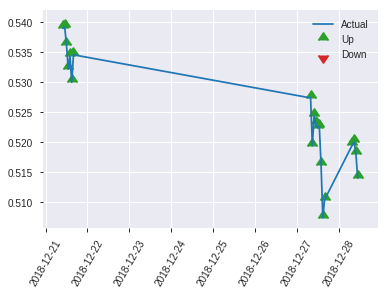


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2512770808588537
RMSE: 0.5012754540757544
LogLoss: 0.695992033702172
Mean Per-Class Error: 0.4431247908999665
AUC: 0.547842087654734
pr_auc: 0.47536708831028485
Gini: 0.09568417530946793
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30586153268814087: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    117  0.959    (117.0/122.0)
1      1    97   0.0102   (1.0/98.0)
Total  6    214  0.5364   (118.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.305862     0.621795  213
max f2                       0.262072     0.801964  218
max f0point5                 0.439385     0.524934  165
max accuracy                 0.701271     0.563636  1
max precision                0.717299     1         0
max recall                   0.262072     1         218
max specificity              0.717299     1         0
max absolute_mcc             0.439385     0.128665  165
max min_per_class_accuracy   0.500036     0.54918   108
max mean_per_class_accuracy  0.4573       0.556875  149

Gains/Lift Table: Avg response rate: 44.55 %, avg score: 49.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.695559           1.4966    1.4966             0.666667         0.705814  0.666667                    0.705814            0.0204082       0.0204082                  49.6599   49.6599
    2        0.0227273                   0.672885           1.12245   1.34694            0.5              0.679896  0.6                         0.695447            0.0102041       0.0306122                  12.2449   34.6939
    3        0.0318182                   0.659482           1.12245   1.2828             0.5              0.662487  0.571429                    0.68603             0.0102041       0.0408163                  12.2449   28.2799
    4        0.0409091                   0.648955           0         0.997732           0                0.65431   0.444444                    0.678981            0               0.0408163                  -100      -0.226757
    5        0.05                        0.642988           0         0.816327           0                0.64594   0.363636                    0.672973            0               0.0408163                  -100      -18.3673
    6        0.1                         0.612345           1.22449   1.02041            0.545455         0.627378  0.454545                    0.650176            0.0612245       0.102041                   22.449    2.04082
    7        0.15                        0.596157           1.22449   1.08844            0.545455         0.600569  0.484848                    0.63364             0.0612245       0.163265                   22.449    8.84354
    8        0.2                         0.578788           0.816327  1.02041            0.363636         0.587705  0.454545                    0.622157            0.0408163       0.204082                   -18.3673  2.04082
    9        0.3                         0.551875           1.32653   1.12245            0.590909         0.56493   0.5                         0.603081            0.132653        0.336735                   32.6531   12.2449
    10       0.4                         0.526226           0.816327  1.04592            0.363636         0.542139  0.465909                    0.587845            0.0816327       0.418367                   -18.3673  4.59184
    11       0.5                         0.49859            1.32653   1.10204            0.590909         0.511905  0.490909                    0.572657            0.132653        0.55102                    32.6531   10.2041
    12       0.6                         0.476279           0.918367  1.07143            0.409091         0.485611  0.477273                    0.55815             0.0918367       0.642857                   -8.16327  7.14286
    13       0.7                         0.454075           1.02041   1.06414            0.454545         0.464833  0.474026                    0.544819            0.102041        0.744898                   2.04082   6.41399
    14       0.8                         0.429058           0.918367  1.04592            0.409091         0.440345  0.465909                    0.531759            0.0918367       0.836735                   -8.16327  4.59184
    15       0.9                         0.379125           0.918367  1.03175            0.409091         0.405103  0.459596                    0.517687            0.0918367       0.928571                   -8.16327  3.1746
    16       1                           0.259833           0.714286  1                  0.318182         0.327444  0.445455                    0.498662       

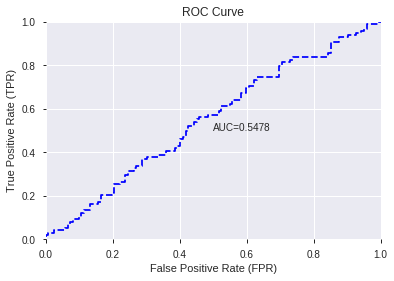

This function is available for GLM models only


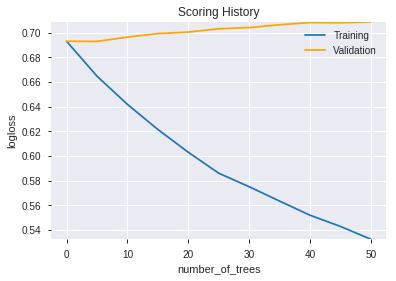

--2019-08-28 17:17:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.102.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.102.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setLeftChild(SharedTreeNode.java:207)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeLeftEdge(SharedTreeSubgraph.java:82)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeLeftChildN

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_171728_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_171728_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b253',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['STOCH_slowd',
 'ADX_8',
 'MFI_8',
 'ADX_20',
 'ADXR_8',
 'HT_DCPERIOD',
 'MACDFIX_hist_14',
 'VAR_8',
 'BETA_14',
 'STOCHRSI_fastd',
 'BOP',
 'ADX_24',
 'NATR_20',
 'BETA_12',
 'MACD_hist',
 'SAREXT',
 'DX_8',
 'ADXR_12',
 'WILLR_20',
 'CORREL_12',
 'DX_14',
 'DX_12',
 'DIV',
 'aroondown_8',
 'WILLR_8',
 'SUB',
 'TRANGE',
 'aroonup_8',
 'STOCHF_fastk',
 'CORREL_14',
 'AROONOSC_12',
 'hour',
 'day',
 'CCI_8',
 'DX_24',
 'aroonup_12',
 'STOCH_slowk',
 'STOCHRSI_fastk',
 'AROONOSC_8',
 'aroondown_24',
 'aroondown_14',
 'STOCHF_fastd',
 'CORREL_8',
 'aroondown_12',
 'dayofweek',
 'CDLRICKSHAWMAN',
 'days_in_month',
 'CDLDOJI']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 898 915 934] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190828_171759  0.524339  0.744838              0.495902  0.509543  0.259634
1  DeepLearning_grid_1_AutoML_20190828_171759_model_5  0.517732  0.693401              0.495902  0.500126  0.250126
2  DeepLearning_grid_1_AutoML_20190828_171759_model_3  0.510120  0.794365              0.500000  0.542712  0.294536
3  DeepLearning_grid_1_AutoML_20190828_171759_model_2  0.506691  0.768604              0.475410  0.534290  0.285466
4  DeepLearning_grid_1_AutoML_20190828_171759_model_8  0.500000  0.690955              0.500000  0.498903  0.248904
5  DeepLearning_grid_1_AutoML_20190828_171759_model_6  0.500000  0.691264              0.500000  0.499058  0.249058
6  DeepLearning_grid_1_AutoML_20190828_171759_model_7  0.495483  0.722569              0.491803  0.514355  0.264561
7  DeepLearning_grid_1_AutoML_20190828_171759_model_1  0.488792  3.007396              0.500000  0.639338  0.408753
8  DeepLearning_grid_1_AutoML_20190828_171759_model_9  0.472232  0.691730              0.500000  0.499291  0.249292
9  DeepLearning_grid_1_AutoML_20190828_171759_model_4  0.432503  0.834974              0.500000  0.545954  0.298066

variable  relative_importance  scaled_importance  percentage
0          CDLGAPSIDESIDEWHITE             1.000000           1.000000    0.002056
1                          BOP             0.942090           0.942090    0.001937
2                          day             0.927904           0.927904    0.001908
3                  aroondown_8             0.903767           0.903767    0.001858
4               CDLSPINNINGTOP             0.862450           0.862450    0.001773
...                        ...                  ...                ...         ...
1028                   ROCR_24             0.269815           0.269815    0.000555
1029    BBANDS_upperband_8_1_3             0.262112           0.262112    0.000539
1030  BBANDS_middleband_30_1_3             0.259493           0.259493    0.000534
1031        LINEARREG_SLOPE_14             0.251286           0.251286    0.000517
1032   BBANDS_upperband_30_0_4             0.226641           0.226641    0.000466

[1033 rows x 4 columns]

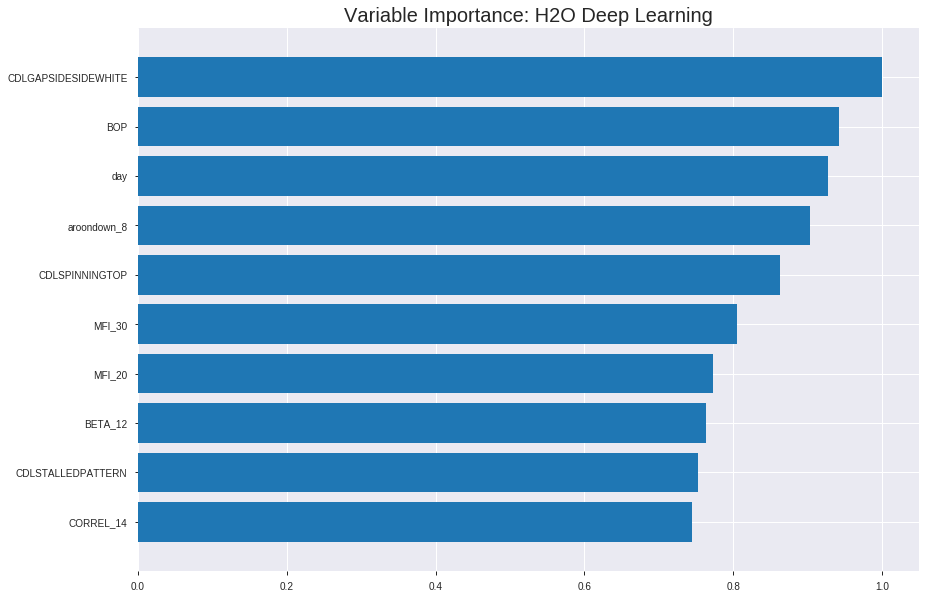

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190828_171759


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2735522863241373
RMSE: 0.5230222617863768
LogLoss: 0.7809631780100157
Mean Per-Class Error: 0.42036193020378754
AUC: 0.6032056772299034
pr_auc: 0.6166015084400052
Gini: 0.20641135445980674
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.03521698028056621: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      29   763   0.9634   (763.0/792.0)
1      3    740   0.004    (3.0/743.0)
Total  32   1503  0.499    (766.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.035217     0.658949  386
max f2                       0.0256983    0.827394  391
max f0point5                 0.210004     0.561417  283
max accuracy                 0.412496     0.586971  148
max precision                0.971648     1         0
max recall                   0.0256983    1         391
max specificity              0.971648     1         0
max absolute_mcc             0.536891     0.208068  85
max min_per_class_accuracy   0.314355     0.55303   219
max mean_per_class_accuracy  0.409775     0.579638  150

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 31.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.889067           1.93683   1.93683            0.9375           0.927218   0.9375                      0.927218            0.0201884       0.0201884                  93.6827   93.6827
    2        0.0201954                   0.81291            1.92822   1.93266            0.933333         0.852861   0.935484                    0.891239            0.0188425       0.039031                   92.8219   93.2662
    3        0.0306189                   0.769329           1.67858   1.84617            0.8125           0.789052   0.893617                    0.856452            0.0174966       0.0565276                  67.8583   84.6167
    4        0.0403909                   0.708054           1.3773    1.73273            0.666667         0.735023   0.83871                     0.827074            0.013459        0.0699865                  37.7299   73.2731
    5        0.0501629                   0.659019           1.79049   1.74398            0.866667         0.683195   0.844156                    0.799046            0.0174966       0.0874832                  79.0489   74.3983
    6        0.100326                    0.530913           1.47568   1.60983            0.714286         0.582402   0.779221                    0.690724            0.0740242       0.161507                   47.5678   60.983
    7        0.150489                    0.463965           1.20737   1.47568            0.584416         0.492814   0.714286                    0.624754            0.0605653       0.222073                   20.7373   47.5678
    8        0.2                         0.434214           1.03297   1.36608            0.5              0.448357   0.661238                    0.581085            0.051144        0.273217                   3.29744   36.6083
    9        0.300326                    0.393503           1.04639   1.25929            0.506494         0.41453    0.609544                    0.525447            0.10498         0.378197                   4.63897   25.9288
    10       0.4                         0.35027            0.850685  1.15747            0.411765         0.372689   0.560261                    0.487382            0.0847914       0.462988                   -14.9315  15.747
    11       0.500326                    0.313566           0.939068  1.11368            0.454545         0.331744   0.539062                    0.456173            0.0942127       0.557201                   -6.09323  11.3676
    12       0.6                         0.264963           0.972211  1.09017            0.470588         0.291624   0.527687                    0.428837            0.0969044       0.654105                   -2.77888  9.0175
    13       0.699674                    0.207627           1.06673   1.08684            0.51634          0.23586    0.526071                    0.401346            0.106326        0.760431                   6.67318   8.68353
    14       0.8                         0.142943           0.845161  1.05653            0.409091         0.172045   0.511401                    0.37259             0.0847914       0.845222                   -15.4839  5.65276
    15       0.899674                    0.0805232          0.823679  1.03073            0.398693         0.113623   0.498914                    0.343899            0.0820996       0.927322                   -17.6321  3.07305
    16       1                           0.00723654         0.724424  1                  0.350649         0.0509966  0.484039                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.31071785881462494
RMSE: 0.5574207197571911
LogLoss: 1.024123194928916
Mean Per-Class Error: 0.485226917057903
AUC: 0.48588419405320815
pr_auc: 0.4995419743620074
Gini: -0.028231611893583697
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0002489008311172114: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    211  0.9906   (211.0/213.0)
1      1    224  0.0044   (1.0/225.0)
Total  3    435  0.484    (212.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.000248901  0.678788   398
max f2                       0.000172691  0.840807   399
max f0point5                 0.000248901  0.569975   398
max accuracy                 0.200919     0.522831   318
max precision                0.577302     0.75       3
max recall                   0.000172691  1          399
max specificity              0.651587     0.995305   0
max absolute_mcc             0.338596     0.0703255  235
max min_per_class_accuracy   0.356325     0.478873   201
max mean_per_class_accuracy  0.200919     0.514773   318

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 31.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.546407           1.168     1.168              0.6              0.597759   0.6                         0.597759            0.0133333       0.0133333                  16.8      16.8
    2        0.0205479                   0.528795           0.973333  1.08148            0.5              0.53492    0.555556                    0.569831            0.00888889      0.0222222                  -2.66667  8.14815
    3        0.0319635                   0.504281           0.389333  0.834286           0.2              0.519736   0.428571                    0.55194             0.00444444      0.0266667                  -61.0667  -16.5714
    4        0.0410959                   0.4825             0.486667  0.757037           0.25             0.492273   0.388889                    0.53868             0.00444444      0.0311111                  -51.3333  -24.2963
    5        0.0502283                   0.479725           0.973333  0.796364           0.5              0.480366   0.409091                    0.528078            0.00888889      0.04                       -2.66667  -20.3636
    6        0.100457                    0.442963           1.06182   0.929091           0.545455         0.459357   0.477273                    0.493717            0.0533333       0.0933333                  6.18182   -7.09091
    7        0.150685                    0.427661           0.973333  0.943838           0.5              0.434888   0.484848                    0.474107            0.0488889       0.142222                   -2.66667  -5.61616
    8        0.200913                    0.416302           1.06182   0.973333           0.545455         0.421122   0.5                         0.460861            0.0533333       0.195556                   6.18182   -2.66667
    9        0.30137                     0.397339           1.01758   0.988081           0.522727         0.407302   0.507576                    0.443008            0.102222        0.297778                   1.75758   -1.19192
    10       0.399543                    0.375794           1.04124   1.00114            0.534884         0.386499   0.514286                    0.429123            0.102222        0.4                        4.12403   0.114286
    11       0.5                         0.355923           0.796364  0.96               0.409091         0.365763   0.493151                    0.416393            0.08            0.48                       -20.3636  -4
    12       0.600457                    0.337873           0.929091  0.954829           0.477273         0.346924   0.490494                    0.404771            0.0933333       0.573333                   -7.09091  -4.51711
    13       0.69863                     0.306118           1.2676    0.99878            0.651163         0.32366    0.513072                    0.393373            0.124444        0.697778                   26.7597   -0.122004
    14       0.799087                    0.188649           1.10606   1.01227            0.568182         0.284558   0.52                        0.379693            0.111111        0.808889                   10.6061   1.22667
    15       0.899543                    0.039835           0.884848  0.998037           0.454545         0.0987346  0.51269                     0.348317            0.0888889       0.897778                   -11.5152  -0.196277
    16       1                           0.000158674        1.01758   1                  0.522727         0.0105319  0.513699              


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:18:00  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 17:18:00  0.570 sec   8208 obs/sec      1         1             1535       0.607764         1.51236             -0.479015      0.525762        0.465185           1.54946          0.508143                         0.68652            3.23755               -0.886653        0.464768          0.486984             1.168              0.486301
    2019-08-28 17:18:02  2.471 sec   7795 obs/sec      10        10            15350      0.523022         0.780963            -0.0953253     0.603206        0.616602           1.93683          0.499023                         0.557421           1.02412               -0.243805        0.485884          0.499542             1.168              0.484018

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ----------------------
CDLGAPSIDESIDEWHITE       1.0                    1.0                  0.0020559932024431103
BOP                       0.9420897960662842     0.9420897960662842   0.0019369302168032964
day                       0.927904486656189      0.927904486656189    0.0019077653170815883
aroondown_8               0.9037665724754333     0.9037665724754333   0.0018581379296047995
CDLSPINNINGTOP            0.8624502420425415     0.8624502420425415   0.0017731918350848805
---                       ---                    ---                  ---
ROCR_24                   0.2698149085044861     0.2698149085044861   0.0005547376178030331
BBANDS_upperband_8_1_3    0.26211225986480713    0.26211225986480713  0.0005389010245590456
BBANDS_middleband_30_1_3  0.2594931721687317     0.2594931721687317   0.000533516198059312
LINEARREG_SLOPE_14        0.2512856423854828     0.2512856423854828   0.000516641572616103
BBANDS_upperband_30_0_4   0.22664104402065277    0.22664104402065277  0.00046597244590107186


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5818181818181818)

('F1', 0.6182965299684543)

('auc', 0.524339243894279)

('logloss', 0.7448382130216366)

('mean_per_class_error', 0.4553362328537973)

('rmse', 0.5095433397297687)

('mse', 0.25963441506296653)

deeplearning prediction progress: |███████████████████████████████████████| 100%


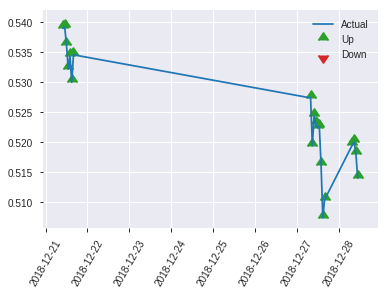


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25963441506296653
RMSE: 0.5095433397297687
LogLoss: 0.7448382130216366
Mean Per-Class Error: 0.4553362328537973
AUC: 0.524339243894279
pr_auc: 0.47330516704054953
Gini: 0.04867848778855799
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0024823396815401: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    121  0.9918   (121.0/122.0)
1      0    98   0        (0.0/98.0)
Total  1    219  0.55     (121.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00248234   0.618297  218
max f2                       0.00248234   0.801964  218
max f0point5                 0.305237     0.508475  181
max accuracy                 0.424507     0.581818  33
max precision                0.65493      1         0
max recall                   0.00248234   1         218
max specificity              0.65493      1         0
max absolute_mcc             0.424507     0.122824  33
max min_per_class_accuracy   0.362134     0.5       107
max mean_per_class_accuracy  0.424507     0.544664  33

Gains/Lift Table: Avg response rate: 44.55 %, avg score: 35.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.640999           1.4966    1.4966             0.666667         0.65407   0.666667                    0.65407             0.0204082       0.0204082                  49.6599   49.6599
    2        0.0227273                   0.56783            0         0.897959           0                0.580597  0.4                         0.62468             0               0.0204082                  -100      -10.2041
    3        0.0318182                   0.515624           0         0.641399           0                0.539882  0.285714                    0.600452            0               0.0204082                  -100      -35.8601
    4        0.0409091                   0.500703           2.2449    0.997732           1                0.509955  0.444444                    0.580342            0.0204082       0.0408163                  124.49    -0.226757
    5        0.05                        0.477635           1.12245   1.02041            0.5              0.491578  0.454545                    0.564203            0.0102041       0.0510204                  12.2449   2.04082
    6        0.1                         0.444356           1.63265   1.32653            0.727273         0.461519  0.590909                    0.512861            0.0816327       0.132653                   63.2653   32.6531
    7        0.15                        0.42539            1.22449   1.29252            0.545455         0.433938  0.575758                    0.486553            0.0612245       0.193878                   22.449    29.2517
    8        0.2                         0.412183           0.816327  1.17347            0.363636         0.417215  0.522727                    0.469219            0.0408163       0.234694                   -18.3673  17.3469
    9        0.3                         0.393586           0.816327  1.05442            0.363636         0.403066  0.469697                    0.447168            0.0816327       0.316327                   -18.3673  5.44218
    10       0.4                         0.379816           0.612245  0.943878           0.272727         0.386595  0.420455                    0.432025            0.0612245       0.377551                   -38.7755  -5.61224
    11       0.5                         0.359789           1.22449   1                  0.545455         0.369771  0.445455                    0.419574            0.122449        0.5                        22.449    0
    12       0.6                         0.344129           1.32653   1.05442            0.590909         0.350813  0.469697                    0.408114            0.132653        0.632653                   32.6531   5.44218
    13       0.7                         0.325092           0.612245  0.991254           0.272727         0.334782  0.441558                    0.397638            0.0612245       0.693878                   -38.7755  -0.874636
    14       0.8                         0.306835           1.22449   1.02041            0.545455         0.316009  0.454545                    0.387434            0.122449        0.816327                   22.449    2.04082
    15       0.9                         0.298889           0.918367  1.00907            0.409091         0.302506  0.449495                    0.377998            0.0918367       0.908163                   -8.16327  0.907029
    16       1                           0.0013862          0.918367  1                  0.409091         0.165653  0.445455                    0.356763       

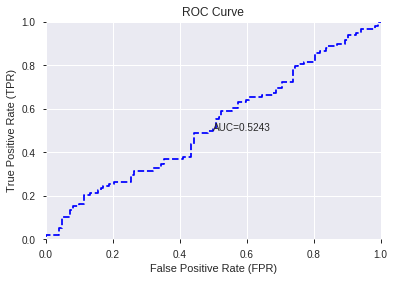

This function is available for GLM models only


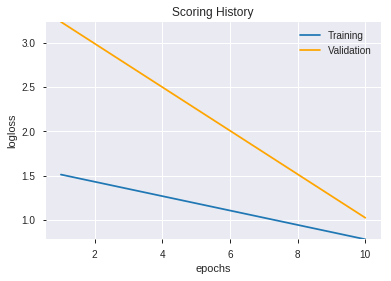

--2019-08-28 17:42:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.18.8
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.18.8|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190828_171759',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190828_171759',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b253',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_74_sid_b253'

['CDLGAPSIDESIDEWHITE',
 'BOP',
 'day',
 'aroondown_8',
 'CDLSPINNINGTOP',
 'MFI_30',
 'MFI_20',
 'BETA_12',
 'CDLSTALLEDPATTERN',
 'CORREL_14',
 'MAVP_24_7',
 'STOCHRSI_fastk',
 'STOCH_slowk',
 'SAREXT',
 'hour',
 'MFI_14',
 'STOCHRSI_fastd',
 'aroondown_12',
 'ATR_8',
 'MINUS_DM_12',
 'BBANDS_lowerband_30_7_3',
 'BBANDS_upperband_14_4_4',
 'CDLBELTHOLD',
 'STOCHF_fastd',
 'BBANDS_lowerband_20_7_4',
 'CDLLONGLINE',
 'BBANDS_lowerband_30_1_2',
 'MA_12_0',
 'MINMAX_max_20',
 'DX_12',
 'PLUS_DM_24',
 'ATR_24',
 'TSF_24',
 'days_in_month',
 'STOCHF_fastk',
 'Volume',
 'BBANDS_middleband_8_1_3',
 'BBANDS_lowerband_8_3_5',
 'BBANDS_middleband_8_8_4',
 'HT_PHASOR_inphase',
 'BETA_30',
 'BBANDS_upperband_30_5_5',
 'MIDPOINT_12',
 'BBANDS_upperband_20_3_5',
 'BBANDS_upperband_8_6_5',
 'HT_PHASOR_quadrature',
 'MA_24_6',
 'aroondown_24',
 'High',
 'CCI_30',
 'MINUS_DM_8',
 'BBANDS_lowerband_12_3_2',
 'MAVP_8_3',
 'BBANDS_lowerband_8_8_3',
 'LINEARREG_SLOPE_24',
 'CMO_24',
 'MA_8_0',
 'KAMA_24',

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_174353_model_1  0.490214  0.698618                   0.5  0.502691  0.252699

variable  relative_importance  scaled_importance    percentage
0              is_month_start         1.400819e-02           1.000000  1.327953e-02
1           CDLGRAVESTONEDOJI         1.396218e-02           0.996715  1.323591e-02
2                   CDLHARAMI         1.339584e-02           0.956286  1.269903e-02
3              CDLRICKSHAWMAN         1.289937e-02           0.920845  1.222839e-02
4               days_in_month         1.215331e-02           0.867586  1.152114e-02
...                       ...                  ...                ...           ...
1028  BBANDS_lowerband_12_2_5         3.281465e-06           0.000234  3.110775e-06
1029  BBANDS_middleband_8_7_2         2.099066e-06           0.000150  1.989879e-06
1030  BBANDS_lowerband_24_7_4         1.773911e-06           0.000127  1.681638e-06
1031                     mama         1.518851e-06           0.000108  1.439846e-06
1032                 MAVP_8_7         4.691117e-07           0.000033  4.447101e-07

[1033 rows x 4 columns]

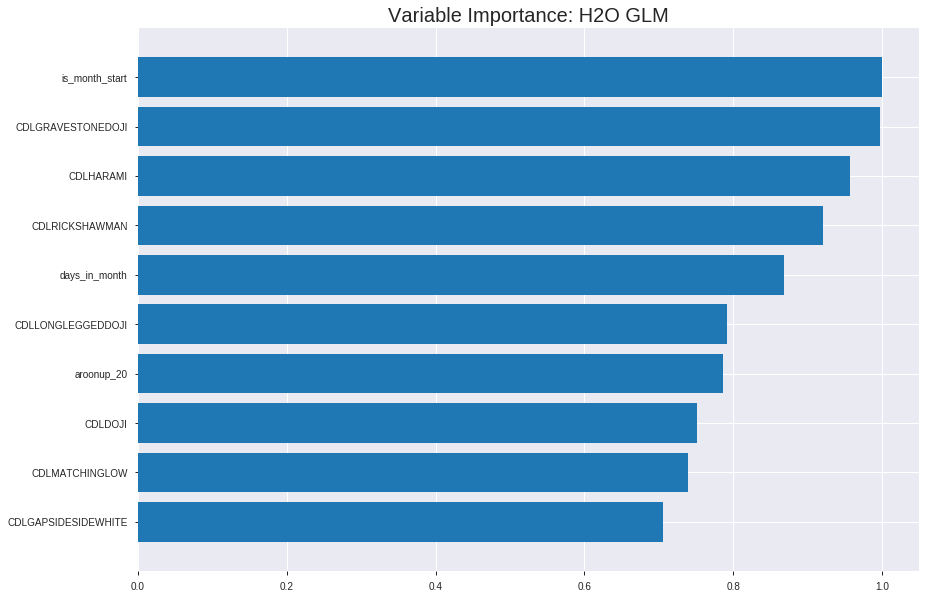

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_174353_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24396501312438476
RMSE: 0.4939281457098641
LogLoss: 0.681005713945241
Null degrees of freedom: 1534
Residual degrees of freedom: 501
Null deviance: 2126.397409180741
Residual deviance: 2090.68754181189
AIC: 4158.68754181189
AUC: 0.6057623679595416
pr_auc: 0.5716281303340536
Gini: 0.21152473591908327
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42643591282426757: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      49   743   0.9381   (743.0/792.0)
1      8    735   0.0108   (8.0/743.0)
Total  57   1478  0.4893   (751.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426436     0.661864  362
max f2                       0.426436     0.825843  362
max f0point5                 0.464234     0.571244  258
max accuracy                 0.481525     0.583062  212
max precision                0.607203     0.8       8
max recall                   0.386077     1         395
max specificity              0.636295     0.998737  0
max absolute_mcc             0.48086      0.164876  214
max min_per_class_accuracy   0.479076     0.577389  219
max mean_per_class_accuracy  0.48086      0.582387  214

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 48.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.598405           1.54946   1.54946            0.75             0.611826  0.75                        0.611826            0.0161507       0.0161507                  54.9462   54.9462
    2        0.0201954                   0.582076           0.964109  1.26623            0.466667         0.589718  0.612903                    0.601129            0.00942127      0.025572                   -3.58905  26.6227
    3        0.0306189                   0.570222           1.42034   1.31869            0.6875           0.575668  0.638298                    0.592461            0.0148048       0.0403769                  42.034    31.8691
    4        0.0403909                   0.562878           1.3773    1.33287            0.666667         0.566355  0.645161                    0.586145            0.013459        0.0538358                  37.7299   33.287
    5        0.0501629                   0.557276           1.65276   1.39519            0.8              0.560338  0.675325                    0.581118            0.0161507       0.0699865                  65.2759   39.5186
    6        0.100326                    0.539577           1.20737   1.30128            0.584416         0.547181  0.62987                     0.56415             0.0605653       0.130552                   20.7373   30.1279
    7        0.150489                    0.527985           1.34153   1.31469            0.649351         0.534079  0.636364                    0.554126            0.0672948       0.197847                   34.1525   31.4695
    8        0.2                         0.517675           1.03297   1.24495            0.5              0.522392  0.602606                    0.54627             0.051144        0.248991                   3.29744   24.4953
    9        0.300326                    0.502655           1.18054   1.22344            0.571429         0.50971   0.592191                    0.534057            0.118439        0.367429                   18.0542   22.3436
    10       0.4                         0.489361           1.08023   1.18775            0.522876         0.495511  0.574919                    0.524452            0.107672        0.475101                   8.02347   18.7752
    11       0.500326                    0.478581           1.0598    1.1621             0.512987         0.483647  0.5625                      0.51627             0.106326        0.581427                   5.98049   16.2096
    12       0.6                         0.468453           0.931702  1.12382            0.45098          0.473402  0.543974                    0.509148            0.0928668       0.674293                   -6.82976  12.3822
    13       0.699674                    0.459105           0.904697  1.09261            0.437908         0.463212  0.528864                    0.502604            0.090175        0.764468                   -9.53034  9.26061
    14       0.8                         0.449436           0.871991  1.06494            0.422078         0.454334  0.515472                    0.496551            0.0874832       0.851952                   -12.8009  6.49394
    15       0.899674                    0.438273           0.810176  1.03671            0.392157         0.444067  0.50181                     0.490736            0.0807537       0.932705                   -18.9824  3.67144
    16       1                           0.366701           0.670763  1                  0.324675         0.423982  0.484039                    0.484039          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25048690025578224
RMSE: 0.5004866634145032
LogLoss: 0.6941044267788348
Null degrees of freedom: 437
Residual degrees of freedom: -596
Null deviance: 608.4098651427188
Residual deviance: 608.0354778582592
AIC: 2676.035477858259
AUC: 0.520699008868023
pr_auc: 0.5401404436416889
Gini: 0.04139801773604601
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3968464348034753: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    209  0.9812   (209.0/213.0)
1      0    225  0        (0.0/225.0)
Total  4    434  0.4772   (209.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396846     0.682853  395
max f2                       0.396846     0.843328  395
max f0point5                 0.459087     0.58147   302
max accuracy                 0.459087     0.552511  302
max precision                0.620685     1         0
max recall                   0.396846     1         395
max specificity              0.620685     1         0
max absolute_mcc             0.58014      0.11814   9
max min_per_class_accuracy   0.487741     0.493333  198
max mean_per_class_accuracy  0.459087     0.54529   302

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 48.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.587846           1.55733   1.55733            0.8              0.60587   0.8                         0.60587             0.0177778       0.0177778                  55.7333   55.7333
    2        0.0205479                   0.580519           1.94667   1.73037            1                0.58248   0.888889                    0.595475            0.0177778       0.0355556                  94.6667   73.037
    3        0.0319635                   0.576194           1.168     1.52952            0.6              0.578046  0.785714                    0.58925             0.0133333       0.0488889                  16.8      52.9524
    4        0.0410959                   0.570026           0.973333  1.40593            0.5              0.572558  0.722222                    0.585541            0.00888889      0.0577778                  -2.66667  40.5926
    5        0.0502283                   0.565616           0.973333  1.32727            0.5              0.567492  0.681818                    0.582259            0.00888889      0.0666667                  -2.66667  32.7273
    6        0.100457                    0.550834           0.884848  1.10606            0.454545         0.557165  0.568182                    0.569712            0.0444444       0.111111                   -11.5152  10.6061
    7        0.150685                    0.537617           0.707879  0.973333           0.363636         0.545497  0.5                         0.56164             0.0355556       0.146667                   -29.2121  -2.66667
    8        0.200913                    0.527263           1.1503    1.01758            0.590909         0.532038  0.522727                    0.55424             0.0577778       0.204444                   15.0303   1.75758
    9        0.30137                     0.510298           0.884848  0.973333           0.454545         0.517967  0.5                         0.542149            0.0888889       0.293333                   -11.5152  -2.66667
    10       0.399543                    0.495644           1.08651   1.00114            0.55814          0.502359  0.514286                    0.532372            0.106667        0.4                        8.65116   0.114286
    11       0.5                         0.487296           0.929091  0.986667           0.477273         0.491525  0.506849                    0.524165            0.0933333       0.493333                   -7.09091  -1.33333
    12       0.600457                    0.474133           1.1503    1.01404            0.590909         0.481121  0.520913                    0.516964            0.115556        0.608889                   15.0303   1.40431
    13       0.69863                     0.464535           1.35814   1.0624             0.697674         0.469338  0.545752                    0.510271            0.133333        0.742222                   35.814    6.23965
    14       0.799087                    0.45594            0.884848  1.04008            0.454545         0.460545  0.534286                    0.50402             0.0888889       0.831111                   -11.5152  4.00762
    15       0.899543                    0.440257           0.796364  1.01286            0.409091         0.448198  0.520305                    0.497786            0.08            0.911111                   -20.3636  1.28596
    16       1                           0.358163           0.884848  1                  0.454545         0.417163  0.513699                    0.489687      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 17:43:56  0.000 sec   2            4.2       1034          1.37152           1.38942
    2019-08-28 17:43:58  1.971 sec   4            3         1034          1.36887           1.3891
    2019-08-28 17:44:00  3.991 sec   6            2.2       1034          1.36571           1.38852
    2019-08-28 17:44:02  5.982 sec   8            1.6       1034          1.36201           1.38821
    2019-08-28 17:44:04  7.975 sec   10           1.2       1034          1.35776           1.38823
    2019-08-28 17:44:06  9.997 sec   12           0.85      1034          1.35295           1.3887
    2019-08-28 17:44:08  12.038 sec  14           0.62      1034          1.34764           1.38979
    2019-08-28 17:44:10  14.159 sec  16           0.45      1034          1.34189           1.39163
    2019-08-28 17:44:12  16.175 sec  18           0.33      1034          1.33583           1.39441

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5818181818181818)

('F1', 0.6163522012578617)

('auc', 0.49021411843425894)

('logloss', 0.6986183852433837)

('mean_per_class_error', 0.46135831381733017)

('rmse', 0.5026914207837725)

('mse', 0.2526986645296078)

glm prediction progress: |████████████████████████████████████████████████| 100%


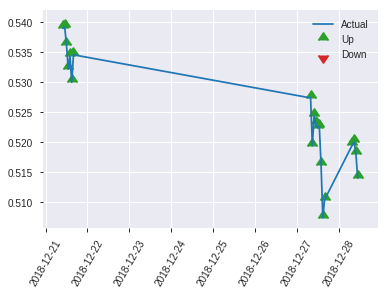


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2526986645296078
RMSE: 0.5026914207837725
LogLoss: 0.6986183852433837
Null degrees of freedom: 219
Residual degrees of freedom: -814
Null deviance: 303.6762860419698
Residual deviance: 307.3920895070888
AIC: 2375.3920895070887
AUC: 0.49021411843425894
pr_auc: 0.4669848818833651
Gini: -0.019571763131482123
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3898582899649598: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    122  1        (122.0/122.0)
1      0    98   0        (0.0/98.0)
Total  0    220  0.5545   (122.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.389858     0.616352  219
max f2                       0.389858     0.800654  219
max f0point5                 0.389858     0.501022  219
max accuracy                 0.562681     0.581818  19
max precision                0.599477     0.666667  2
max recall                   0.389858     1         219
max specificity              0.633055     0.991803  0
max absolute_mcc             0.433748     0.192961  204
max min_per_class_accuracy   0.495229     0.47541   110
max mean_per_class_accuracy  0.560234     0.538642  21

Gains/Lift Table: Avg response rate: 44.55 %, avg score: 49.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.597803           1.4966    1.4966             0.666667         0.620586  0.666667                    0.620586            0.0204082       0.0204082                  49.6599   49.6599
    2        0.0227273                   0.587092           0         0.897959           0                0.589358  0.4                         0.608095            0               0.0204082                  -100      -10.2041
    3        0.0318182                   0.58031            2.2449    1.2828             1                0.583446  0.571429                    0.601052            0.0204082       0.0408163                  124.49    28.2799
    4        0.0409091                   0.577945           0         0.997732           0                0.579102  0.444444                    0.596175            0               0.0408163                  -100      -0.226757
    5        0.05                        0.576203           2.2449    1.22449            1                0.5772    0.545455                    0.592725            0.0204082       0.0612245                  124.49    22.449
    6        0.1                         0.559742           1.63265   1.42857            0.727273         0.566879  0.636364                    0.579802            0.0816327       0.142857                   63.2653   42.8571
    7        0.15                        0.540409           0.612245  1.15646            0.272727         0.549335  0.515152                    0.569646            0.0306122       0.173469                   -38.7755  15.6463
    8        0.2                         0.533003           1.22449   1.17347            0.545455         0.536213  0.522727                    0.561288            0.0612245       0.234694                   22.449    17.3469
    9        0.3                         0.523953           0.816327  1.05442            0.363636         0.528321  0.469697                    0.550299            0.0816327       0.316327                   -18.3673  5.44218
    10       0.4                         0.511011           1.12245   1.07143            0.5              0.518022  0.477273                    0.54223             0.112245        0.428571                   12.2449   7.14286
    11       0.5                         0.495402           0.408163  0.938776           0.181818         0.504703  0.418182                    0.534724            0.0408163       0.469388                   -59.1837  -6.12245
    12       0.6                         0.485902           1.02041   0.952381           0.454545         0.490387  0.424242                    0.527335            0.102041        0.571429                   2.04082   -4.7619
    13       0.7                         0.473877           1.02041   0.962099           0.454545         0.479048  0.428571                    0.520437            0.102041        0.673469                   2.04082   -3.79009
    14       0.8                         0.459685           0.918367  0.956633           0.409091         0.465864  0.426136                    0.513615            0.0918367       0.765306                   -8.16327  -4.33673
    15       0.9                         0.442296           0.918367  0.952381           0.409091         0.452526  0.424242                    0.506827            0.0918367       0.857143                   -8.16327  -4.7619
    16       1                           0.389858           1.42857   1                  0.636364         0.424591  0.445455                    0.498604    

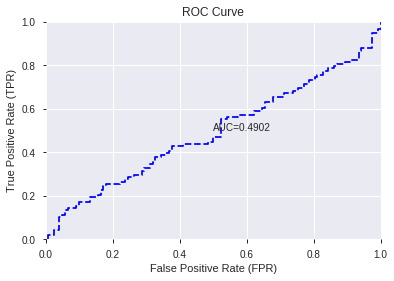

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


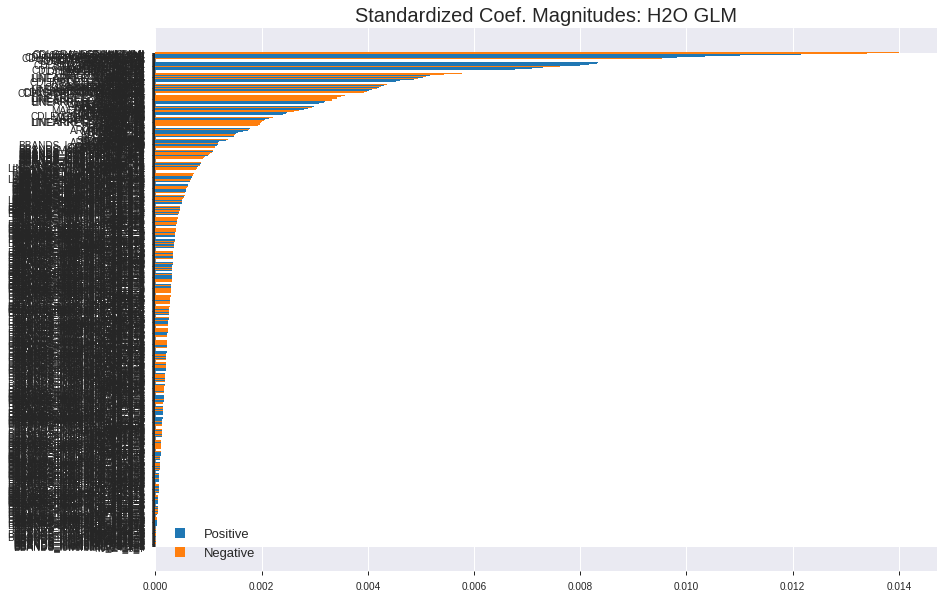

'log_likelihood'
--2019-08-28 17:44:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.239.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.239.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_174353_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_174353_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b253',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['is_month_start',
 'CDLGRAVESTONEDOJI',
 'CDLHARAMI',
 'CDLRICKSHAWMAN',
 'days_in_month',
 'CDLLONGLEGGEDDOJI',
 'aroonup_20',
 'CDLDOJI',
 'CDLMATCHINGLOW',
 'CDLGAPSIDESIDEWHITE',
 'CDLRISEFALL3METHODS',
 'CDLHIKKAKEMOD',
 'CDLHAMMER',
 'DX_8',
 'CDLHARAMICROSS',
 'CDL3WHITESOLDIERS',
 'aroondown_8',
 'CDLDRAGONFLYDOJI',
 'aroondown_20',
 'SUB',
 'aroondown_24',
 'DX_12',
 'DIV',
 'ADX_8',
 'CDLSTALLEDPATTERN',
 'CORREL_14',
 'Volume',
 'CDLEVENINGSTAR',
 'CDLSPINNINGTOP',
 'CDLTAKURI',
 'MACDFIX_hist_24',
 'CORREL_12',
 'MACDFIX_hist_20',
 'DX_14',
 'CDLSHORTLINE',
 'CDLSEPARATINGLINES',
 'MFI_20',
 'CDLLADDERBOTTOM',
 'CDLPIERCING',
 'aroonup_14',
 'MACDFIX_hist_14',
 'STDDEV_8',
 'TRANGE',
 'MFI_8',
 'MACDFIX_hist_12',
 'ADXR_8',
 'CORREL_30',
 'aroonup_24',
 'CORREL_8',
 'ADX_12',
 'LINEARREG_ANGLE_24',
 'LINEARREG_SLOPE_24',
 'SAREXT',
 'VAR_14',
 'MFI_24',
 'VAR_8',
 'DX_20',
 'MACD_hist',
 'MACDFIX_signal_24',
 'CCI_12',
 'CDLINVERTEDHAMMER',
 'CDL3LINESTRIKE',
 'WILLR_14',


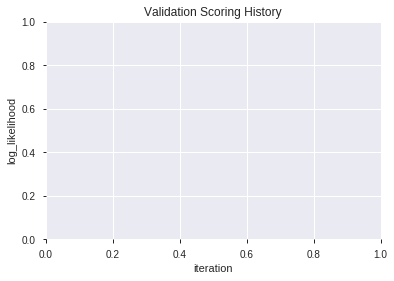

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_174542_model_2  0.532620  0.698689              0.489712  0.502690  0.252698
1  XGBoost_grid_1_AutoML_20190828_174542_model_4  0.525510  0.696718              0.485614  0.501743  0.251746
2  XGBoost_grid_1_AutoML_20190828_174542_model_5  0.514302  0.747897              0.500000  0.523222  0.273762
3  XGBoost_grid_1_AutoML_20190828_174542_model_7  0.497909  0.727968              0.495902  0.516040  0.266298
4  XGBoost_grid_1_AutoML_20190828_174542_model_1  0.488290  0.713310              0.495902  0.509440  0.259530
5  XGBoost_grid_1_AutoML_20190828_174542_model_3  0.487789  0.725036              0.475410  0.515115  0.265343
6               XGBoost_3_AutoML_20190828_174542  0.483105  0.714369              0.500000  0.509861  0.259958
7               XGBoost_1_AutoML_20190828_174542  0.476748  0.724838              0.500000  0.515087  0.265314
8  XGBoost_grid_1_AutoML_20190828_174542_model_6  0.463533  0.734480              0.495902  0.519370  0.269745
9               XGBoost_2_AutoML_20190828_174542  0.462195  0.725717              0.500000  0.515336  0.265571

variable  relative_importance  scaled_importance  percentage
0                HT_DCPERIOD           148.747711           1.000000    0.025225
1       HT_PHASOR_quadrature           119.512245           0.803456    0.020267
2                        BOP           119.054329           0.800378    0.020189
3          HT_PHASOR_inphase           110.198128           0.740839    0.018688
4                      DX_14            96.307648           0.647456    0.016332
..                       ...                  ...                ...         ...
310                 MAVP_8_3             0.493082           0.003315    0.000084
311  BBANDS_upperband_24_0_3             0.395308           0.002658    0.000067
312   BBANDS_lowerband_8_2_3             0.298388           0.002006    0.000051
313   BBANDS_lowerband_8_3_5             0.247889           0.001667    0.000042
314                MAVP_12_4             0.188440           0.001267    0.000032

[315 rows x 4 columns]

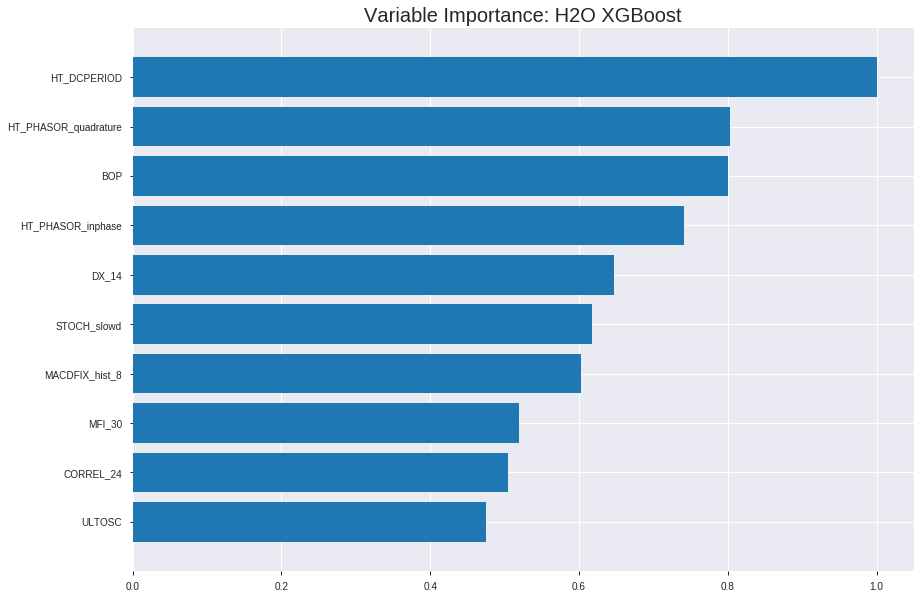

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_174542_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17699052218367048
RMSE: 0.42070241523394003
LogLoss: 0.5434748527567171
Mean Per-Class Error: 0.11031411014587322
AUC: 0.9559338336256237
pr_auc: 0.9555999572469223
Gini: 0.9118676672512473
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4823107197880745: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      699  93   0.1174   (93.0/792.0)
1      77   666  0.1036   (77.0/743.0)
Total  776  759  0.1107   (170.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.482311     0.886818  204
max f2                       0.439504     0.913841  246
max f0point5                 0.52567      0.901844  165
max accuracy                 0.4912       0.889902  198
max precision                0.731147     1         0
max recall                   0.36219      1         329
max specificity              0.731147     1         0
max absolute_mcc             0.4912       0.779551  198
max min_per_class_accuracy   0.487844     0.886945  200
max mean_per_class_accuracy  0.4912       0.889686  198

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 48.71 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.701791           2.06595    2.06595            1                0.71443   1                           0.71443             0.0215343       0.0215343                  106.595   106.595
    2        0.0201954                   0.680666           2.06595    2.06595            1                0.689332  1                           0.702286            0.0201884       0.0417227                  106.595   106.595
    3        0.0306189                   0.671034           2.06595    2.06595            1                0.674115  1                           0.692696            0.0215343       0.0632571                  106.595   106.595
    4        0.0403909                   0.665893           2.06595    2.06595            1                0.668684  1                           0.686887            0.0201884       0.0834455                  106.595   106.595
    5        0.0501629                   0.659468           2.06595    2.06595            1                0.663025  1                           0.682238            0.0201884       0.103634                   106.595   106.595
    6        0.100326                    0.635585           2.06595    2.06595            1                0.647562  1                           0.6649              0.103634        0.207268                   106.595   106.595
    7        0.150489                    0.612159           2.06595    2.06595            1                0.623707  1                           0.651169            0.103634        0.310902                   106.595   106.595
    8        0.2                         0.593655           2.06595    2.06595            1                0.602842  1                           0.639205            0.102288        0.41319                    106.595   106.595
    9        0.300326                    0.555532           1.91838    2.01665            0.928571         0.575715  0.976139                    0.617996            0.192463        0.605653                   91.8381   101.665
    10       0.4                         0.525327           1.71487    1.94145            0.830065         0.539962  0.939739                    0.598551            0.170929        0.776581                   71.4873   94.1454
    11       0.500326                    0.479182           1.22079    1.79695            0.590909         0.504107  0.869792                    0.579613            0.122476        0.899058                   22.0788   79.6945
    12       0.6                         0.445808           0.55362    1.5904             0.267974         0.463826  0.769815                    0.560378            0.0551817       0.95424                    -44.638   59.0399
    13       0.699674                    0.413795           0.337573   1.41192            0.163399         0.430406  0.683426                    0.541862            0.0336474       0.987887                   -66.2427  41.1924
    14       0.8                         0.382109           0.0939068  1.24664            0.0454545        0.397834  0.60342                     0.5238              0.00942127      0.997308                   -90.6093  24.6635
    15       0.899674                    0.34486            0.0270059  1.11151            0.0130719        0.365133  0.538016                    0.506222            0.00269179      1                          -97.2994  11.1513
    16       1                           0.244168           0          1                  0                0.315205  0.484039                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.253345955826952
RMSE: 0.5033348347044461
LogLoss: 0.7000852467079438
Mean Per-Class Error: 0.464131455399061
AUC: 0.5126969222743871
pr_auc: 0.5199677731631406
Gini: 0.025393844548774247
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4053359627723694: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      23   190  0.892    (190.0/213.0)
1      10   215  0.0444   (10.0/225.0)
Total  33   405  0.4566   (200.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405336     0.68254   367
max f2                       0.345697     0.842066  397
max f0point5                 0.405336     0.582656  367
max accuracy                 0.405336     0.543379  367
max precision                0.691923     0.666667  2
max recall                   0.345697     1         397
max specificity              0.728085     0.995305  0
max absolute_mcc             0.405336     0.120316  367
max min_per_class_accuracy   0.505134     0.530516  201
max mean_per_class_accuracy  0.502212     0.535869  209

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 50.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.67529            0.778667  0.778667           0.4              0.69801   0.4                         0.69801             0.00888889      0.00888889                 -22.1333   -22.1333
    2        0.0205479                   0.652038           0.973333  0.865185           0.5              0.664648  0.444444                    0.683183            0.00888889      0.0177778                  -2.66667   -13.4815
    3        0.0319635                   0.643106           1.168     0.973333           0.6              0.646667  0.5                         0.670141            0.0133333       0.0311111                  16.8       -2.66667
    4        0.0410959                   0.639774           0.973333  0.973333           0.5              0.642158  0.5                         0.663923            0.00888889      0.04                       -2.66667   -2.66667
    5        0.0502283                   0.636644           0.486667  0.884848           0.25             0.637893  0.454545                    0.65919             0.00444444      0.0444444                  -51.3333   -11.5152
    6        0.100457                    0.608723           1.1503    1.01758            0.590909         0.621345  0.522727                    0.640267            0.0577778       0.102222                   15.0303    1.75758
    7        0.150685                    0.587626           1.23879   1.09131            0.636364         0.59621   0.560606                    0.625582            0.0622222       0.164444                   23.8788    9.13131
    8        0.200913                    0.573225           1.1503    1.10606            0.590909         0.580577  0.568182                    0.61433             0.0577778       0.222222                   15.0303    10.6061
    9        0.30137                     0.549314           0.752121  0.988081           0.386364         0.562145  0.507576                    0.596935            0.0755556       0.297778                   -24.7879   -1.19192
    10       0.399543                    0.525296           0.995969  0.990019           0.511628         0.536281  0.508571                    0.582031            0.0977778       0.395556                   -0.403101  -0.998095
    11       0.5                         0.505426           1.32727   1.05778            0.681818         0.515466  0.543379                    0.568658            0.133333        0.528889                   32.7273    5.77778
    12       0.600457                    0.484241           0.796364  1.01404            0.409091         0.495817  0.520913                    0.556471            0.08            0.608889                   -20.3636   1.40431
    13       0.69863                     0.461777           0.905426  0.99878            0.465116         0.475037  0.513072                    0.545028            0.0888889       0.697778                   -9.45736   -0.122004
    14       0.799087                    0.443235           0.840606  0.978895           0.431818         0.453079  0.502857                    0.533469            0.0844444       0.782222                   -15.9394   -2.11048
    15       0.899543                    0.411892           1.32727   1.0178             0.681818         0.429846  0.522843                    0.521897            0.133333        0.915556                   32.7273    1.78003
    16       1                           0.334779           0.840606  1                  0.431818         0.384447  0.513699         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 17:46:02  3.414 sec   0                  0.5              0.693147            0.5             0                  1                0.515961                         0.5                0.693147              0.5               0                    1                  0.486301
    2019-08-28 17:46:03  4.498 sec   5                  0.489002         0.67137             0.829263        0.824913           1.95117          0.254072                         0.500886           0.694922              0.480887          0.497809             1.55733            0.477169
    2019-08-28 17:46:03  4.742 sec   10                 0.478767         0.651447            0.867933        0.868236           2.06595          0.21759                          0.501782           0.696722              0.475879          0.508768             1.55733            0.486301
    2019-08-28 17:46:03  4.991 sec   15                 0.469564         0.633792            0.892571        0.889459           2.06595          0.196743                         0.50189            0.696937              0.487376          0.517932             1.55733            0.477169
    2019-08-28 17:46:03  5.250 sec   20                 0.461513         0.618515            0.906489        0.904402           2.06595          0.174593                         0.501264           0.695679              0.503203          0.514618             1.55733            0.46347
    2019-08-28 17:46:04  5.500 sec   25                 0.453312         0.603113            0.917572        0.916439           2.06595          0.160912                         0.501607           0.696371              0.501367          0.514029             1.55733            0.477169
    2019-08-28 17:46:04  5.751 sec   30                 0.446706         0.590796            0.92402         0.923607           2.06595          0.14658                          0.502134           0.697455              0.502546          0.514502             1.168              0.479452
    2019-08-28 17:46:04  6.007 sec   35                 0.440075         0.578546            0.931479        0.9327             2.06595          0.136808                         0.501543           0.696289              0.516109          0.522208             1.55733            0.479452
    2019-08-28 17:46:04  6.279 sec   40                 0.433249         0.566122            0.942524        0.94356            2.06595          0.129642                         0.501936           0.697118              0.516004          0.52212              1.168              0.479452
    2019-08-28 17:46:05  6.543 sec   45                 0.426974         0.554782            0.950052        0.949126           2.06595          0.113355                         0.502657           0.698643              0.513542          0.52168              1.55733            0.472603
    2019-08-28 17:46:05  6.798 sec   50                 0.420702         0.543475            0.955934        0.9556             2.06595          0.110749                         0.503335           0.700085              0.512697          0.519968             0.778667           0.456621

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
HT_DCPERIOD              148.74771118164062     1.0                    0.02522491507586688
HT_PHASOR_quadrature     119.51224517822266     0.8034560278529759     0.020267110069784648
BOP                      119.05432891845703     0.800377551847342      0.02018945577397944
HT_PHASOR_inphase        110.19812774658203     0.7408391488593431     0.01868760461485443
DX_14                    96.30764770507812      0.6474563335463612     0.0163320310290391
---                      ---                    ---                    ---
MAVP_8_3                 0.4930817484855652     0.0033148862901389263  8.361772515490983e-05
BBANDS_upperband_24_0_3  0.39530810713768005    0.002657574385497311   6.703708818196877e-05
BBANDS_lowerband_8_2_3   0.29838812351226807    0.0020060014446064093  5.0601216082262955e-05
BBANDS_lowerband_8_3_5   0.24788865447044373    0.0016665039919016899  4.203742166931327e-05
MAVP_12_4                0.18844038248062134    0.001266845593681174   3.195607251484378e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5727272727272728)

('F1', 0.6173633440514469)

('auc', 0.5326196052191369)

('logloss', 0.6986894869857742)

('mean_per_class_error', 0.45107059217129475)

('rmse', 0.5026904396584044)

('mse', 0.25269767812395993)

xgboost prediction progress: |████████████████████████████████████████████| 100%


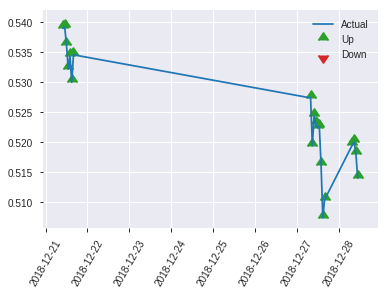


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25269767812395993
RMSE: 0.5026904396584044
LogLoss: 0.6986894869857742
Mean Per-Class Error: 0.45107059217129475
AUC: 0.5326196052191369
pr_auc: 0.4809961021423764
Gini: 0.06523921043827374
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.396450012922287: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    117  0.959    (117.0/122.0)
1      2    96   0.0204   (2.0/98.0)
Total  7    213  0.5409   (119.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.39645      0.617363  212
max f2                       0.346812     0.800654  219
max f0point5                 0.487265     0.513595  140
max accuracy                 0.604964     0.572727  23
max precision                0.691917     1         0
max recall                   0.346812     1         219
max specificity              0.691917     1         0
max absolute_mcc             0.65694      0.108785  4
max min_per_class_accuracy   0.522811     0.540816  107
max mean_per_class_accuracy  0.503745     0.548929  124

Gains/Lift Table: Avg response rate: 44.55 %, avg score: 51.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.663255           1.4966    1.4966             0.666667         0.673239  0.666667                    0.673239            0.0204082       0.0204082                  49.6599   49.6599
    2        0.0227273                   0.653674           2.2449    1.79592            1                0.659605  0.8                         0.667786            0.0204082       0.0408163                  124.49    79.5918
    3        0.0318182                   0.640886           0         1.2828             0                0.647101  0.571429                    0.661876            0               0.0408163                  -100      28.2799
    4        0.0409091                   0.630526           1.12245   1.24717            0.5              0.635338  0.555556                    0.655979            0.0102041       0.0510204                  12.2449   24.7166
    5        0.05                        0.627458           0         1.02041            0                0.629033  0.454545                    0.651079            0               0.0510204                  -100      2.04082
    6        0.1                         0.608816           1.42857   1.22449            0.636364         0.618756  0.545455                    0.634918            0.0714286       0.122449                   42.8571   22.449
    7        0.15                        0.592136           1.02041   1.15646            0.454545         0.598638  0.515152                    0.622825            0.0510204       0.173469                   2.04082   15.6463
    8        0.2                         0.582361           1.02041   1.12245            0.454545         0.58846   0.5                         0.614233            0.0510204       0.22449                    2.04082   12.2449
    9        0.3                         0.554302           1.02041   1.08844            0.454545         0.565924  0.484848                    0.59813             0.102041        0.326531                   2.04082   8.84354
    10       0.4                         0.536327           0.918367  1.04592            0.409091         0.546971  0.465909                    0.58534             0.0918367       0.418367                   -8.16327  4.59184
    11       0.5                         0.520964           1.22449   1.08163            0.545455         0.527409  0.481818                    0.573754            0.122449        0.540816                   22.449    8.16327
    12       0.6                         0.499734           0.918367  1.05442            0.409091         0.509626  0.469697                    0.563066            0.0918367       0.632653                   -8.16327  5.44218
    13       0.7                         0.470452           1.02041   1.04956            0.454545         0.483916  0.467532                    0.551759            0.102041        0.734694                   2.04082   4.95627
    14       0.8                         0.44818            0.714286  1.00765            0.318182         0.459488  0.448864                    0.540225            0.0714286       0.806122                   -28.5714  0.765306
    15       0.9                         0.420786           0.714286  0.975057           0.318182         0.433499  0.434343                    0.528367            0.0714286       0.877551                   -28.5714  -2.49433
    16       1                           0.346812           1.22449   1                  0.545455         0.396703  0.445455                    0.5152          

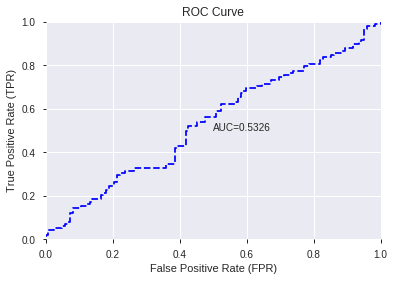

This function is available for GLM models only


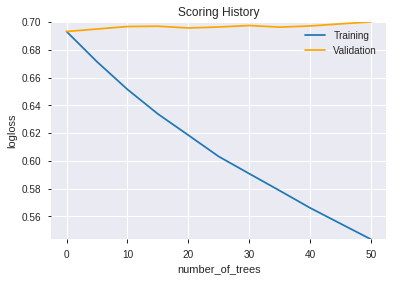

--2019-08-28 17:46:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(Sha

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_174542_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_174542_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b253',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['HT_DCPERIOD',
 'HT_PHASOR_quadrature',
 'BOP',
 'HT_PHASOR_inphase',
 'DX_14',
 'STOCH_slowd',
 'MACDFIX_hist_8',
 'MFI_30',
 'CORREL_24',
 'ULTOSC',
 'DIV',
 'ADX_8',
 'BETA_8',
 'MFI_24',
 'CORREL_30',
 'MFI_8',
 'STOCHF_fastk',
 'BETA_14',
 'CCI_12',
 'STOCH_slowk',
 'WILLR_12',
 'LINEARREG_ANGLE_24',
 'BETA_30',
 'ADX_12',
 'STDDEV_8',
 'BETA_24',
 'ADOSC',
 'OBV',
 'SUB',
 'CORREL_12',
 'LINEARREG_ANGLE_20',
 'ADXR_12',
 'PLUS_DM_24',
 'ADXR_8',
 'CMO_8',
 'ADX_20',
 'Volume',
 'WILLR_24',
 'DX_30',
 'MACDEXT_signal',
 'STDDEV_14',
 'MACDFIX_hist_12',
 'MOM_24',
 'MINUS_DM_12',
 'DX_20',
 'AROONOSC_30',
 'CCI_14',
 'BETA_20',
 'LINEARREG_ANGLE_8',
 'BETA_12',
 'dayofyear',
 'MFI_12',
 'CCI_8',
 'CDLSPINNINGTOP',
 'CORREL_14',
 'APO',
 'STOCHRSI_fastd',
 'MINUS_DI_14',
 'ROC_12',
 'MACDFIX_hist_14',
 'MFI_14',
 'CORREL_20',
 'AROONOSC_12',
 'MACDFIX_hist_24',
 'ADXR_14',
 'WILLR_14',
 'NATR_24',
 'STDDEV_20',
 'MACDEXT_hist',
 'AROONOSC_20',
 'STDDEV_12',
 'WILLR_20',
 'STDDEV_24

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

617

['MA_12_4',
 'MAVP_12_4',
 'BBANDS_upperband_12_4_2',
 'BBANDS_middleband_12_4_2',
 'BBANDS_lowerband_12_4_2',
 'BBANDS_upperband_12_4_3',
 'BBANDS_middleband_12_4_3',
 'BBANDS_lowerband_12_4_3',
 'BBANDS_upperband_12_4_4',
 'BBANDS_middleband_12_4_4',
 'BBANDS_lowerband_12_4_4',
 'BBANDS_upperband_12_4_5',
 'BBANDS_middleband_12_4_5',
 'BBANDS_lowerband_12_4_5',
 'MA_12_5',
 'MAVP_12_5',
 'BBANDS_upperband_12_5_2',
 'BBANDS_middleband_12_5_2',
 'BBANDS_lowerband_12_5_2',
 'BBANDS_upperband_12_5_3',
 'BBANDS_middleband_12_5_3',
 'BBANDS_lowerband_12_5_3',
 'BBANDS_upperband_12_5_4',
 'BBANDS_middleband_12_5_4',
 'BBANDS_lowerband_12_5_4',
 'BBANDS_upperband_12_5_5',
 'BBANDS_middleband_12_5_5',
 'BBANDS_lowerband_12_5_5',
 'MA_12_6',
 'MAVP_12_6',
 'BBANDS_upperband_12_6_2',
 'BBANDS_middleband_12_6_2',
 'BBANDS_lowerband_12_6_2',
 'BBANDS_upperband_12_6_3',
 'BBANDS_middleband_12_6_3',
 'BBANDS_lowerband_12_6_3',
 'BBANDS_upperband_12_6_4',
 'BBANDS_middleband_12_6_4',
 'BBANDS_lowerb

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_174903_model_9  0.541402  0.693972              0.500000  0.500412  0.250413
1  DeepLearning_grid_1_AutoML_20190828_174903_model_1  0.537805  2.149309              0.495902  0.671066  0.450329
2  DeepLearning_grid_1_AutoML_20190828_174903_model_8  0.528479  0.691738              0.500000  0.499293  0.249294
3  DeepLearning_grid_1_AutoML_20190828_174903_model_4  0.525343  0.917090              0.491803  0.572394  0.327635
4  DeepLearning_grid_1_AutoML_20190828_174903_model_7  0.509117  0.719646              0.491803  0.511496  0.261628
5  DeepLearning_grid_1_AutoML_20190828_174903_model_6  0.507193  0.695861              0.500000  0.501356  0.251358
6  DeepLearning_grid_1_AutoML_20190828_174903_model_5  0.505102  0.687362              0.500000  0.497104  0.247112
7  DeepLearning_grid_1_AutoML_20190828_174903_model_2  0.503429  0.926269              0.495902  0.575483  0.331181
8  DeepLearning_grid_1_AutoML_20190828_174903_model_3  0.500502  0.895625              0.500000  0.574887  0.330496
9               DeepLearning_1_AutoML_20190828_174903  0.476999  0.810573              0.487705  0.544671  0.296667

variable  relative_importance  scaled_importance  percentage
0              STOCHRSI_fastd             1.000000           1.000000    0.002227
1           CDLLONGLEGGEDDOJI             0.988030           0.988030    0.002200
2                     CDLDOJI             0.970425           0.970425    0.002161
3              CDLRICKSHAWMAN             0.957239           0.957239    0.002131
4                 aroondown_8             0.944562           0.944562    0.002103
..                        ...                  ...                ...         ...
609              CDLTASUKIGAP             0.644126           0.644126    0.001434
610                CDLHIKKAKE             0.643833           0.643833    0.001434
611                 MAVP_24_0             0.643709           0.643709    0.001433
612  BBANDS_middleband_12_5_3             0.634530           0.634530    0.001413
613             CDLHIKKAKEMOD             0.569045           0.569045    0.001267

[614 rows x 4 columns]

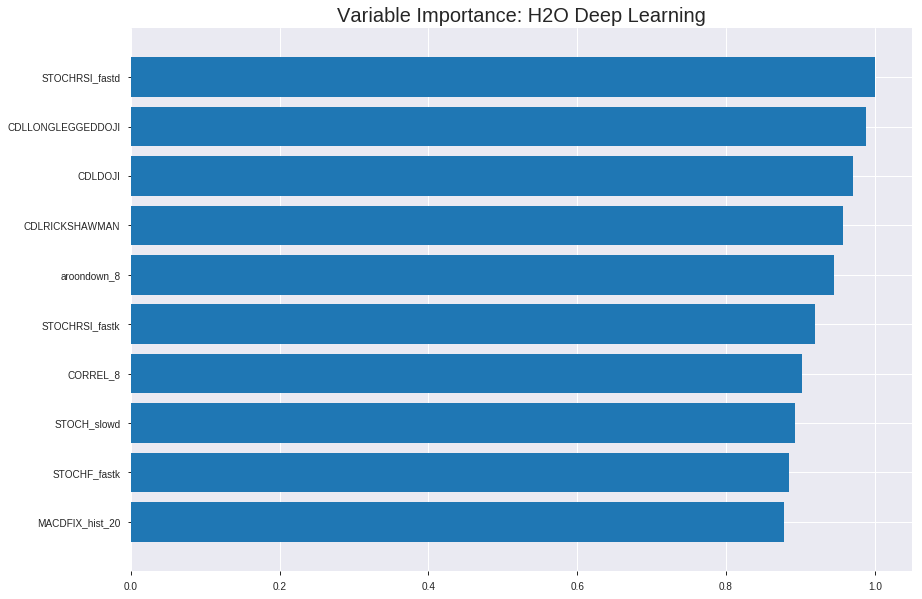

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_174903_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24950626920565602
RMSE: 0.4995060251945476
LogLoss: 0.6921534568404951
Mean Per-Class Error: 0.46277886536971324
AUC: 0.5372942072134536
pr_auc: 0.5554802125578091
Gini: 0.07458841442690711
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5065609307435898: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    789   0.9962   (789.0/792.0)
1      0    743   0        (0.0/743.0)
Total  3    1532  0.514    (789.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.506561     0.653187  257
max f2                       0.506561     0.824822  257
max f0point5                 0.506561     0.540678  257
max accuracy                 0.508187     0.547883  252
max precision                0.590067     1         0
max recall                   0.506561     1         257
max specificity              0.590067     1         0
max absolute_mcc             0.508187     0.10027   252
max min_per_class_accuracy   0.508187     0.20323   252
max mean_per_class_accuracy  0.508187     0.537221  252

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 51.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.564267           1.29122   1.29122            0.625            0.57604   0.625                       0.57604             0.013459        0.013459                   29.1218   29.1218
    2        0.0201954                   0.551788           1.3773    1.33287            0.666667         0.555043  0.645161                    0.56588             0.013459        0.0269179                  37.7299   33.287
    3        0.0306189                   0.546243           1.54946   1.4066             0.75             0.548135  0.680851                    0.559839            0.0161507       0.0430686                  54.9462   40.6603
    4        0.0403909                   0.541861           1.23957   1.36619            0.6              0.544031  0.66129                     0.556015            0.0121131       0.0551817                  23.9569   36.6192
    5        0.0501629                   0.539778           1.10184   1.31469            0.533333         0.54077   0.636364                    0.553045            0.0107672       0.0659489                  10.1839   31.4695
    6        0.100326                    0.52609            1.12688   1.22079            0.545455         0.532876  0.590909                    0.54296             0.0565276       0.122476                   12.6881   22.0788
    7        0.150489                    0.511516           1.2342    1.22526            0.597403         0.51778   0.593074                    0.534567            0.0619112       0.184388                   23.4203   22.526
    8        0.997394                    0.506689           0.961461  1.00126            0.465385         0.506746  0.484651                    0.510943            0.814266        0.998654                   -3.85392  0.126326
    9        1                           0.505531           0.516487  1                  0.25             0.506094  0.484039                    0.510931            0.0013459       1                          -48.3513  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2495358481917604
RMSE: 0.49953563255463607
LogLoss: 0.6922166162872359
Mean Per-Class Error: 0.48347417840375584
AUC: 0.5122587376108503
pr_auc: 0.5486734042110304
Gini: 0.024517475221700558
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.506688594173459: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    213  1        (213.0/213.0)
1      0    225  0        (0.0/225.0)
Total  0    438  0.4863   (213.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.506689     0.678733  61
max f2                       0.506689     0.840807  61
max f0point5                 0.506689     0.569044  61
max accuracy                 0.506689     0.513699  61
max precision                0.551486     1         0
max recall                   0.506689     1         61
max specificity              0.551486     1         0
max absolute_mcc             0.542512     0.104554  4
max min_per_class_accuracy   0.507539     0.151111  60
max mean_per_class_accuracy  0.517983     0.516526  27

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 50.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.542288           1.94667   1.94667            1                0.545083  1                           0.545083            0.0222222       0.0222222                  94.6667   94.6667
    2        0.0205479                   0.538163           0.486667  1.29778            0.25             0.540511  0.666667                    0.543051            0.00444444      0.0266667                  -51.3333  29.7778
    3        0.0319635                   0.529018           1.55733   1.39048            0.8              0.532987  0.714286                    0.539456            0.0177778       0.0444444                  55.7333   39.0476
    4        0.0410959                   0.525528           0.973333  1.29778            0.5              0.527446  0.666667                    0.536787            0.00888889      0.0533333                  -2.66667  29.7778
    5        0.0502283                   0.522597           0.973333  1.23879            0.5              0.523877  0.636364                    0.53444             0.00888889      0.0622222                  -2.66667  23.8788
    6        0.100457                    0.512328           0.707879  0.973333           0.363636         0.516305  0.5                         0.525373            0.0355556       0.0977778                  -29.2121  -2.66667
    7        1                           0.506689           1.00298   1                  0.515228         0.506824  0.513699                    0.508687            0.902222        1                          0.2978    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:02:13  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 18:02:16  4 min  9.522 sec  219 obs/sec       0.428013  1             657        0.544185         0.82408             -0.185759      0.545422        0.533021           1.29122          0.512704                         0.584533           0.95614               -0.367742        0.495775          0.526279             1.168              0.479452
    2019-08-28 18:02:50  4 min 42.626 sec  283 obs/sec       6.08795   15            9345       0.499114         0.691374            0.00252635     0.534732        0.525421           1.42034          0.512052                         0.500426           0.693999              -0.00245523      0.509619          0.521121             1.55733            0.481735
    2019-08-28 18:03:22  5 min 14.510 sec  312 obs/sec       12.5531   31            19269      0.499738         0.692624            2.67963e-05    0.539067        0.537899           1.42034          0.512052                         0.501927           0.697017              -0.00848141      0.488492          0.52167              1.55733            0.486301
    2019-08-28 18:03:54  5 min 47.257 sec  341 obs/sec       20.2977   50            31157      0.498187         0.689515            0.00622633     0.544385        0.539953           1.54946          0.515961                         0.500505           0.694155              -0.00277204      0.471372          0.51151              1.55733            0.486301
    2019-08-28 18:04:27  6 min 19.881 sec  382 obs/sec       30.0332   74            46101      0.499619         0.692366            0.000506431    0.528378        0.559506           1.54946          0.512052                         0.49982            0.692787              -3.066e-05       0.510673          0.597026             1.55733            0.486301
    2019-08-28 18:05:00  6 min 52.821 sec  418 obs/sec       40.985    101           62912      0.499506         0.692153            0.000956895    0.537294        0.55548            1.29122          0.514007                         0.499536           0.692217              0.00110683       0.512259          0.548673             1.94667            0.486301
    2019-08-28 18:05:32  7 min 25.014 sec  440 obs/sec       51.4997   127           79052      0.497487         0.688047            0.00901859     0.535298        0.541473           1.67858          0.515961                         0.499786           0.692693              0.000105412      0.48796           0.518284             1.168              0.486301
    2019-08-28 18:05:35  7 min 28.278 sec  440 obs/sec       51.4997   127           79052      0.499506         0.692153            0.000956895    0.537294        0.55548            1.29122          0.514007                         0.499536           0.692217              0.00110683       0.512259          0.548673             1.94667            0.486301

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
STOCHRSI_fastd            1.0                    1.0                  0.0022266974564893157
CDLLONGLEGGEDDOJI         0.9880297183990479     0.9880297183990479   0.002200043260895015
CDLDOJI                   0.9704247117042542     0.9704247117042542   0.00216084223726624
CDLRICKSHAWMAN            0.9572390913963318     0.9572390913963318   0.002131481850064356
aroondown_8               0.944561779499054      0.944561779499054    0.0021032533119075656
---                       ---                    ---                  ---
CDLTASUKIGAP              0.6441256999969482     0.6441256999969482   0.0014342730578426046
CDLHIKKAKE                0.6438331007957458     0.6438331007957458   0.0014336215279455167
MAVP_24_0                 0.6437094211578369     0.6437094211578369   0.0014333461308103652
BBANDS_middleband_12_5_3  0.6345300078392029     0.6345300078392029   0.0014129063545216987
CDLHIKKAKEMOD             0.5690450668334961     0.5690450668334961   0.0012670912029459384


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5863636363636363)

('F1', 0.6163522012578617)

('auc', 0.541401806624289)

('logloss', 0.6939718341572442)

('mean_per_class_error', 0.45424891267982603)

('rmse', 0.5004124429082898)

('mse', 0.2504126130174424)

deeplearning prediction progress: |███████████████████████████████████████| 100%


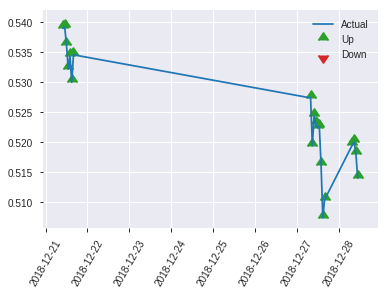


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2504126130174424
RMSE: 0.5004124429082898
LogLoss: 0.6939718341572442
Mean Per-Class Error: 0.45424891267982603
AUC: 0.541401806624289
pr_auc: 0.514496465134455
Gini: 0.0828036132485781
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.506688594173459: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    122  1        (122.0/122.0)
1      0    98   0        (0.0/98.0)
Total  0    220  0.5545   (122.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.506689     0.616352  35
max f2                       0.506689     0.800654  35
max f0point5                 0.506689     0.501022  35
max accuracy                 0.520545     0.586364  18
max precision                0.552305     1         0
max recall                   0.506689     1         35
max specificity              0.552305     1         0
max absolute_mcc             0.520545     0.147694  18
max min_per_class_accuracy   0.507519     0.204082  34
max mean_per_class_accuracy  0.511432     0.545751  26

Gains/Lift Table: Avg response rate: 44.55 %, avg score: 50.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.543183           0.748299  0.748299           0.333333         0.546417  0.333333                    0.546417            0.0102041       0.0102041                  -25.1701  -25.1701
    2        0.0227273                   0.541152           2.2449    1.34694            1                0.542286  0.6                         0.544764            0.0204082       0.0306122                  124.49    34.6939
    3        0.0318182                   0.537824           0         0.962099           0                0.539098  0.428571                    0.543145            0               0.0306122                  -100      -3.79009
    4        0.0409091                   0.536047           1.12245   0.997732           0.5              0.537706  0.444444                    0.541937            0.0102041       0.0408163                  12.2449   -0.226757
    5        0.05                        0.528348           1.12245   1.02041            0.5              0.532742  0.454545                    0.540265            0.0102041       0.0510204                  12.2449   2.04082
    6        0.1                         0.514556           1.83673   1.42857            0.818182         0.523308  0.636364                    0.531787            0.0918367       0.142857                   83.6735   42.8571
    7        0.15                        0.508288           0.816327  1.22449            0.363636         0.510764  0.545455                    0.524779            0.0408163       0.183673                   -18.3673  22.449
    8        1                           0.506689           0.960384  1                  0.427807         0.506702  0.445455                    0.509413            0.816327        1                          -3.96158  0

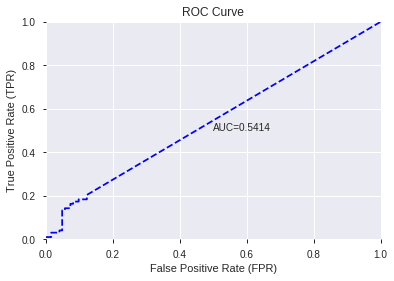

This function is available for GLM models only


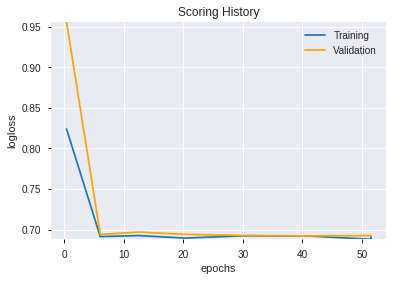

--2019-08-28 18:05:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_174903_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_174903_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b253',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['STOCHRSI_fastd',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'aroondown_8',
 'STOCHRSI_fastk',
 'CORREL_8',
 'STOCH_slowd',
 'STOCHF_fastk',
 'MACDFIX_hist_20',
 'MACDFIX_hist_24',
 'aroondown_14',
 'aroondown_12',
 'CORREL_12',
 'AROONOSC_12',
 'AROONOSC_8',
 'aroondown_20',
 'MFI_14',
 'DX_14',
 'ADXR_14',
 'LINEARREG_SLOPE_8',
 'MACDFIX_hist_14',
 'HT_TRENDMODE',
 'aroonup_12',
 'WILLR_8',
 'BOP',
 'MFI_12',
 'CCI_8',
 'aroondown_30',
 'WILLR_12',
 'NATR_30',
 'DX_8',
 'MFI_8',
 'NATR_14',
 'MINUS_DI_8',
 'CCI_14',
 'BETA_24',
 'MACD_hist',
 'aroonup_8',
 'LINEARREG_SLOPE_12',
 'ADX_24',
 'LINEARREG_SLOPE_20',
 'MACDFIX_hist_12',
 'ADX_8',
 'WILLR_20',
 'aroonup_24',
 'ROC_20',
 'ROCR100_8',
 'ADX_20',
 'ADX_12',
 'BETA_8',
 'CCI_24',
 'MACDFIX_hist_8',
 'STDDEV_8',
 'ROCR_20',
 'CCI_20',
 'MOM_20',
 'AROONOSC_20',
 'aroonup_30',
 'PLUS_DI_8',
 'BETA_14',
 'LINEARREG_ANGLE_24',
 'LINEARREG_ANGLE_8',
 'TRANGE',
 'ROCR_8',
 'NATR_24',
 'AROONOSC_14',
 'CMO_20',
 'MINUS_DM_

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_180646_model_1  0.504767  0.702353                   0.5  0.504523  0.254544

variable  relative_importance  scaled_importance  percentage
0           CDLGRAVESTONEDOJI             0.028218           1.000000    0.017560
1                   CDLHARAMI             0.027605           0.978251    0.017178
2                  aroonup_20             0.026677           0.945377    0.016601
3              CDLRICKSHAWMAN             0.025012           0.886387    0.015565
4               CDLHIKKAKEMOD             0.021796           0.772394    0.013563
..                        ...                  ...                ...         ...
609  BBANDS_middleband_14_1_3             0.000007           0.000242    0.000004
610                   MA_20_5             0.000005           0.000169    0.000003
611        CDLMORNINGDOJISTAR             0.000004           0.000141    0.000002
612  BBANDS_middleband_14_0_4             0.000002           0.000081    0.000001
613   BBANDS_upperband_30_7_5             0.000002           0.000065    0.000001

[614 rows x 4 columns]

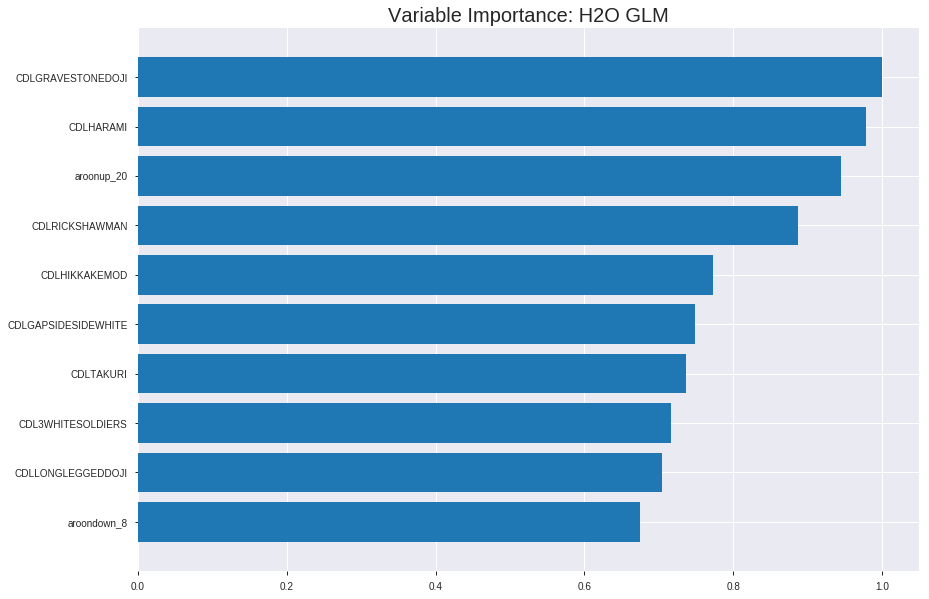

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_180646_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24211843013561613
RMSE: 0.4920553120692999
LogLoss: 0.6772401190823413
Null degrees of freedom: 1534
Residual degrees of freedom: 920
Null deviance: 2126.397409180741
Residual deviance: 2079.1271655827877
AIC: 3309.1271655827877
AUC: 0.6154198444743532
pr_auc: 0.5837589338748773
Gini: 0.23083968894870632
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4099339232226274: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      51   741   0.9356   (741.0/792.0)
1      12   731   0.0162   (12.0/743.0)
Total  63   1472  0.4906   (753.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.409934     0.660045  357
max f2                       0.355459     0.825923  391
max f0point5                 0.468752     0.581153  236
max accuracy                 0.479994     0.591531  212
max precision                0.624964     0.75      15
max recall                   0.355459     1         391
max specificity              0.673908     0.998737  0
max absolute_mcc             0.468752     0.183102  236
max min_per_class_accuracy   0.478383     0.587121  215
max mean_per_class_accuracy  0.47951      0.59126   213

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 48.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0104235                   0.631121           1.42034   1.42034            0.6875           0.64312   0.6875                      0.64312             0.0148048       0.0148048                  42.034      42.034
    2        0.0201954                   0.599543           1.23957   1.33287            0.6              0.612712  0.645161                    0.628406            0.0121131       0.0269179                  23.9569     33.287
    3        0.0306189                   0.591306           1.42034   1.36265            0.6875           0.595715  0.659574                    0.617277            0.0148048       0.0417227                  42.034      36.2647
    4        0.0403909                   0.582127           1.23957   1.33287            0.6              0.58533   0.645161                    0.609548            0.0121131       0.0538358                  23.9569     33.287
    5        0.0501629                   0.575289           1.51503   1.36836            0.733333         0.579477  0.662338                    0.60369             0.0148048       0.0686406                  51.5029     36.8356
    6        0.100326                    0.55182            1.47568   1.42202            0.714286         0.561675  0.688312                    0.582683            0.0740242       0.142665                   47.5678     42.2017
    7        0.150489                    0.540104           1.28786   1.3773             0.623377         0.545892  0.666667                    0.570419            0.064603        0.207268                   28.7864     37.7299
    8        0.2                         0.526408           1.03297   1.29206            0.5              0.533289  0.625407                    0.561227            0.051144        0.258412                   3.29744     29.2059
    9        0.300326                    0.507004           1.08664   1.22344            0.525974         0.515514  0.592191                    0.545956            0.109017        0.367429                   8.66354     22.3436
    10       0.4                         0.490766           1.12074   1.19785            0.542484         0.498853  0.579805                    0.534219            0.111709        0.479139                   12.0743     19.7847
    11       0.500326                    0.477781           1.11347   1.18093            0.538961         0.483861  0.571615                    0.524121            0.111709        0.590848                   11.3466     18.0926
    12       0.6                         0.466738           0.999217  1.15074            0.48366          0.47209   0.557003                    0.515478            0.0995962       0.690444                   -0.0782906  15.074
    13       0.699674                    0.454561           0.850685  1.10799            0.411765         0.460662  0.536313                    0.507669            0.0847914       0.775236                   -14.9315    10.7995
    14       0.8                         0.441566           0.831746  1.07335            0.402597         0.447893  0.519544                    0.500172            0.0834455       0.858681                   -16.8254    7.33513
    15       0.899674                    0.426583           0.675147  1.02923            0.326797         0.43452   0.49819                     0.492899            0.0672948       0.925976                   -32.4853    2.92345
    16       1                           0.32014            0.737839  1                  0.357143         0.40459   0.484039       



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24977420717441037
RMSE: 0.49977415616897436
LogLoss: 0.6926728713133059
Null degrees of freedom: 437
Residual degrees of freedom: -177
Null deviance: 608.4098651427188
Residual deviance: 606.7814352704561
AIC: 1836.781435270456
AUC: 0.530151278038602
pr_auc: 0.542456375099117
Gini: 0.06030255607720392
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3857096601844275: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   203  0.9531   (203.0/213.0)
1      4    221  0.0178   (4.0/225.0)
Total  14   424  0.4726   (207.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.38571      0.681048   385
max f2                       0.353793     0.841436   398
max f0point5                 0.4363       0.575741   353
max accuracy                 0.457457     0.538813   307
max precision                0.682544     1          0
max recall                   0.353793     1          398
max specificity              0.682544     1          0
max absolute_mcc             0.62884      0.0934079  3
max min_per_class_accuracy   0.50093      0.524444   199
max mean_per_class_accuracy  0.505687     0.535149   188

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 49.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.6253             1.94667   1.94667            1                0.642506  1                           0.642506            0.0222222       0.0222222                  94.6667    94.6667
    2        0.0205479                   0.613681           0.486667  1.29778            0.25             0.621236  0.666667                    0.633053            0.00444444      0.0266667                  -51.3333   29.7778
    3        0.0319635                   0.604632           1.55733   1.39048            0.8              0.607949  0.714286                    0.624087            0.0177778       0.0444444                  55.7333    39.0476
    4        0.0410959                   0.598522           0.973333  1.29778            0.5              0.600293  0.666667                    0.618799            0.00888889      0.0533333                  -2.66667   29.7778
    5        0.0502283                   0.589808           0         1.06182            0                0.5945    0.545455                    0.614381            0               0.0533333                  -100       6.18182
    6        0.100457                    0.572338           1.06182   1.06182            0.545455         0.581348  0.545455                    0.597865            0.0533333       0.106667                   6.18182    6.18182
    7        0.150685                    0.554111           0.973333  1.03232            0.5              0.561911  0.530303                    0.58588             0.0488889       0.155556                   -2.66667   3.23232
    8        0.200913                    0.542595           1.23879   1.08394            0.636364         0.549224  0.556818                    0.576716            0.0622222       0.217778                   23.8788    8.39394
    9        0.30137                     0.528593           1.01758   1.06182            0.522727         0.535737  0.545455                    0.563057            0.102222        0.32                       1.75758    6.18182
    10       0.399543                    0.514078           0.995969  1.04564            0.511628         0.520918  0.537143                    0.552703            0.0977778       0.417778                   -0.403101  4.56381
    11       0.5                         0.50052            1.06182   1.04889            0.545455         0.50749   0.538813                    0.543619            0.106667        0.524444                   6.18182    4.88889
    12       0.600457                    0.481273           0.973333  1.03625            0.5              0.491122  0.532319                    0.534836            0.0977778       0.622222                   -2.66667   3.62484
    13       0.69863                     0.467494           0.950698  1.02423            0.488372         0.474858  0.526144                    0.526408            0.0933333       0.715556                   -4.93023   2.42266
    14       0.799087                    0.455475           1.10606   1.03451            0.568182         0.461279  0.531429                    0.51822             0.111111        0.826667                   10.6061    3.45143
    15       0.899543                    0.434797           0.884848  1.0178             0.454545         0.446659  0.522843                    0.510229            0.0888889       0.915556                   -11.5152   1.78003
    16       1                           0.351465           0.840606  1                  0.431818         0.401262  0.513699                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 18:06:47  0.000 sec   2            4.2       615           1.3734            1.38881
    2019-08-28 18:06:48  0.457 sec   4            3         615           1.37127           1.38824
    2019-08-28 18:06:48  1.206 sec   6            2.2       615           1.36875           1.38727
    2019-08-28 18:06:49  1.943 sec   8            1.6       615           1.36583           1.38643
    2019-08-28 18:06:50  2.708 sec   10           1.2       615           1.36247           1.38576
    2019-08-28 18:06:51  3.455 sec   12           0.85      615           1.35868           1.38536
    2019-08-28 18:06:51  4.206 sec   14           0.62      615           1.35448           1.38535
    2019-08-28 18:06:52  4.954 sec   16           0.45      615           1.34993           1.3858
    2019-08-28 18:06:53  5.701 sec   18           0.33      615           1.34507           1.38678
    2019-08-28 18:06:54  6.468 sec   20           0.24      615           1.34004           1.38848
    2019-08-28 18:06:54  7.204 sec   22           0.17      615           1.33491           1.39101
    2019-08-28 18:06:55  7.982 sec   24           0.13      615           1.32981           1.3945

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5818181818181818)

('F1', 0.6163522012578617)

('auc', 0.504767480762797)

('logloss', 0.7023526183918656)

('mean_per_class_error', 0.4591836734693877)

('rmse', 0.5045231308805703)

('mse', 0.2545435895935331)

glm prediction progress: |████████████████████████████████████████████████| 100%


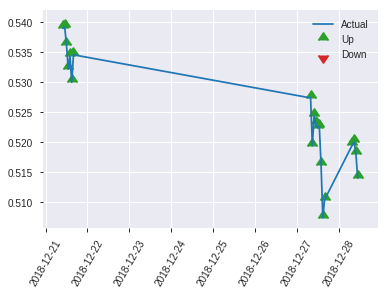


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2545435895935331
RMSE: 0.5045231308805703
LogLoss: 0.7023526183918656
Null degrees of freedom: 219
Residual degrees of freedom: -395
Null deviance: 303.6762860419698
Residual deviance: 309.03515209242084
AIC: 1539.035152092421
AUC: 0.504767480762797
pr_auc: 0.4777400577546615
Gini: 0.009534961525593966
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35384332735669016: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    122  1        (122.0/122.0)
1      0    98   0        (0.0/98.0)
Total  0    220  0.5545   (122.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.353843     0.616352  219
max f2                       0.353843     0.800654  219
max f0point5                 0.353843     0.501022  219
max accuracy                 0.600984     0.581818  9
max precision                0.695557     1         0
max recall                   0.353843     1         219
max specificity              0.695557     1         0
max absolute_mcc             0.42384      0.171604  203
max min_per_class_accuracy   0.509276     0.530612  108
max mean_per_class_accuracy  0.505361     0.540816  117

Gains/Lift Table: Avg response rate: 44.55 %, avg score: 50.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.623201           1.4966    1.4966             0.666667         0.657934  0.666667                    0.657934            0.0204082       0.0204082                  49.6599   49.6599
    2        0.0227273                   0.6095             1.12245   1.34694            0.5              0.612062  0.6                         0.639585            0.0102041       0.0306122                  12.2449   34.6939
    3        0.0318182                   0.604631           2.2449    1.6035             1                0.60708   0.714286                    0.630298            0.0204082       0.0510204                  124.49    60.3499
    4        0.0409091                   0.60127            2.2449    1.74603            1                0.602875  0.777778                    0.624204            0.0204082       0.0714286                  124.49    74.6032
    5        0.05                        0.599314           1.12245   1.63265            0.5              0.600942  0.727273                    0.619974            0.0102041       0.0816327                  12.2449   63.2653
    6        0.1                         0.582346           1.02041   1.32653            0.454545         0.590943  0.590909                    0.605459            0.0510204       0.132653                   2.04082   32.6531
    7        0.15                        0.56335            0.816327  1.15646            0.363636         0.572766  0.515152                    0.594561            0.0408163       0.173469                   -18.3673  15.6463
    8        0.2                         0.547744           1.02041   1.12245            0.454545         0.554712  0.5                         0.584599            0.0510204       0.22449                    2.04082   12.2449
    9        0.3                         0.536343           0.918367  1.05442            0.409091         0.542904  0.469697                    0.570701            0.0918367       0.316327                   -8.16327  5.44218
    10       0.4                         0.524197           1.22449   1.09694            0.545455         0.529836  0.488636                    0.560484            0.122449        0.438776                   22.449    9.69388
    11       0.5                         0.507854           0.918367  1.06122            0.409091         0.514623  0.472727                    0.551312            0.0918367       0.530612                   -8.16327  6.12245
    12       0.6                         0.499404           0.816327  1.02041            0.363636         0.503995  0.454545                    0.543426            0.0816327       0.612245                   -18.3673  2.04082
    13       0.7                         0.482768           0.714286  0.976676           0.318182         0.492284  0.435065                    0.53612             0.0714286       0.683673                   -28.5714  -2.33236
    14       0.8                         0.466728           0.816327  0.956633           0.363636         0.47356   0.426136                    0.5283              0.0816327       0.765306                   -18.3673  -4.33673
    15       0.9                         0.431178           0.918367  0.952381           0.409091         0.453426  0.424242                    0.519981            0.0918367       0.857143                   -8.16327  -4.7619
    16       1                           0.353843           1.42857   1                  0.636364         0.411791  0.445455                    0.509162       

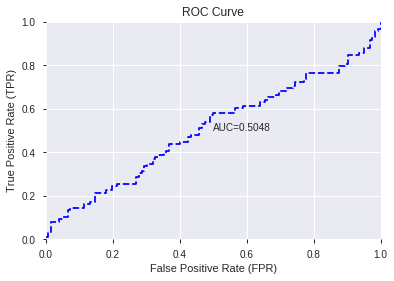

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


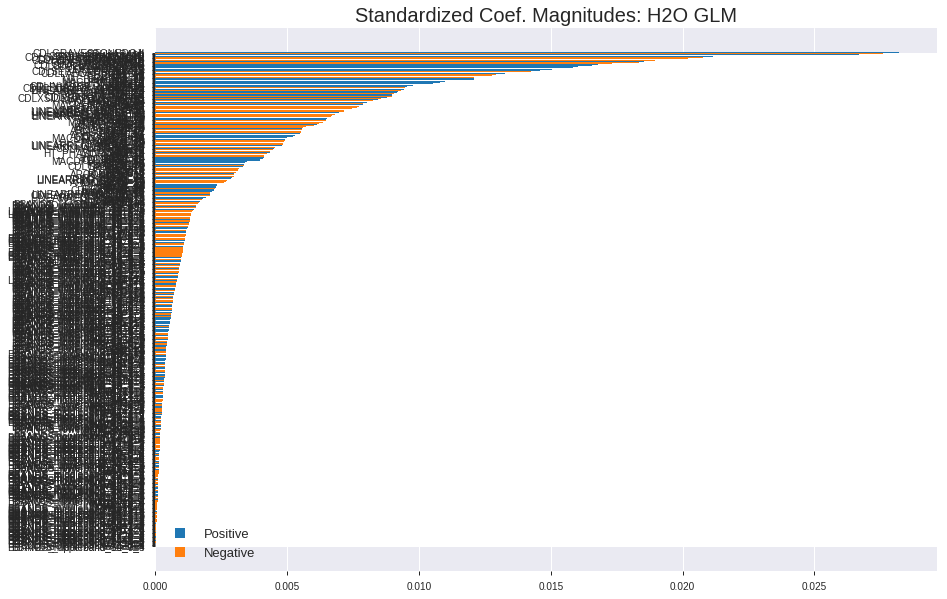

'log_likelihood'
--2019-08-28 18:07:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.39.12
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.39.12|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_180646_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_180646_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_b253',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLGRAVESTONEDOJI',
 'CDLHARAMI',
 'aroonup_20',
 'CDLRICKSHAWMAN',
 'CDLHIKKAKEMOD',
 'CDLGAPSIDESIDEWHITE',
 'CDLTAKURI',
 'CDL3WHITESOLDIERS',
 'CDLLONGLEGGEDDOJI',
 'aroondown_8',
 'CDLSPINNINGTOP',
 'CDLDOJI',
 'CDLHARAMICROSS',
 'TRANGE',
 'CDLSTALLEDPATTERN',
 'aroondown_20',
 'CDLEVENINGSTAR',
 'DX_8',
 'aroonup_14',
 'CDLSHORTLINE',
 'ADX_8',
 'CORREL_14',
 'CDLSEPARATINGLINES',
 'VAR_14',
 'CDLLADDERBOTTOM',
 'DX_12',
 'CORREL_12',
 'MFI_20',
 'MFI_8',
 'VAR_12',
 'CORREL_30',
 'MACDFIX_hist_24',
 'aroonup_24',
 'WILLR_14',
 'CCI_12',
 'MACDFIX_hist_20',
 'STDDEV_8',
 'ADXR_8',
 'DX_14',
 'BETA_8',
 'CCI_14',
 'CDLINVERTEDHAMMER',
 'HT_PHASOR_quadrature',
 'CDLCLOSINGMARUBOZU',
 'LINEARREG_ANGLE_24',
 'LINEARREG_SLOPE_24',
 'aroonup_8',
 'MACDFIX_hist_14',
 'ADX_12',
 'CCI_8',
 'MFI_24',
 'CDL3LINESTRIKE',
 'CORREL_24',
 'VAR_8',
 'CDLSHOOTINGSTAR',
 'CDLXSIDEGAP3METHODS',
 'PLUS_DM_30',
 'MACDFIX_hist_12',
 'PLUS_DI_30',
 'OBV',
 'BETA_24',
 'CDLMARUBOZU',
 'CORREL_8',
 'S

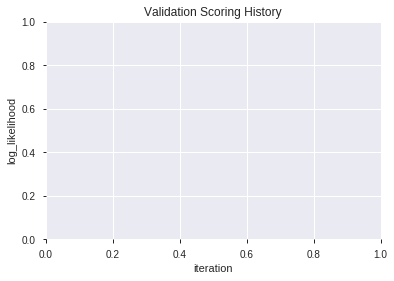

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_180814_model_4  0.519655  0.696831              0.488709  0.501791  0.251794
1               XGBoost_3_AutoML_20190828_180814  0.489378  0.717367              0.500000  0.511506  0.261638
2  XGBoost_grid_1_AutoML_20190828_180814_model_2  0.487119  0.710556              0.491803  0.508456  0.258528
3  XGBoost_grid_1_AutoML_20190828_180814_model_1  0.470391  0.722996              0.500000  0.514004  0.264200
4  XGBoost_grid_1_AutoML_20190828_180814_model_5  0.470057  0.779936              0.500000  0.537538  0.288948
5  XGBoost_grid_1_AutoML_20190828_180814_model_3  0.460773  0.738383              0.500000  0.521245  0.271696
6  XGBoost_grid_1_AutoML_20190828_180814_model_7  0.455169  0.752433              0.500000  0.527036  0.277767
7               XGBoost_1_AutoML_20190828_180814  0.451071  0.761672              0.491803  0.531180  0.282152
8  XGBoost_grid_1_AutoML_20190828_180814_model_6  0.451071  0.729070              0.488709  0.517181  0.267476
9               XGBoost_2_AutoML_20190828_180814  0.415607  0.745388              0.479508  0.524806  0.275421

variable  relative_importance  scaled_importance  percentage
0                  CORREL_30            76.780663           1.000000    0.024886
1                     ADX_20            70.314713           0.915787    0.022790
2         LINEARREG_ANGLE_20            66.609291           0.867527    0.021589
3                HT_DCPERIOD            65.648949           0.855019    0.021278
4                      MFI_8            64.503868           0.840106    0.020907
..                       ...                  ...                ...         ...
143        MACDFIX_signal_20             4.912309           0.063978    0.001592
144  BBANDS_lowerband_30_2_4             4.791597           0.062406    0.001553
145              MINUS_DI_30             4.776579           0.062211    0.001548
146              AROONOSC_20             4.677736           0.060923    0.001516
147                STDDEV_12             3.891790           0.050687    0.001261

[148 rows x 4 columns]

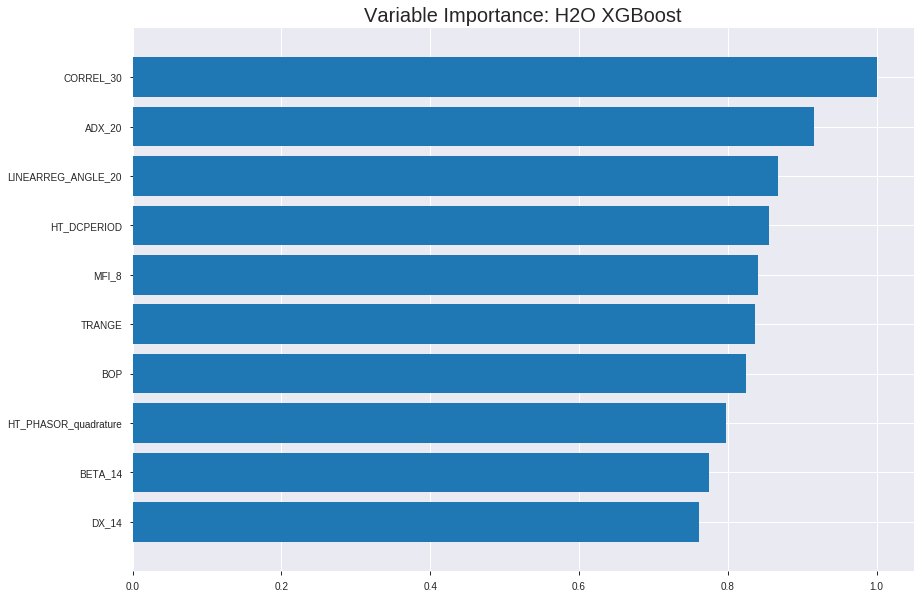

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_180814_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21044455753111932
RMSE: 0.45874236509300004
LogLoss: 0.6124115599613972
Mean Per-Class Error: 0.25156936117568685
AUC: 0.8241066451867259
pr_auc: 0.815290098373482
Gini: 0.6482132903734519
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4674499034881592: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      514  278  0.351    (278.0/792.0)
1      126  617  0.1696   (126.0/743.0)
Total  640  895  0.2632   (404.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.46745      0.753358  222
max f2                       0.385701     0.850372  319
max f0point5                 0.50692      0.75304   167
max accuracy                 0.491848     0.747883  187
max precision                0.703876     1         0
max recall                   0.337263     1         364
max specificity              0.703876     1         0
max absolute_mcc             0.479925     0.497483  204
max min_per_class_accuracy   0.48664      0.743687  195
max mean_per_class_accuracy  0.479925     0.748431  204

Gains/Lift Table: Avg response rate: 48.40 %, avg score: 48.33 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.667956           2.06595    2.06595            1                0.681076  1                           0.681076            0.0215343       0.0215343                  106.595   106.595
    2        0.0201954                   0.643676           2.06595    2.06595            1                0.653432  1                           0.667699            0.0201884       0.0417227                  106.595   106.595
    3        0.0306189                   0.634813           1.80771    1.97804            0.875            0.639918  0.957447                    0.658242            0.0188425       0.0605653                  80.7705   97.8036
    4        0.0403909                   0.625095           2.06595    1.99931            1                0.628667  0.967742                    0.651087            0.0201884       0.0807537                  106.595   99.9305
    5        0.0501629                   0.618652           2.06595    2.01229            1                0.621787  0.974026                    0.645379            0.0201884       0.100942                   106.595   101.229
    6        0.100326                    0.59418            1.8513     1.9318             0.896104         0.605235  0.935065                    0.625307            0.0928668       0.193809                   85.1305   93.1796
    7        0.150489                    0.573965           1.79764    1.88708            0.87013          0.584577  0.91342                     0.611731            0.090175        0.283984                   79.7644   88.7079
    8        0.2                         0.556372           1.63101    1.82369            0.789474         0.56482   0.882736                    0.600117            0.0807537       0.364738                   63.1012   82.3688
    9        0.300326                    0.530195           1.50251    1.7164             0.727273         0.543246  0.830803                    0.581119            0.15074         0.515478                   50.2508   71.6396
    10       0.4                         0.506891           1.33679    1.6218             0.647059         0.518135  0.785016                    0.565425            0.133244        0.648721                   33.679    62.1803
    11       0.500326                    0.484898           1.03297    1.50373            0.5              0.494804  0.727865                    0.551264            0.103634        0.752355                   3.29744   50.3731
    12       0.6                         0.464105           0.850685   1.39524            0.411765         0.474427  0.675353                    0.538499            0.0847914       0.837147                   -14.9315  39.5245
    13       0.699674                    0.435873           0.594129   1.28112            0.287582         0.449508  0.620112                    0.525822            0.0592194       0.896366                   -40.5871  28.1119
    14       0.8                         0.407822           0.563441   1.19112            0.272727         0.422261  0.576547                    0.512835            0.0565276       0.952894                   -43.6559  19.1117
    15       0.899674                    0.374128           0.378082   1.10104            0.183007         0.390881  0.532947                    0.499323            0.0376851       0.990579                   -62.1918  10.1042
    16       1                           0.270301           0.0939068  1                  0.0454545        0.340029  0.484039                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2523642050940927
RMSE: 0.5023586419024686
LogLoss: 0.6980199071004672
Mean Per-Class Error: 0.45524256651017225
AUC: 0.5146687532603026
pr_auc: 0.5211834113712414
Gini: 0.029337506520605183
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39485403895378113: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    205  0.9624   (205.0/213.0)
1      3    222  0.0133   (3.0/225.0)
Total  11   427  0.4749   (208.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394854     0.680982  388
max f2                       0.363223     0.842066  397
max f0point5                 0.441991     0.580535  345
max accuracy                 0.505567     0.545662  216
max precision                0.711485     1         0
max recall                   0.363223     1         397
max specificity              0.711485     1         0
max absolute_mcc             0.664266     0.104554  4
max min_per_class_accuracy   0.509349     0.521127  203
max mean_per_class_accuracy  0.505567     0.544757  216

Gains/Lift Table: Avg response rate: 51.37 %, avg score: 51.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.663631           1.94667   1.94667            1                0.679264  1                           0.679264            0.0222222       0.0222222                  94.6667   94.6667
    2        0.0205479                   0.655983           0.486667  1.29778            0.25             0.659481  0.666667                    0.670471            0.00444444      0.0266667                  -51.3333  29.7778
    3        0.0319635                   0.643152           0.389333  0.973333           0.2              0.650615  0.5                         0.66338             0.00444444      0.0311111                  -61.0667  -2.66667
    4        0.0410959                   0.633845           1.46      1.08148            0.75             0.637839  0.555556                    0.657704            0.0133333       0.0444444                  46        8.14815
    5        0.0502283                   0.622422           1.46      1.1503             0.75             0.628004  0.590909                    0.652304            0.0133333       0.0577778                  46        15.0303
    6        0.100457                    0.596939           0.619394  0.884848           0.318182         0.612897  0.454545                    0.6326              0.0311111       0.0888889                  -38.0606  -11.5152
    7        0.150685                    0.583504           0.973333  0.914343           0.5              0.589487  0.469697                    0.618229            0.0488889       0.137778                   -2.66667  -8.56566
    8        0.200913                    0.568495           1.06182   0.951212           0.545455         0.574608  0.488636                    0.607324            0.0533333       0.191111                   6.18182   -4.87879
    9        0.30137                     0.542334           0.929091  0.943838           0.477273         0.554734  0.484848                    0.589794            0.0933333       0.284444                   -7.09091  -5.61616
    10       0.399543                    0.525457           1.2676    1.02339            0.651163         0.533062  0.525714                    0.575854            0.124444        0.408889                   26.7597   2.33905
    11       0.5                         0.509869           1.10606   1.04               0.568182         0.517203  0.534247                    0.56407             0.111111        0.52                       10.6061   4
    12       0.600457                    0.493784           1.10606   1.05105            0.568182         0.501408  0.539924                    0.553587            0.111111        0.631111                   10.6061   5.1052
    13       0.69863                     0.475501           0.769612  1.0115             0.395349         0.484435  0.519608                    0.543869            0.0755556       0.706667                   -23.0388  1.15033
    14       0.799087                    0.45886            1.01758   1.01227            0.522727         0.466413  0.52                        0.534132            0.102222        0.808889                   1.75758   1.22667
    15       0.899543                    0.432151           1.06182   1.0178             0.545455         0.44745   0.522843                    0.524452            0.106667        0.915556                   6.18182   1.78003
    16       1                           0.361795           0.840606  1                  0.431818         0.404217  0.513699                    0.512373           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:08:32  7.647 sec   0                  0.5              0.693147            0.5             0                  1                0.515961                         0.5                0.693147              0.5               0                    1                  0.486301
    2019-08-28 18:08:33  8.351 sec   5                  0.494387         0.68197             0.676633        0.652943           1.8229           0.408469                         0.501              0.695151              0.478007          0.488525             1.168              0.481735
    2019-08-28 18:08:33  8.569 sec   10                 0.489188         0.671679            0.702451        0.672543           1.8229           0.37329                          0.501092           0.695339              0.489671          0.501329             1.55733            0.484018
    2019-08-28 18:08:34  8.780 sec   15                 0.485357         0.664132            0.725305        0.697461           1.80771          0.367427                         0.501988           0.697153              0.492321          0.501237             1.55733            0.481735
    2019-08-28 18:08:34  8.993 sec   20                 0.480952         0.655476            0.743047        0.716699           2.06595          0.366775                         0.501483           0.696142              0.504549          0.514446             1.168              0.484018
    2019-08-28 18:08:34  9.213 sec   25                 0.477075         0.647907            0.766165        0.745443           2.06595          0.305537                         0.501241           0.695649              0.51035           0.516321             1.55733            0.479452
    2019-08-28 18:08:34  9.454 sec   30                 0.473133         0.640243            0.783586        0.764321           2.06595          0.310749                         0.502364           0.697919              0.502212          0.518086             1.94667            0.468037
    2019-08-28 18:08:34  9.678 sec   35                 0.46951          0.633205            0.793134        0.774737           2.06595          0.299674                         0.5039             0.70107               0.489202          0.512421             1.94667            0.472603
    2019-08-28 18:08:35  9.910 sec   40                 0.465903         0.626185            0.802622        0.788574           2.06595          0.289902                         0.503414           0.700145              0.502493          0.516633             1.55733            0.486301
    2019-08-28 18:08:35  10.152 sec  45                 0.462464         0.619578            0.814962        0.803674           2.06595          0.268404                         0.502595           0.698482              0.509786          0.517336             1.94667            0.486301
    2019-08-28 18:08:35  10.394 sec  50                 0.458742         0.612412            0.824107        0.81529            2.06595          0.263192                         0.502359           0.69802               0.514669          0.521183             1.94667            0.474886

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CORREL_30                76.7806625366211       1.0                  0.024885839519051597
ADX_20                   70.31471252441406      0.9157867385017282   0.022790121808029678
LINEARREG_ANGLE_20       66.60929107666016      0.8675269120644846   0.02158913551209515
HT_DCPERIOD              65.6489486694336       0.8550193043479125   0.021277873193693286
MFI_8                    64.50386810302734      0.8401056460311443   0.020906734286180225
---                      ---                    ---                  ---
MACDFIX_signal_20        4.912308692932129      0.06397846190229431  0.0015921577355762528
BBANDS_lowerband_30_2_4  4.79159688949585       0.06240629777335488  0.0015530331113658565
MINUS_DI_30              4.776578903198242      0.06221070182769025  0.0015481655420514695
AROONOSC_20              4.677736282348633      0.06092336439683042  0.0015161290693402236
STDDEV_12                3.8917903900146484     0.05068711654003286  0.0012613914478987237


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5727272727272728)

('F1', 0.6198083067092651)

('auc', 0.5196554031448645)

('logloss', 0.6968307007175201)

('mean_per_class_error', 0.4551689528270324)

('rmse', 0.5017909977055595)

('mse', 0.25179420537834074)

xgboost prediction progress: |████████████████████████████████████████████| 100%


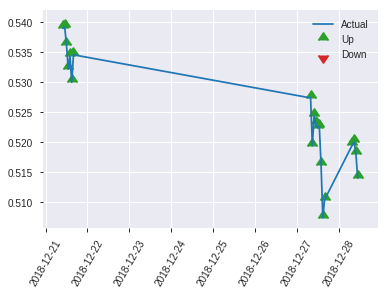


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25179420537834074
RMSE: 0.5017909977055595
LogLoss: 0.6968307007175201
Mean Per-Class Error: 0.4551689528270324
AUC: 0.5196554031448645
pr_auc: 0.46132517920349453
Gini: 0.03931080628972894
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3794090747833252: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    118  0.9672   (118.0/122.0)
1      1    97   0.0102   (1.0/98.0)
Total  5    215  0.5409   (119.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.379409     0.619808  214
max f2                       0.35285      0.801964  218
max f0point5                 0.482692     0.506645  125
max accuracy                 0.551838     0.572727  45
max precision                0.644085     1         0
max recall                   0.35285      1         218
max specificity              0.644085     1         0
max absolute_mcc             0.551838     0.101406  45
max min_per_class_accuracy   0.498154     0.491803  110
max mean_per_class_accuracy  0.482692     0.544831  125

Gains/Lift Table: Avg response rate: 44.55 %, avg score: 49.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.634831           0.748299  0.748299           0.333333         0.638419  0.333333                    0.638419            0.0102041       0.0102041                  -25.1701  -25.1701
    2        0.0227273                   0.625821           2.2449    1.34694            1                0.631213  0.6                         0.635537            0.0204082       0.0306122                  124.49    34.6939
    3        0.0318182                   0.61672            1.12245   1.2828             0.5              0.61878   0.571429                    0.630749            0.0102041       0.0408163                  12.2449   28.2799
    4        0.0409091                   0.610506           0         0.997732           0                0.614231  0.444444                    0.627078            0               0.0408163                  -100      -0.226757
    5        0.05                        0.605671           1.12245   1.02041            0.5              0.608185  0.454545                    0.623643            0.0102041       0.0510204                  12.2449   2.04082
    6        0.1                         0.58073            1.22449   1.12245            0.545455         0.596802  0.5                         0.610222            0.0612245       0.112245                   22.449    12.2449
    7        0.15                        0.567469           1.02041   1.08844            0.454545         0.574789  0.484848                    0.598411            0.0510204       0.163265                   2.04082   8.84354
    8        0.2                         0.552812           1.42857   1.17347            0.636364         0.559034  0.522727                    0.588567            0.0714286       0.234694                   42.8571   17.3469
    9        0.3                         0.533498           0.612245  0.986395           0.272727         0.542143  0.439394                    0.573092            0.0612245       0.295918                   -38.7755  -1.36054
    10       0.4                         0.514272           1.02041   0.994898           0.454545         0.523799  0.443182                    0.560769            0.102041        0.397959                   2.04082   -0.510204
    11       0.5                         0.498397           0.918367  0.979592           0.409091         0.506682  0.436364                    0.549951            0.0918367       0.489796                   -8.16327  -2.04082
    12       0.6                         0.477135           1.42857   1.05442            0.636364         0.487809  0.469697                    0.539594            0.142857        0.632653                   42.8571   5.44218
    13       0.7                         0.466782           0.816327  1.02041            0.363636         0.472356  0.454545                    0.529989            0.0816327       0.714286                   -18.3673  2.04082
    14       0.8                         0.44678            1.02041   1.02041            0.454545         0.458211  0.454545                    0.521017            0.102041        0.816327                   2.04082   2.04082
    15       0.9                         0.41968            0.714286  0.986395           0.318182         0.435912  0.439394                    0.51156             0.0714286       0.887755                   -28.5714  -1.36054
    16       1                           0.335051           1.12245   1                  0.5              0.387004  0.445455                    0.499105 

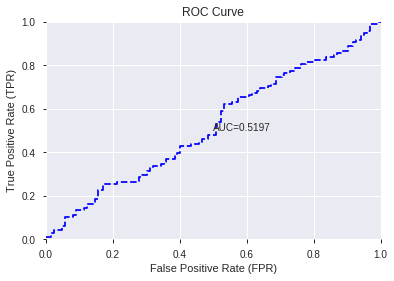

This function is available for GLM models only


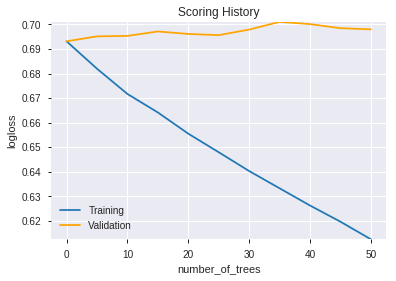

--2019-08-28 18:08:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_180814_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_180814_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_b253',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['CORREL_30',
 'ADX_20',
 'LINEARREG_ANGLE_20',
 'HT_DCPERIOD',
 'MFI_8',
 'TRANGE',
 'BOP',
 'HT_PHASOR_quadrature',
 'BETA_14',
 'DX_14',
 'HT_PHASOR_inphase',
 'BETA_24',
 'WILLR_24',
 'MACDFIX_hist_12',
 'STOCHRSI_fastd',
 'STOCH_slowd',
 'MFI_24',
 'ADX_24',
 'STDDEV_8',
 'MACDFIX_hist_8',
 'ADOSC',
 'DX_8',
 'aroonup_20',
 'BETA_30',
 'CORREL_12',
 'ROC_20',
 'MACDFIX_hist_24',
 'CCI_20',
 'ADXR_8',
 'VAR_14',
 'NATR_14',
 'aroondown_30',
 'CORREL_20',
 'STDDEV_24',
 'LINEARREG_ANGLE_8',
 'CMO_14',
 'MACDFIX_hist_14',
 'PPO',
 'CCI_14',
 'PLUS_DI_30',
 'WILLR_14',
 'BETA_8',
 'PLUS_DM_20',
 'NATR_24',
 'ADX_8',
 'MFI_14',
 'PLUS_DI_14',
 'ROC_8',
 'AD',
 'MACDFIX_hist_20',
 'LINEARREG_ANGLE_24',
 'WILLR_20',
 'MINUS_DI_12',
 'CMO_30',
 'STOCHF_fastk',
 'ATR_8',
 'CCI_12',
 'ROC_24',
 'NATR_20',
 'BBANDS_lowerband_30_2_5',
 'CORREL_8',
 'APO',
 'AROONOSC_12',
 'ATR_12',
 'DX_12',
 'CORREL_24',
 'BETA_20',
 'CDLSPINNINGTOP',
 'MFI_30',
 'aroonup_14',
 'WILLR_30',
 'ADXR_14',
 'STDD

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.614
GLM             0.582
XGBoost         0.573
dtype: float64

DeepLearning    GLM  XGBoost
All          0.614  0.582    0.573
DLF          0.577  0.577    0.564
Fwe          0.582  0.582    0.573
RFE          0.586  0.582    0.573
XGBF         0.577  0.577    0.564





F1


DeepLearning    0.629
GLM             0.620
XGBoost         0.622
dtype: float64

DeepLearning    GLM  XGBoost
All          0.628  0.616    0.617
DLF          0.624  0.620    0.622
Fwe          0.618  0.616    0.617
RFE          0.616  0.616    0.620
XGBF         0.629  0.620    0.622





auc


DeepLearning    0.587
GLM             0.518
XGBoost         0.548
dtype: float64

DeepLearning    GLM  XGBoost
All          0.587  0.490    0.533
DLF          0.544  0.518    0.548
Fwe          0.524  0.490    0.533
RFE          0.541  0.505    0.520
XGBF         0.547  0.518    0.548





logloss


DeepLearning    0.871
GLM             0.702
XGBoost         0.699
dtype: float64

DeepLearning    GLM  XGBoost
All          0.688  0.699    0.699
DLF          0.871  0.691    0.696
Fwe          0.745  0.699    0.699
RFE          0.694  0.702    0.697
XGBF         0.697  0.691    0.696





mean_per_class_error


DeepLearning    0.455
GLM             0.462
XGBoost         0.455
dtype: float64

DeepLearning    GLM  XGBoost
All          0.412  0.461    0.451
DLF          0.452  0.462    0.443
Fwe          0.455  0.461    0.451
RFE          0.454  0.459    0.455
XGBF         0.453  0.462    0.443





rmse


DeepLearning    0.550
GLM             0.505
XGBoost         0.503
dtype: float64

DeepLearning    GLM  XGBoost
All          0.498  0.503    0.503
DLF          0.550  0.499    0.501
Fwe          0.510  0.503    0.503
RFE          0.500  0.505    0.502
XGBF         0.502  0.499    0.501





mse


DeepLearning    0.303
GLM             0.255
XGBoost         0.253
dtype: float64

DeepLearning    GLM  XGBoost
All          0.248  0.253    0.253
DLF          0.303  0.249    0.251
Fwe          0.260  0.253    0.253
RFE          0.250  0.255    0.252
XGBF         0.252  0.249    0.251

{'F1':       DeepLearning    GLM  XGBoost
 All          0.628    NaN      NaN
 DLF          0.624    NaN      NaN
 DLF            NaN  0.620      NaN
 DLF            NaN    NaN    0.622
 All            NaN  0.616      NaN
 All            NaN    NaN    0.617
 XGBF         0.629    NaN      NaN
 XGBF           NaN  0.620      NaN
 XGBF           NaN    NaN    0.622
 Fwe          0.618    NaN      NaN
 Fwe            NaN  0.616      NaN
 Fwe            NaN    NaN    0.617
 RFE          0.616    NaN      NaN
 RFE            NaN  0.616      NaN
 RFE            NaN    NaN    0.620,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.614    NaN      NaN
 DLF          0.577    NaN      NaN
 DLF            NaN  0.577      NaN
 DLF            NaN    NaN    0.564
 All            NaN  0.582      NaN
 All            NaN    NaN    0.573
 XGBF         0.577    NaN      NaN
 XGBF           NaN  0.577      NaN
 XGBF           NaN    NaN    0.564
 Fwe          0.582    NaN      NaN
 Fwe     